In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline


In [2]:
%reload_ext autoreload
%autoreload 2

### import panqc (pan-genome quality control) toolkit functions
from panqc.ava import ava
from panqc.nscluster import clusterBy_KmerJC, summarize_NSClusters, create_MaxKmerSim_JC_Dict, create_MST_FiltByJC, make_ClusterID_Maps 
from panqc.nscluster import make_NS_ClusterMerged_Pres_DF


from panqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs

from panqc.utils import  parse_PG_Ref_FA, get_PG_Stats_FromDNASeqPresAbs, get_PG_Stats_FromPresAbs_V2


from panqc.asm_gene_search import parse_AlnHits_To_DF
from panqc.asm_gene_search import PresAbsQC_CheckAsmForGeneSeq, SRAsm_PresAbsQC_CheckInLRAsm
from panqc.asm_gene_search import get_SRAsm_Vs_LRAsm_QCStats


In [3]:
from scipy.stats import mannwhitneyu

In [4]:
import time

In [5]:
import screed

In [6]:
import mappy as mp

In [7]:
# Set max column width to a specific value (e.g., 100 characters)
pd.set_option('display.max_colwidth', 100)
# Set to display a specific number of columns (e.g., 20 columns)
pd.set_option('display.max_columns', 180)

# Parse sample metadata & preprocessed genome info/results

In [8]:
!pwd

/n/data1/hms/dbmi/farhat/mm774/Snakemake_Pipelines/mtb-pg-benchmarking-2024paper/Analysis/Part5_Eval_SRAsmBasedPGAnalysis


In [9]:
#!ls -1 ../../Data

## Parse sample Metadata (N = 151)

In [10]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

## PARSE PATHs FOR ALL assemblies processed by this pipeline

In [11]:
WGA151CI_LRandSR_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")
print(WGA151CI_LRandSR_Asm_Path_DF.columns)
WGA151CI_LRandSR_Asm_Path_DF.columns = ['SampleID', 'Dataset_Tag',
                                        'Genome_LR_ASM_PATH', 'Genome_SR_ASM_PATH']


Index(['SampleID', 'Dataset_Tag', 'Genome_ASM_PATH',
       'ShortRead_Genome_ASM_PATH'],
      dtype='object')


In [12]:
WGA151CI_LRandSR_Asm_Path_DF.head(1)

SampleID     Dataset_Tag  \
0    N0072  ChinerOms_2019   

                                                                                    Genome_LR_ASM_PATH  \
0  /n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...   

                                                                                    Genome_SR_ASM_PATH  
0  /n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/...

#### Create Dict of Asm FA PATHs

In [13]:

LR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_LR_ASM_PATH']].values)
SR_AsmFA_Dict = dict(WGA151CI_LRandSR_Asm_Path_DF[['SampleID', 'Genome_SR_ASM_PATH']].values)


### Define Phylo order of samples:

In [14]:
OrderOfSampleIDs_Phylo = ['N0153', 'N0072', 'mada_2-46', 'mada_1-44', 'mada_107',
                          'mada_1-1', 'mada_1-51', 'mada_1-39', 'mada_1-36',
                          'mada_117', 'mada_122', 'mada_118', 'mada_1-10', 'R27252',
                          'R23887', 'TB3091', '9050-05', '3003-06', '702-06', '696-05',
                          '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB2780', 'TB3368',
                          'TB1236', 'TB2659', '8129-04', 'R30215', 'R25048', 'TB2512',
                          'TB2981', 'TB2995', 'TB3113', '706-05', 'R30078', 'R28012',
                          'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                          'R29816', 'S0070-08', 'N0155', 'N0145', 'R29598', 'R24100',
                          'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                          'mada_1-11', 'M0003941_3', 'mada_115', 'mada_2-42', 'R37765',
                          '18_0621851', 'R22601', 'R27937', 'R18040', 'R18043', 'R27725',
                          'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R32929',
                          'R26778', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004',
                          'mada_1-30', 'N0054', 'N1274', '01_R1134', 'TB2968', 'mada_1-53',
                          'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123',
                          'mada_1-12', 'mada_1-15', 'mada_128', 'mada_1-38', 'TB3054',
                          'mada_126', 'mada_120', 'TB4620', 'M0016737_0', 'M0016395_7',
                          'R15311', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'M0010874_7',
                          'QC-7', 'QC-6', 'QC-1', '01_R1430', 'M0011368_9', '02_R1896',
                          'mada_2-25', 'TB3237', 'mada_103', 'mada_112', 'mada_124',
                          'S0123-01', 'S0262-02', 'TB3251', 'M0017522_5', 'R30396', 'R20896',
                          'mada_1-32', 'S0106-01', 'R21839', 'R21363', 'R21770', 'MT_0080','mada_102',
                          'TB3334', 'M0014888_3', 'mada_151', 'TB3169', 'mada_105', 'QC-8',
                          'QC-10', 'QC-4', 'mada_129', 'mada_139', '02_R1708', '02_R0894',
                          'mada_2-31', 'mada_1-41', 'N1272', 'N1176', 'N1202', 'N0091',
                          'N1177','RW-TB008']


### Parse Asm QC results

In [15]:
!ls -1 ../../Data 

230905_Ecoli_50CI_Metadata_Shaw2021
231121_HybridMtbAsm_QCPass_Meta_Set3_AsmPolishStats_OLD
231121.InputAsmTSVs.MtbSetV3.151CI
231130_Mtb_HybridVsSR_AsmSummary_TSVs
240116.PG_Results
Ecoli_50CI_Phylo
Evaluate_SRAsmPGAnalysis_WiHybridAsm
MtbPangenomeAnalysis_SetV3
MtbPangenomeAnalysis_SetV4
README.md
SRAENA_RunMetadata


In [16]:
Repo_DataDir = "../../Data"

AsmSummary_TSVs_Dir = Repo_DataDir + "/231130_Mtb_HybridVsSR_AsmSummary_TSVs"   

WGA151CI_AsmQCSumm_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv"
WGA151CI_AsmQC_Tidy_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv"

WGA151CI_Asm_LRvsSR_DF = pd.read_csv(WGA151CI_AsmQCSumm_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_DF.shape)

WGA151CI_Asm_LRvsSR_TidyDF = pd.read_csv(WGA151CI_AsmQC_Tidy_TSV, sep="\t")
print(WGA151CI_Asm_LRvsSR_TidyDF.shape)

(151, 16)
(302, 11)


In [17]:
SRAsm_BUSCO_Dict = WGA151CI_Asm_LRvsSR_DF.set_index('SampleID')['SRAsm_Busco_Complete_Score'].to_dict()   


### Get SampleIDs associated w/ High & Low BUSCO scores (>= 99 or < 99)

In [18]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99").shape

(136, 16)

In [19]:
WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").shape

(15, 16)

In [20]:
High_SRBusco_SampleIDs_136CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99")["SampleID"].values     

Low_SRBusco_SampleIDs_15CI = WGA151CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99")["SampleID"].values

# Extracting the mapping between SampleID and SR BUSCO Score
SampleTo_SRBUSCO_Map = WGA151CI_Asm_LRvsSR_DF.set_index('SampleID')['SRAsm_Busco_Complete_Score'].to_dict()


In [21]:
Low_SRBusco_SampleIDs_15CI

array(['TB1612', 'TB2981', '02_R1896', 'TB3334', 'N1176', 'N1177',
       'RW-TB008', 'QC-7', 'mada_107', 'R30215', 'R25048', 'R21408',
       'R21770', 'R20896', 'mada_1-38'], dtype=object)

In [22]:
len(Low_SRBusco_SampleIDs_15CI)

15

In [23]:
len(High_SRBusco_SampleIDs_136CI)

136

In [24]:
WGA151CI_AsmSummary_DF.head(5)

SampleID  numContigs_Complete  Flye_CircContig_Cov PrimaryLineage  \
0    N0072                    1                  358       lineage1   
1    N0153                    1                  372       lineage1   
2   TB3113                    1                  933       lineage2   
3   TB1236                    1                  374       lineage2   
4   TB2659                    1                  421       lineage2   

                                           Lineage         Dataset_Tag  \
0                 lineage1,lineage1.1,lineage1.1.2      ChinerOms_2019   
1  lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1      ChinerOms_2019   
2                 lineage2,lineage2.2,lineage2.2.1  TB_Portals_24CI_R1   
3                 lineage2,lineage2.2,lineage2.2.1  TB_Portals_24CI_R1   
4                 lineage2,lineage2.2,lineage2.2.1  TB_Portals_24CI_R1   

                 AsmApproach  
0  PBrs2_LR_Flye_I3_SR_Pilon  
1  PBrs2_LR_Flye_I3_SR_Pilon  
2  PBrs2_LR_Flye_I3_SR_Pilon  
3  PBrs2_LR_Flye_I3_SR_Pilon  
4  PBrs2_LR_Flye_I3_SR_Pilon

#### Make sample lineage & color mapping

In [25]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "lineage1": "#DF83AC",
    "lineage2": "#7098CB",
    "lineage3": "#815D9F",
    "lineage4": "#E76956",
    "lineage5": "#B67548",
    "lineage6": "#6AB79E",
    "lineage8": "#E4515B",
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = WGA151CI_AsmSummary_DF.set_index('SampleID')['PrimaryLineage'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [26]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


## Define output dirs of Pangenome Analysis pipelines

In [27]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


### Define path to Panaroo output files (151 LR genomes, MergeParalogs Parameters)

In [28]:
# PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
#                          'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
#                          'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
#                          'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default']


PG_OutDir_Dict = {   "SR_Panaroo_Strict_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Strict_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Moderate_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Moderate_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Sens_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     "SR_Roary_Default": f"{i_Pangenome_Dir}/SR_Roary_Default_AllIsolates",
                     "SR_Roary_NoSplitParalogs": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I90": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I80": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I80_AllIsolates"
                   }


PG_PresAbs_CSV_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_CSV_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv"  
    
PG_PresAbs_Rtab_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_Rtab_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.Rtab"  

PG_GeneRefFA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_GeneRefFA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.fa"  

PG_AvA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_AvA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv"


PG_PresAbs_AsmGeneSeqChk_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_AsmGeneSeqChk_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.AsmGeneSeqChk.tsv"

PG_PresAbs_LRAsmQC_PATH_Dict = {}
for i_param in ["SR_Panaroo_Strict_MP", "SR_Panaroo_Moderate_MP", "SR_Panaroo_Sens_MP", #"SR_Roary_Default",  
                 "SR_Roary_NoSplitParalogs", "SR_Roary_NoSplitParalogs_I90", "SR_Roary_NoSplitParalogs_I80"]:

    i_outdir = PG_OutDir_Dict[i_param]
    PG_PresAbs_LRAsmQC_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv.DNAseqQCWiLRAsm.csv" 


In [29]:
#PG_PresAbs_LRAsmQC_PATH_Dict

In [30]:
#PG_GeneRefFA_PATH_Dict

In [31]:
#i_PG_Out = PG_OutDir_Dict["Panaroo_Strict_MP"]   

In [32]:
#!ls -1 $i_PG_Out  

In [33]:
i_PG_Out = PG_OutDir_Dict["SR_Roary_NoSplitParalogs_I80"]    

In [34]:
!ls -1 $i_PG_Out  

_1700897361
accessory_binary_genes.fa
accessory_binary_genes.fa.newick
accessory_graph.dot
accessory.header.embl
accessory.tab
blast_identity_frequency.Rtab
clustered_proteins
core_accessory_graph.dot
core_accessory.header.embl
core_accessory.tab
core_alignment_header.embl
core_gene_alignment.aln
fixed_input_files
gene_presence_absence.AsmGeneSeqChk.tsv
gene_presence_absence.csv
gene_presence_absence.csv.DNAseqQCWiLRAsm.csv
gene_presence_absence.Rtab
number_of_conserved_genes.Rtab
number_of_genes_in_pan_genome.Rtab
number_of_new_genes.Rtab
number_of_unique_genes.Rtab
pan_genome_reference.fa
pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv
summary_statistics.txt
tmp


# Parse in processed data

### A) Parse in processed All vs All Kmer analysis

In [35]:
AvA_DF_Dict = {}

for i_Param, AvA_TSV_PATH in PG_AvA_PATH_Dict.items():

    PG_AvA_DF = pd.read_csv(AvA_TSV_PATH, sep = "\t" )
    AvA_DF_Dict[i_Param] = PG_AvA_DF


### B) Parse in Gene PresAbs Info

In [36]:
PresAbs_DF_Dict = {}

for i_Param, PresAbs_CSV_PATH in PG_PresAbs_CSV_PATH_Dict.items():

    if "Roary" in i_Param: 
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Roary(PresAbs_CSV_PATH)
    else:
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Panaroo(PresAbs_CSV_PATH)

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".Bakta")[0] for x in i_Gene_PresAbs_DF.columns ]

    print(i_Param, i_Gene_PresAbs_DF.shape)
    
    PresAbs_DF_Dict[i_Param] = i_Gene_PresAbs_DF
    

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (7,13,18,26,29,39,89,110,111,125,134,151) have mixed types.Specify dtype option on import or set low_memory=False.
  


SR_Panaroo_Strict_MP (4211, 153)
SR_Panaroo_Moderate_MP (4382, 153)
SR_Panaroo_Sens_MP (4600, 153)
SR_Roary_Default (6006, 153)
SR_Roary_NoSplitParalogs (5025, 153)
SR_Roary_NoSplitParalogs_I90 (4956, 153)
SR_Roary_NoSplitParalogs_I80 (4866, 153)


### C) Parse in PG Gene Reference FASTAs for each PG output

In [37]:

PG_RefSeqs_DF_Dict = {}

for i_Param, i_PG_Ref_FA_PATH in PG_GeneRefFA_PATH_Dict.items():
    #print(i_PG_Ref_FA_PATH)
    PG_RefSeqs_DF_Dict[i_Param] = parse_PG_Ref_FA(i_PG_Ref_FA_PATH)

    LR_PG_Ref_IDs = list( PG_RefSeqs_DF_Dict[i_Param].keys())
    print(i_Param, len(LR_PG_Ref_IDs))
    

SR_Panaroo_Strict_MP 4211
SR_Panaroo_Moderate_MP 4382
SR_Panaroo_Sens_MP 4600
SR_Roary_Default 6006
SR_Roary_NoSplitParalogs 5025
SR_Roary_NoSplitParalogs_I90 4956
SR_Roary_NoSplitParalogs_I80 4866


## E) PresAbs w/ SR-PG QC using the LR-Asm

In [38]:
i_SampleIDs = SampleIDs_151CI_SOI
Pres_LRAsmQC_Dict = {}

for i_Param, PresAbs_LRAsmQC_TSV_PATH in PG_PresAbs_LRAsmQC_PATH_Dict.items():

    i_PresAbs_LRAsmQC_DF = pd.read_csv(PresAbs_LRAsmQC_TSV_PATH, sep="\t").set_index("Gene", drop=False)  

    #i_PresAbs_LRAsmQC_DF["NumAsm_WiGene_AdjByIncompCDSAsm"] = i_PresAbs_LRAsmQC_DF[i_SampleIDs].applymap(lambda x: 1 if x in [1, 3] else 0).sum(axis = 1)
    #i_PresAbs_LRAsmQC_DF["NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc"] = i_PresAbs_LRAsmQC_DF[i_SampleIDs].applymap(lambda x: 1 if x in [1, 3, 4, 5] else 0).sum(axis = 1)

    Pres_LRAsmQC_Dict[i_Param] = i_PresAbs_LRAsmQC_DF

    print(i_Param, "-", i_PresAbs_LRAsmQC_DF.shape)
    #!wc -l $PresAbs_LRAsmQC_CSV_PATH

SR_Panaroo_Strict_MP - (4211, 154)
SR_Panaroo_Moderate_MP - (4382, 154)
SR_Panaroo_Sens_MP - (4600, 154)
SR_Roary_NoSplitParalogs - (5025, 154)
SR_Roary_NoSplitParalogs_I90 - (4956, 154)
SR_Roary_NoSplitParalogs_I80 - (4866, 154)


In [39]:
i_PresAbs_LRAsmQC_DF.columns

Index(['Gene', '01_R1134', '01_R1430', '02_R0894', '02_R1179', '02_R1708',
       '02_R1896', '18_0621851', '3003-06', '4549-04',
       ...
       'mada_139', 'mada_151', 'mada_2-1', 'mada_2-25', 'mada_2-31',
       'mada_2-42', 'mada_2-46', 'mada_2-53', 'NumAsm_WiGene',
       'NumAsm_WiGene_DNASeq'],
      dtype='object', length=154)

In [40]:
#i_PresAbs_LRAsmQC_DF.query("(NumAsm_WiGene_AdjByIncompCDSAsm > 2) & (NumAsm_WiGene_AdjByIncompCDSAsm < 158)")[['Gene', 'NumAsm_WiGene', 'NumAsm_WiGene_DNASeq',  'NumAsm_WiGene_AdjByIncompCDSAsm']]

In [41]:
i_PresAbs_LRAsmQC_DF = Pres_LRAsmQC_Dict["SR_Roary_NoSplitParalogs_I90"]

In [42]:
i_PresAbs_LRAsmQC_DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate_MP"]

# Summarize high-level stats for "LRAsm QC" of SR based analysis

### Notes
- 0 means CDS AA seq & DNA seq not found in SR
- 1 means CDS AA seq present in SR
- 3 Means DNA Seq "Not in SR, but In LR Asm", ("Incomplete Assembly")
- 4 Means DNA Seq "In SR Asm, NOT In LR Asm" 
- 5 Means DNA Seq "In SR Asm, In LR Asm" ("Annotation Discrepancy")


In [43]:
ListOf_SampleID_Cols = SampleIDs_151CI_SOI

In [44]:
listOfRows = []

for i_Param, i_PresAbs_LRAsmQC_DF in Pres_LRAsmQC_Dict.items():

    print(i_Param)

    i_Counts = get_SRAsm_Vs_LRAsm_QCStats(i_PresAbs_LRAsmQC_DF, ListOf_SampleID_Cols, False)
    NAbs_0, NPres_1, NAbs_DNAInLR_3, NAbs_DNAInSR_4, NAbs_DNAInSRandLR_5 = i_Counts

    listOfRows.append((i_Param, NAbs_0, NPres_1, NAbs_DNAInLR_3, NAbs_DNAInSR_4, NAbs_DNAInSRandLR_5)  )
    
    #print("\n\n\n")


Summ_DF = pd.DataFrame(listOfRows)

Summ_DF.columns = ["Param", "NAbs_0", "NPres_1", "NAbs_DNAInLR_3", "NAbs_DNAInSR_4", "NAbs_DNAInSRandLR_5"]

Summ_DF["NAbs_AnnoDiscrep"] = Summ_DF["NAbs_DNAInSR_4"] + Summ_DF["NAbs_DNAInSRandLR_5"]
Summ_DF["NAbs_IncompAsm"] = Summ_DF["NAbs_DNAInLR_3"]
Summ_DF["NAbs_Total"] = Summ_DF["NAbs_0"] + Summ_DF["NAbs_DNAInLR_3"] + Summ_DF["NAbs_DNAInSR_4"] + Summ_DF["NAbs_DNAInSRandLR_5"] 

Summ_DF["PercAbs_0"] = Summ_DF["NAbs_0"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInLR_3"] = Summ_DF["NAbs_DNAInLR_3"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInSR_4"] = Summ_DF["NAbs_DNAInSR_4"] / Summ_DF["NAbs_Total"] * 100
Summ_DF["PercAbs_DNAInSRandLR_5"] = Summ_DF["NAbs_DNAInSRandLR_5"] / Summ_DF["NAbs_Total"] * 100

Perc_Cols = ["PercAbs_0", "PercAbs_DNAInLR_3", "PercAbs_DNAInSR_4", "PercAbs_DNAInSRandLR_5"]

Summ_DF[Perc_Cols] = Summ_DF[Perc_Cols].round(2)

Summ_DF["PercAbs_AnnoDiscrep"] = Summ_DF["PercAbs_DNAInSR_4"] + Summ_DF["PercAbs_DNAInSRandLR_5"] 
Summ_DF["PercAbs_IncompAsm"] = Summ_DF["PercAbs_DNAInLR_3"]

SRPG_LRQC_Summ_DF = Summ_DF 

SR_Panaroo_Strict_MP
SR_Panaroo_Moderate_MP
SR_Panaroo_Sens_MP
SR_Roary_NoSplitParalogs
SR_Roary_NoSplitParalogs_I90
SR_Roary_NoSplitParalogs_I80


In [45]:
!ls -1 ../../

Analysis
CondaEnvs
Data
LICENSE
Notes
README.md
References
Scripts
Snakemake_Pipelines


In [46]:
!mkdir ../../Data/Evaluate_SRAsmPGAnalysis_WiHybridAsm   

mkdir: cannot create directory ‘../../Data/Evaluate_SRAsmPGAnalysis_WiHybridAsm’: File exists


In [47]:
SRPG_LRQC_Summ_DF.to_csv("../../Data/Evaluate_SRAsmPGAnalysis_WiHybridAsm/SRPG_LRQC_Summ_DF.tsv", sep="\t", index=False)

In [48]:
#SRPG_LRQC_Summ_DF

In [49]:
LRQC_SimpCol = ["Param", "NAbs_0", "NPres_1", "NAbs_AnnoDiscrep", "NAbs_IncompAsm", "NAbs_Total", "PercAbs_AnnoDiscrep", "PercAbs_IncompAsm"]     

SRPG_LRQC_Summ_DF[LRQC_SimpCol]

Param  NAbs_0  NPres_1  NAbs_AnnoDiscrep  \
0          SR_Panaroo_Strict_MP   15053   600688             15606   
1        SR_Panaroo_Moderate_MP   20324   609813             24976   
2            SR_Panaroo_Sens_MP   34079   610926             40144   
3      SR_Roary_NoSplitParalogs   50300   597507             98930   
4  SR_Roary_NoSplitParalogs_I90   46473   597068             93822   
5  SR_Roary_NoSplitParalogs_I80   41820   592992             89714   

   NAbs_IncompAsm  NAbs_Total  PercAbs_AnnoDiscrep  PercAbs_IncompAsm  
0            4514       35173                44.37              12.83  
1            6569       51869                48.15              12.66  
2            9451       83674                47.98              11.30  
3           12038      161268                61.35               7.46  
4           10993      151288                62.02               7.27  
5           10240      141774                63.28               7.22

In [50]:
SRPG_LRQC_Summ_DF

Param  NAbs_0  NPres_1  NAbs_DNAInLR_3  \
0          SR_Panaroo_Strict_MP   15053   600688            4514   
1        SR_Panaroo_Moderate_MP   20324   609813            6569   
2            SR_Panaroo_Sens_MP   34079   610926            9451   
3      SR_Roary_NoSplitParalogs   50300   597507           12038   
4  SR_Roary_NoSplitParalogs_I90   46473   597068           10993   
5  SR_Roary_NoSplitParalogs_I80   41820   592992           10240   

   NAbs_DNAInSR_4  NAbs_DNAInSRandLR_5  NAbs_AnnoDiscrep  NAbs_IncompAsm  \
0              47                15559             15606            4514   
1              85                24891             24976            6569   
2             139                40005             40144            9451   
3              90                98840             98930           12038   
4              88                93734             93822           10993   
5              75                89639             89714           10240   

   NAbs_Total  PercAbs_0  PercAbs_DNAInLR_3  PercAbs_DNAInSR_4  \
0       35173      42.80              12.83               0.13   
1       51869      39.18              12.66               0.16   
2       83674      40.73              11.30               0.17   
3      161268      31.19               7.46               0.06   
4      151288      30.72               7.27               0.06   
5      141774      29.50               7.22               0.05   

   PercAbs_DNAInSRandLR_5  PercAbs_AnnoDiscrep  PercAbs_IncompAsm  
0                   44.24                44.37              12.83  
1                   47.99                48.15              12.66  
2                   47.81                47.98              11.30  
3                   61.29                61.35               7.46  
4                   61.96                62.02               7.27  
5                   63.23                63.28               7.22

In [51]:
15053 + 15606 + 4514

35173

In [52]:
6569 + 24976 + 20324

51869

In [53]:
N_Genomes = len(ListOf_SampleID_Cols)
N_Genomes

151

In [54]:
#!pgqc --help  

In [55]:
!panqc --help  

usage: panqc [-h] {nrc,utils} ...

Toolkit for focused on augmenting common CDS based pan-genome analysis with
nucleotide sequence comparison.

positional arguments:
  {nrc,utils}  Please select one of the pipelines of the PanQC toolkit.
    nrc        (Nucleotide Redundancy Correction) Adjusts for nucleotide
               redundancy in estimated pan-genomes
    utils      (Utilities) Sub-pipelines related to NRC approach or other
               types of pan-genome workflows

optional arguments:
  -h, --help   show this help message and exit


In [56]:
i_SampleIDs = SampleIDs_151CI_SOI
SRQC_Panaroo_SMP_GenePres_DF = Pres_LRAsmQC_Dict["SR_Panaroo_Strict_MP"]

SRQC_Panaroo_SMP_GenePres_DF.shape

(4211, 154)

In [57]:
#SRQC_Panaroo_SMP_GenePres_DF.head(3)

In [58]:
AnnDisc_sorted_series = (SRQC_Panaroo_SMP_GenePres_DF[SampleIDs_151CI_SOI].isin([4,5]).sum().sort_values(ascending=False))
                         
IncompAsm_sorted_series = (SRQC_Panaroo_SMP_GenePres_DF[i_SampleIDs] == 3).sum() .sort_values(ascending=False) 

### Notes
- 0 means CDS AA seq & DNA seq not found in SR
- 1 means CDS AA seq present in SR
- 3 Means DNA Seq "Not in SR, but In LR Asm", ("Incomplete Assembly")
- 4 Means DNA Seq "In SR Asm, NOT In LR Asm" 
- 5 Means DNA Seq "In SR Asm, In LR Asm" ("Annotation Discrepancy")


In [59]:
LRQC_AbsTypes_Vs_SRBUSCO_DF = pd.concat([IncompAsm_sorted_series, AnnDisc_sorted_series], axis =1)

LRQC_AbsTypes_Vs_SRBUSCO_DF.columns = ["Abs_IncompAsm", "Abs_CDSAnnoDisc"]
LRQC_AbsTypes_Vs_SRBUSCO_DF["SampleID"] = LRQC_AbsTypes_Vs_SRBUSCO_DF.index
LRQC_AbsTypes_Vs_SRBUSCO_DF["SR_BUSCO"] = LRQC_AbsTypes_Vs_SRBUSCO_DF["SampleID"].map(SampleTo_SRBUSCO_Map)

# Assuming 'data' is your DataFrame and 'SR_BUSCO' is the column of interest
LRQC_AbsTypes_Vs_SRBUSCO_DF['BUSCO_Group'] = LRQC_AbsTypes_Vs_SRBUSCO_DF['SR_BUSCO'].apply(lambda x: 'High_BUSCO' if x > 99 else 'Low_BUSCO')

LRQC_AbsTypes_Vs_SRBUSCO_DF.shape

(151, 5)

In [60]:
LRQC_AbsTypes_Vs_SRBUSCO_DF.head(3)

Abs_IncompAsm  Abs_CDSAnnoDisc SampleID  SR_BUSCO BUSCO_Group
R25048            237               61   R25048      94.1   Low_BUSCO
R21770            169               78   R21770      90.8   Low_BUSCO
QC-7              122              113     QC-7      95.8   Low_BUSCO

In [61]:
# Splitting the data into high and low BUSCO score groups
IncompAsm_LoBUSCO_Ct = LRQC_AbsTypes_Vs_SRBUSCO_DF.query('SR_BUSCO > 99')['Abs_IncompAsm']
IncompAsm_HighBUSCO_Ct = LRQC_AbsTypes_Vs_SRBUSCO_DF.query('SR_BUSCO <= 99')['Abs_IncompAsm']

AnnoDiscrep_LoBUSCO_Ct = LRQC_AbsTypes_Vs_SRBUSCO_DF.query('SR_BUSCO > 99')['Abs_CDSAnnoDisc']
AnnoDiscrep_HighBUSCO_Ct = LRQC_AbsTypes_Vs_SRBUSCO_DF.query('SR_BUSCO <= 99')['Abs_CDSAnnoDisc']


In [62]:
# Perform Mann-Whitney U test
statistic, IncompAsm_p_value = mannwhitneyu(IncompAsm_LoBUSCO_Ct,
                                  IncompAsm_HighBUSCO_Ct, alternative="two-sided")

print("Mann-Whitney U Test for Incomp: ",statistic, IncompAsm_p_value)


Mann-Whitney U Test for Incomp:  134.0 3.270418987608347e-09


In [63]:

# Perform Mann-Whitney U test
statistic, AnnoDiscrep_p_value = mannwhitneyu(AnnoDiscrep_LoBUSCO_Ct,
                                  AnnoDiscrep_HighBUSCO_Ct, alternative="two-sided")

print("Mann-Whitney U Test for AnnoDiscrep: ", statistic, AnnoDiscrep_p_value)


Mann-Whitney U Test for AnnoDiscrep:  1400.0 0.12483020947218945


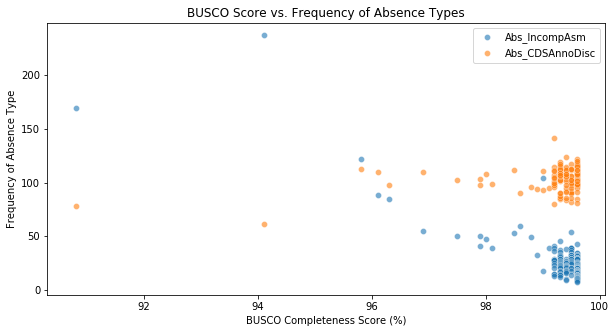

In [64]:
# Creating a scatterplot for the BUSCO score vs Abs_IncompAsm
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'SR_BUSCO', y='Abs_IncompAsm', data = LRQC_AbsTypes_Vs_SRBUSCO_DF, label='Abs_IncompAsm', alpha=0.6)

# Creating a scatterplot for the BUSCO score vs Abs_CDSAnnoDisc on the same plot
sns.scatterplot(x = 'SR_BUSCO', y='Abs_CDSAnnoDisc', data = LRQC_AbsTypes_Vs_SRBUSCO_DF, label='Abs_CDSAnnoDisc', alpha=0.6)

plt.title('BUSCO Score vs. Frequency of Absence Types')
plt.xlabel('BUSCO Completeness Score (%)')
plt.ylabel('Frequency of Absence Type')
plt.legend()
plt.show()

In [65]:
sns.set_style(None)
plt.style.use('../nqo.mplstyle')

mkdir: cannot create directory ‘Results4_Plots’: File exists


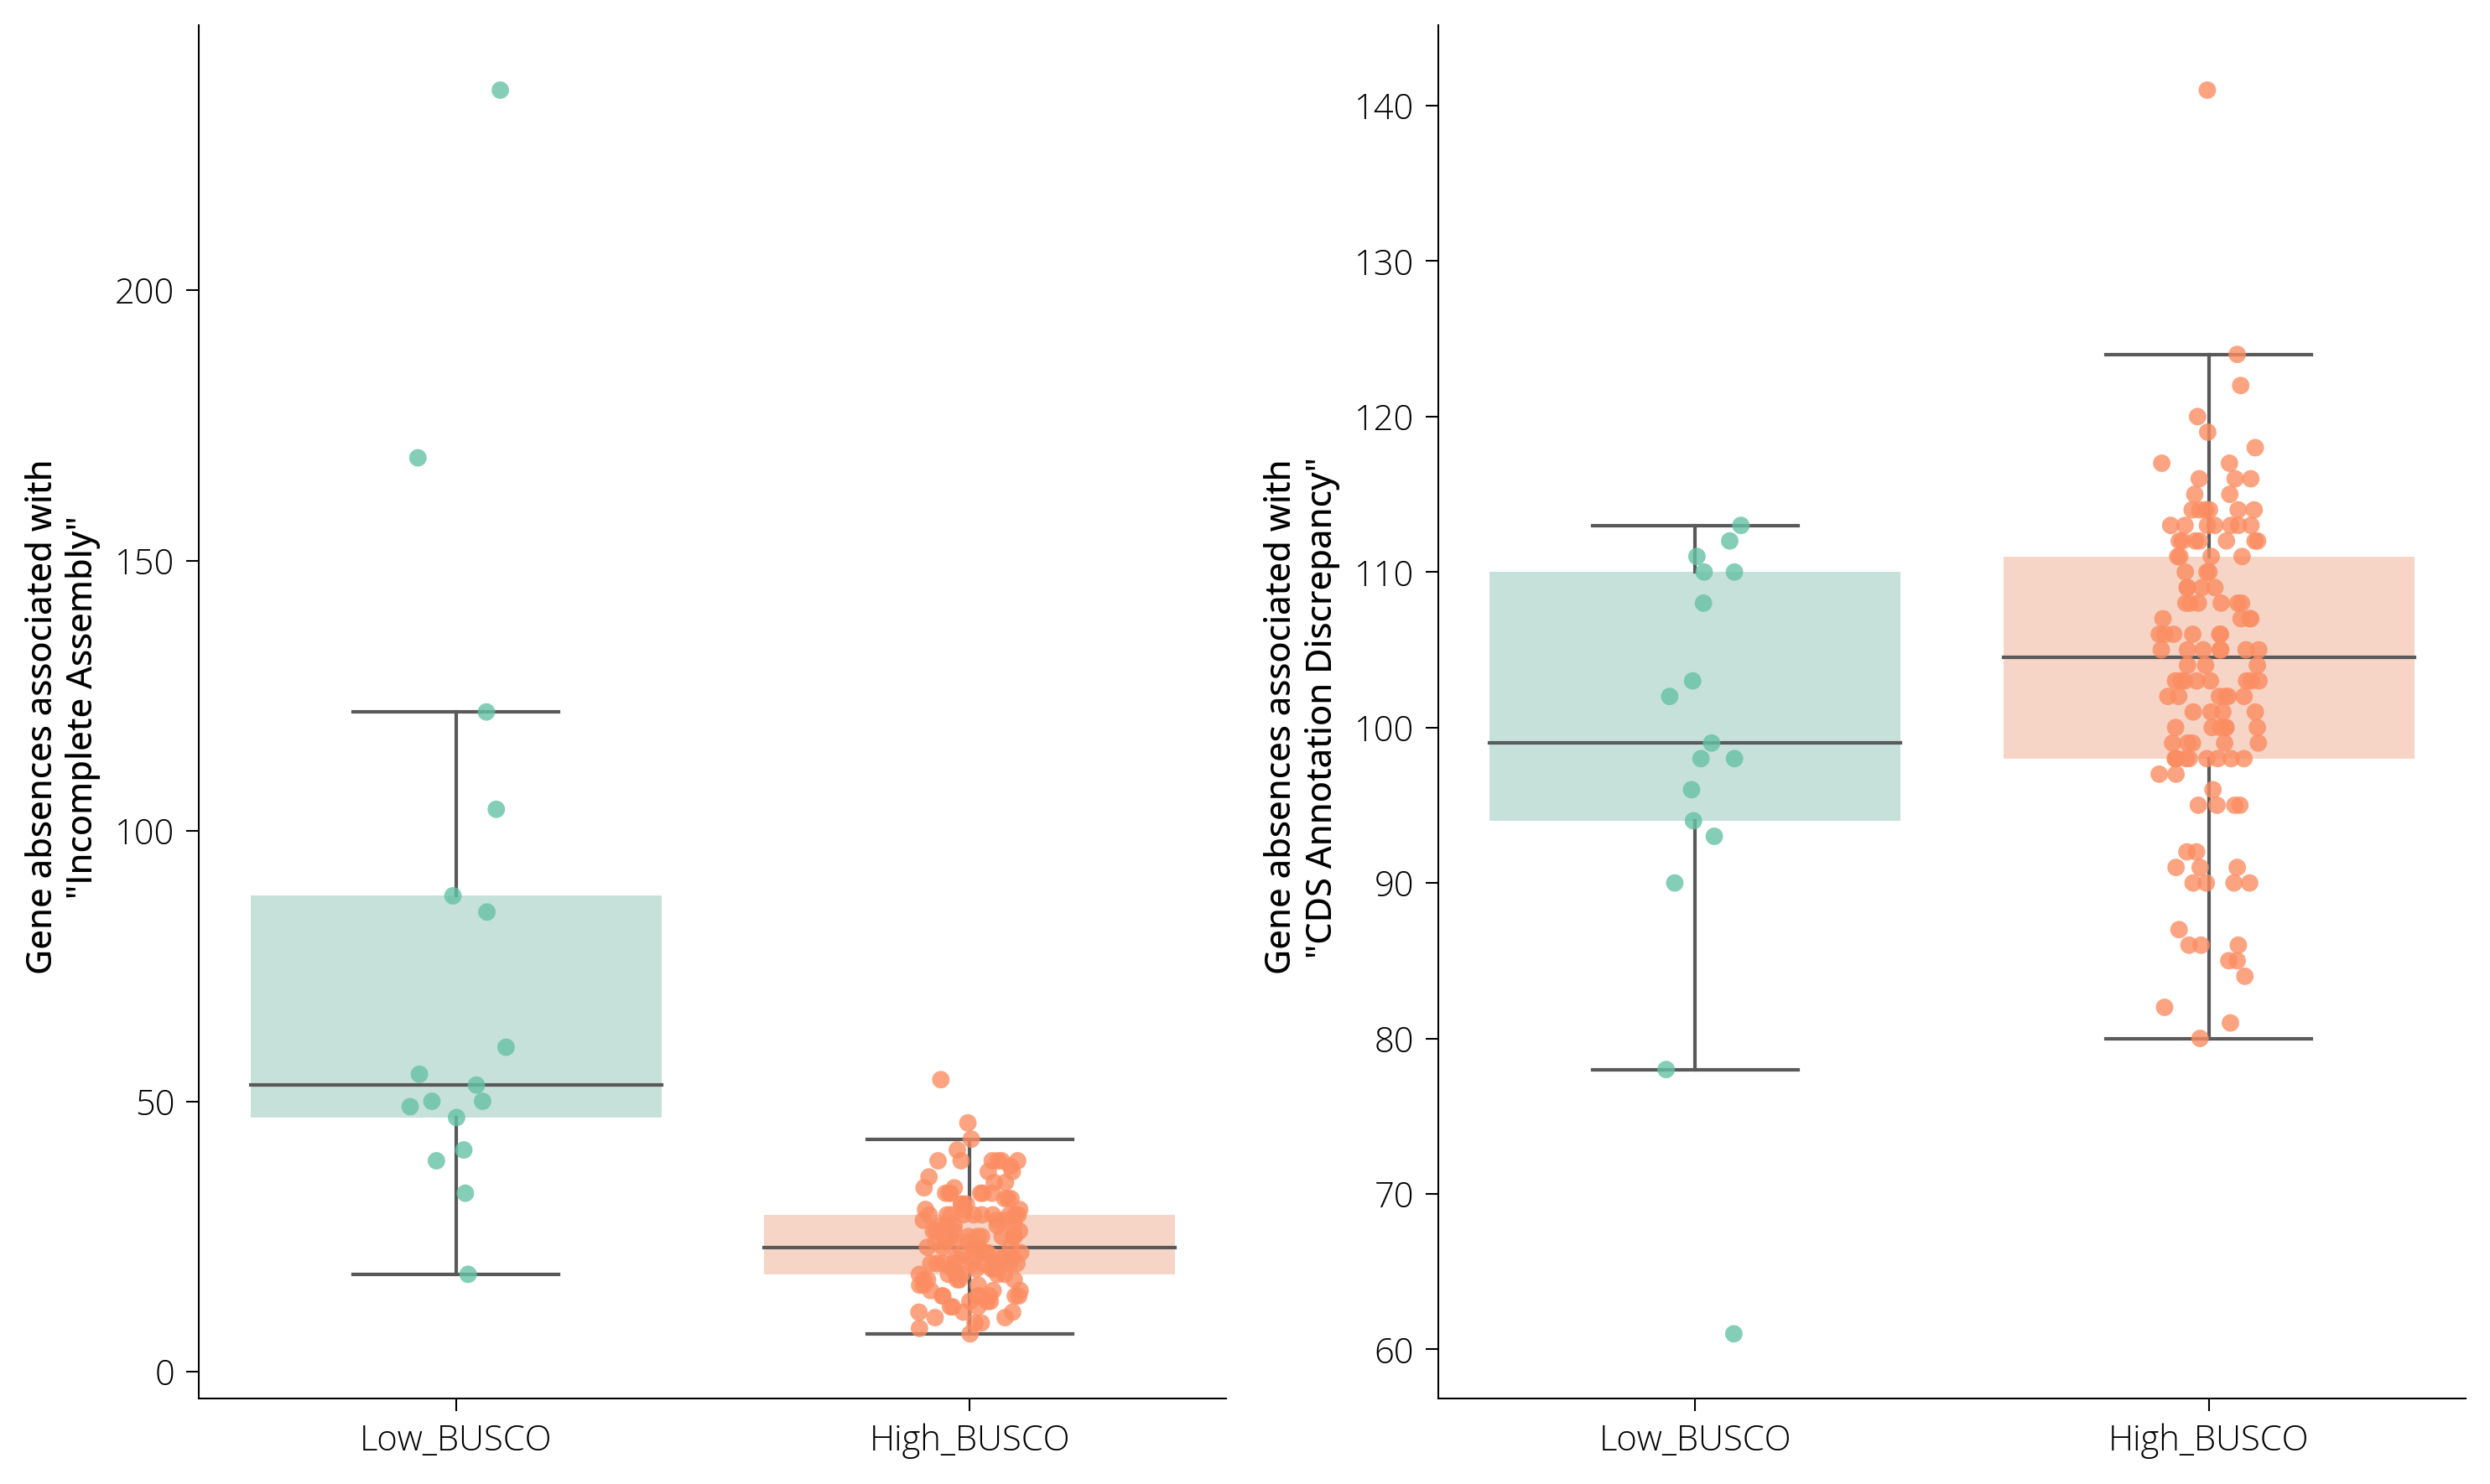

In [66]:
!mkdir Results4_Plots

# Create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
#fig.suptitle('Comparison of High and Low BUSCO SR Assemblies', fontsize=16, y = 1.05)

# Plot
sns.boxplot(x='BUSCO_Group', y='Abs_IncompAsm', data=LRQC_AbsTypes_Vs_SRBUSCO_DF, palette="Set2",
            boxprops=dict(alpha=0.4, linewidth=0),
            fliersize=0, ax=axes[0])
sns.stripplot(x='BUSCO_Group', y='Abs_IncompAsm', data=LRQC_AbsTypes_Vs_SRBUSCO_DF, palette="Set2",
              jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[0])

axes[0].set_ylabel('Gene absences associated with \n "Incomplete Assembly"')
axes[0].set_xlabel('')
sns.despine(ax=axes[0])

sns.boxplot(x='BUSCO_Group', y='Abs_CDSAnnoDisc', data=LRQC_AbsTypes_Vs_SRBUSCO_DF, palette="Set2",
            boxprops=dict(alpha=0.4, linewidth=0),
            fliersize=0, ax=axes[1])
sns.stripplot(x='BUSCO_Group', y='Abs_CDSAnnoDisc', data=LRQC_AbsTypes_Vs_SRBUSCO_DF, palette="Set2",
              jitter=True, marker='o', alpha=0.8, edgecolor='gray', ax=axes[1])

axes[1].set_ylabel('Gene absences associated with \n "CDS Annotation Discrepancy"')
axes[1].set_xlabel('')
sns.despine(ax=axes[1])

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Results4_Plots/HighVsLowBUSCO.AbsentGenesAssocBarplots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results4_Plots/HighVsLowBUSCO.AbsentGenesAssocBarplots.svg", bbox_inches="tight")
plt.show()


# Viz heatmap of SRAsm QC wi LR Asm

In [67]:
from matplotlib.colors import ListedColormap

colormap_dict = {0: "#FFFFD6", 1: "#041B4C", 2: "black", 3: "red", 4: "#15ACBB", 5: "#15ACBB"}

# Convert the custom dictionary to a colormap
colors = [colormap_dict[i] for i in sorted(colormap_dict.keys())]
custom_cmap = ListedColormap(colors)


colormap_dict2 = {0: "#FFFFD6", 1: "#041B4C", 2: "#FFFFD6", 3: "#FFFFD6", 4: "#FFFFD6", 5: "#FFFFD6"}

# Convert the custom dictionary to a colormap
colors_2 = [colormap_dict2[i] for i in sorted(colormap_dict2.keys())]
custom_cmap_2 = ListedColormap(colors_2)



In [68]:
sorted(colormap_dict.keys())

[0, 1, 2, 3, 4, 5]

In [69]:
custom_cmap

In [70]:
Pres_LRAsmQC_Dict["SR_Panaroo_Moderate_MP"].head(4)  

Gene  N0072  N0153  TB3113  TB1236  TB2659  TB2780  TB1612  \
Gene                                                                           
group_2429  group_2429      1      1       1       1       1       1       1   
rbsK              rbsK      1      1       1       1       1       1       1   
glfT1            glfT1      1      1       1       1       1       1       1   
fadB3            fadB3      1      1       1       1       1       1       1   

            TB2512  TB2981  TB3091  M0003941_3  TB3368  N0145  N0155  TB2995  \
Gene                                                                           
group_2429       1       1       1           1       1      1      1       1   
rbsK             1       1       1           1       1      1      1       1   
glfT1            1       1       1           1       1      1      1       1   
fadB3            1       1       1           1       1      1      1       1   

            TB3396  N0004  N1274  N0054  02_R1179  01_R1134  M0017522_5  \
Gene                                                                      
group_2429       1      1      1      1         1         1           1   
rbsK             1      1      1      1         1         1           1   
glfT1            1      1      1      1         1         1           1   
fadB3            1      1      1      1         1         1           1   

            M0016395_7  M0010874_7  02_R1708  02_R0894  01_R1430  M0014888_3  \
Gene                                                                           
group_2429           1           1         1         1         1           1   
rbsK                 1           1         1         1         1           1   
glfT1                1           1         1         1         1           1   
fadB3                1           1         1         1         1           1   

            02_R1896  TB4620  TB3162  MT_0080  TB3054  TB3251  M0016737_0  \
Gene                                                                        
group_2429         1       1       1        1       1       1           1   
rbsK               1       1       1        1       1       1           1   
glfT1              1       1       1        1       1       1           1   
fadB3              1       1       1        1       1       1           1   

            TB2661  TB3237  TB3169  TB3386  TB3334  M0011368_9  TB2968  N1272  \
Gene                                                                            
group_2429       1       1       1       1       1           1       1      1   
rbsK             1       1       1       1       1           1       1      1   
glfT1            1       1       1       1       1           1       1      1   
fadB3            1       1       1       1       1           1       1      1   

            N1176  N1202  N1177  N0091  RW-TB008  9050-05  4549-04  696-05  \
Gene                                                                         
group_2429      1      1      1      1         1        1        1       1   
rbsK            1      1      1      1         1        1        1       1   
glfT1           1      1      1      1         1        1        1       1   
fadB3           1      1      1      1         1        1        1       1   

            702-06  706-05  8129-04  3003-06  8651-04  QC-3  QC-9  QC-5  QC-8  \
Gene                                                                            
group_2429       1       1        1        1        1     1     1     1     1   
rbsK             1       1        1        1        1     1     1     1     1   
glfT1            1       1        1        1        1     1     1     1     1   
fadB3            1       1        1        1        1     1     1     1     1   

            QC-10  QC-4  QC-7  QC-6  QC-1  mada_1-10  mada_2-46  mada_1-1  \
Gene                                                                        
group_2429      1     1     1     1     1          1          1 

In [71]:
Pres_LRAsmQC_Dict.keys()

dict_keys(['SR_Panaroo_Strict_MP', 'SR_Panaroo_Moderate_MP', 'SR_Panaroo_Sens_MP', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90', 'SR_Roary_NoSplitParalogs_I80'])

## Plot all BEFORE & AFTER LR-Asm QC plots

SR_Panaroo_Strict_MP
(151, 1300)


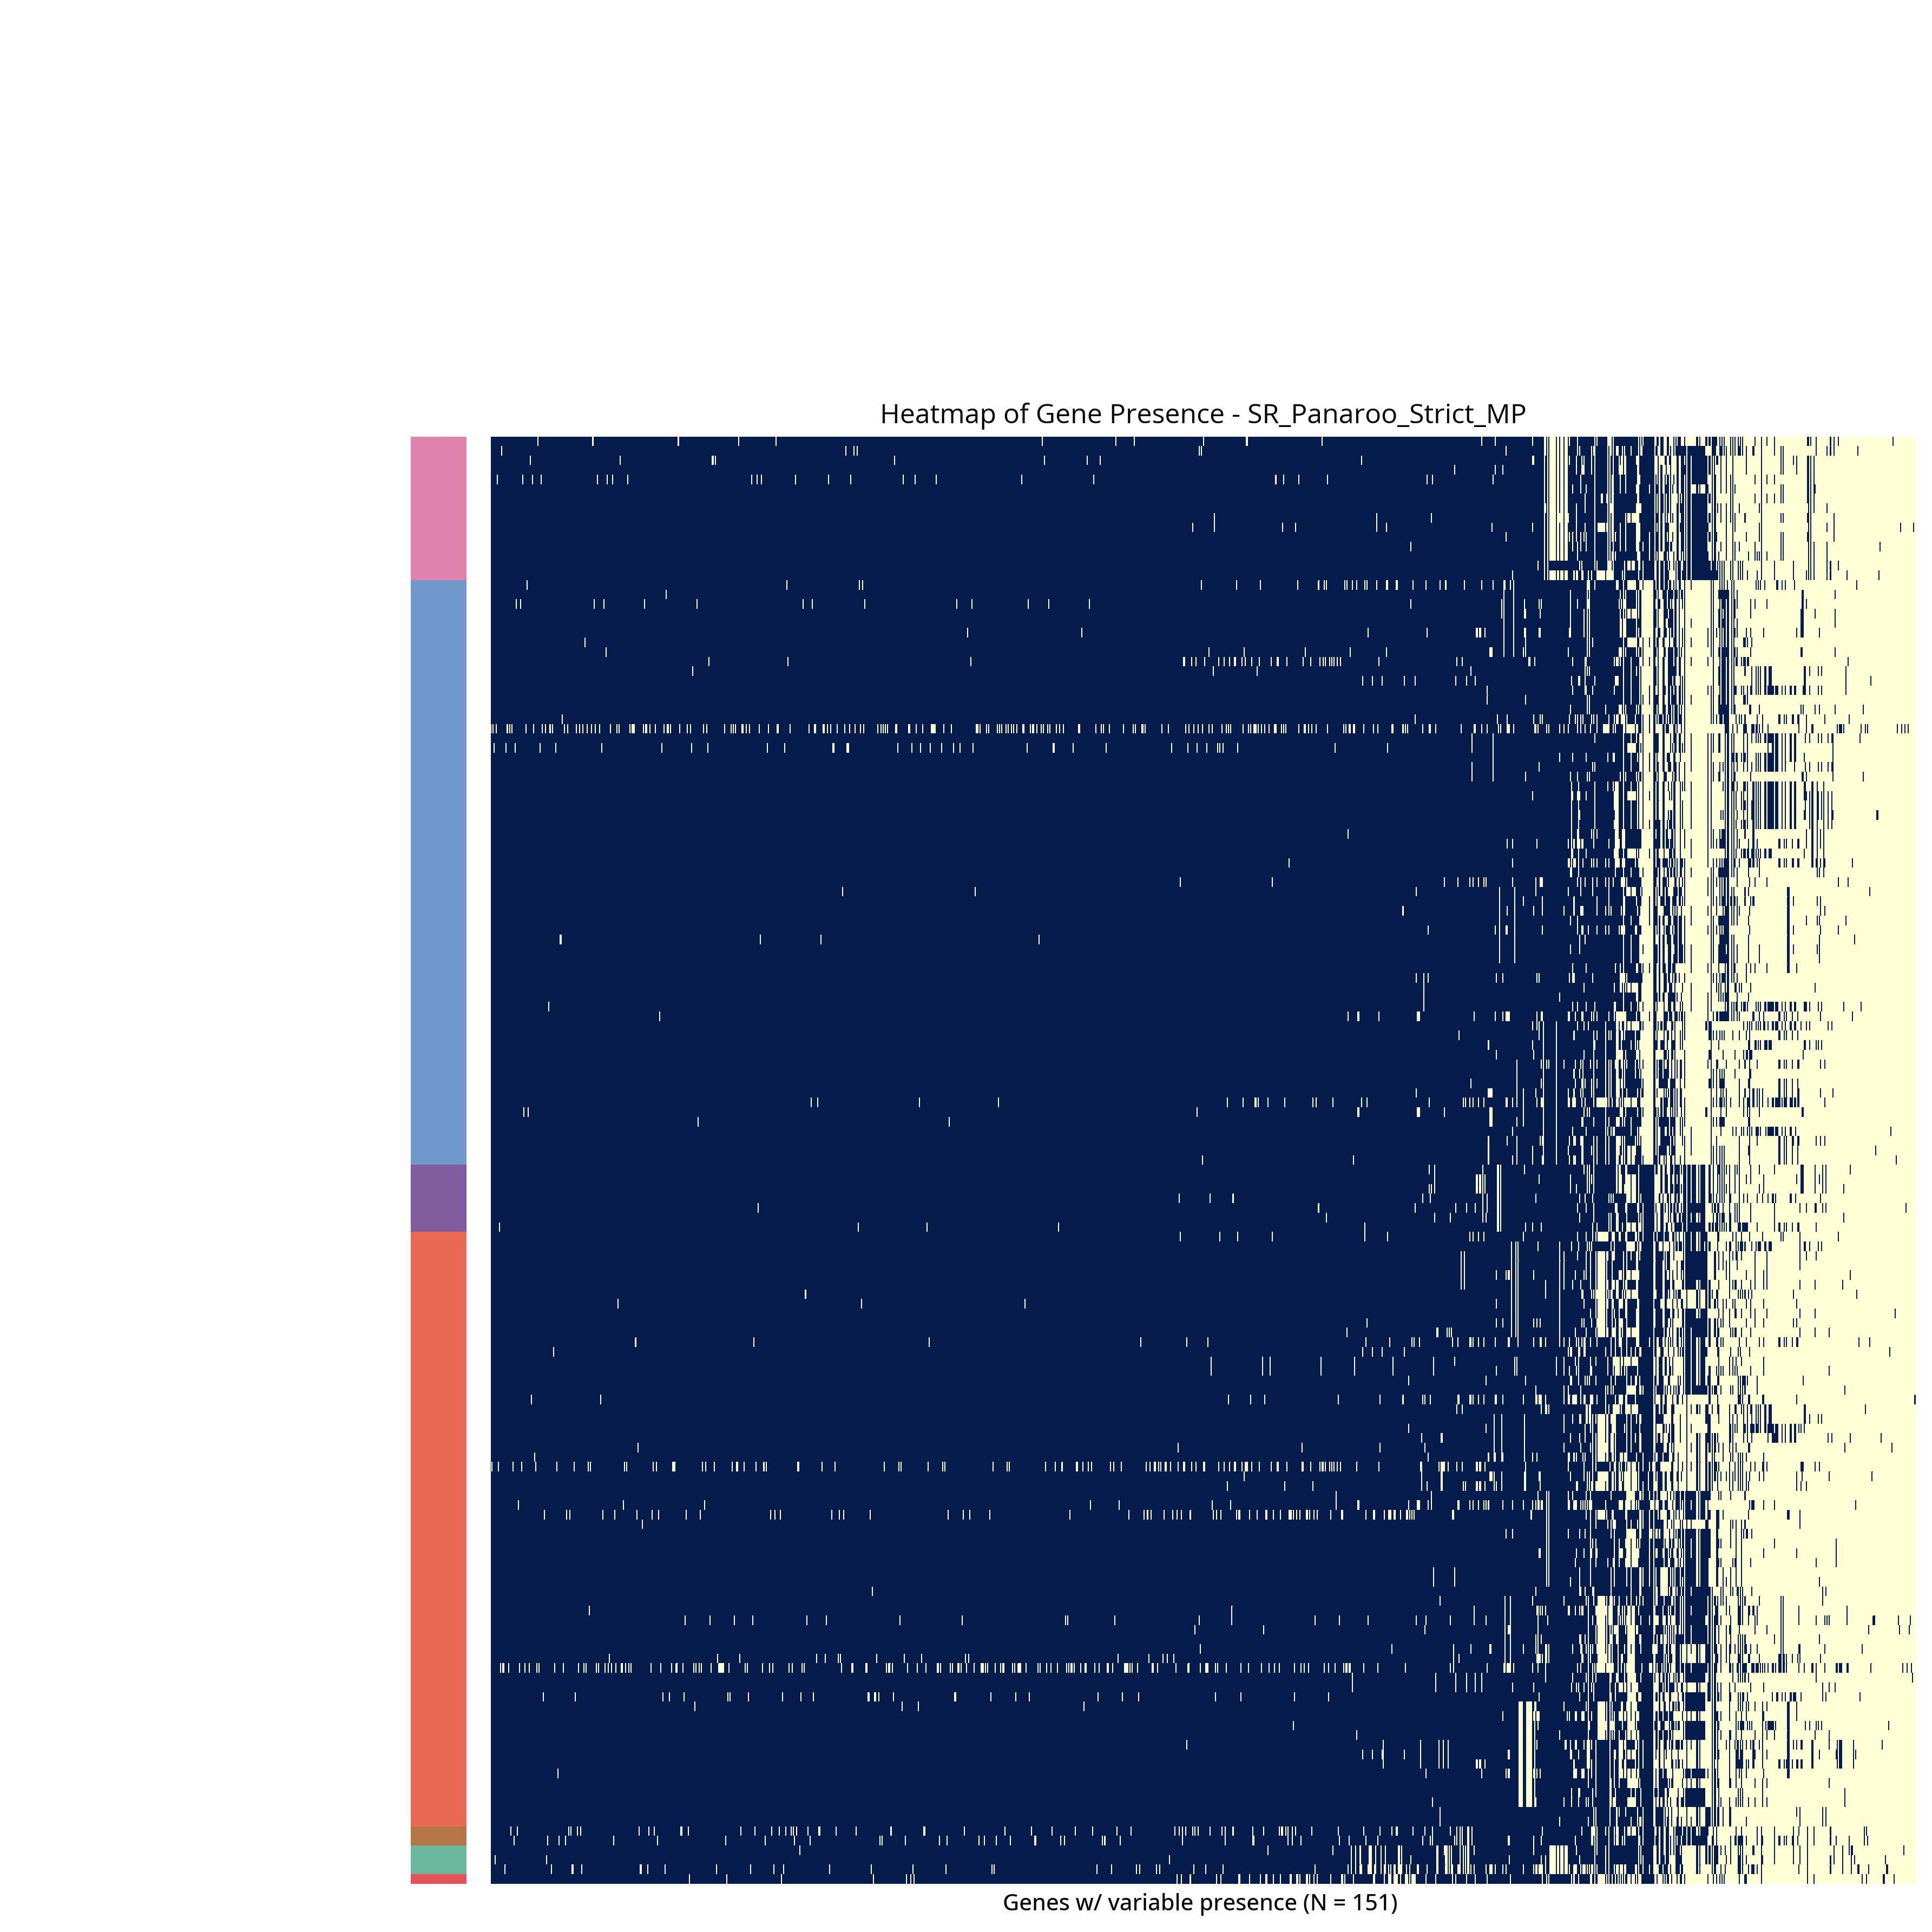

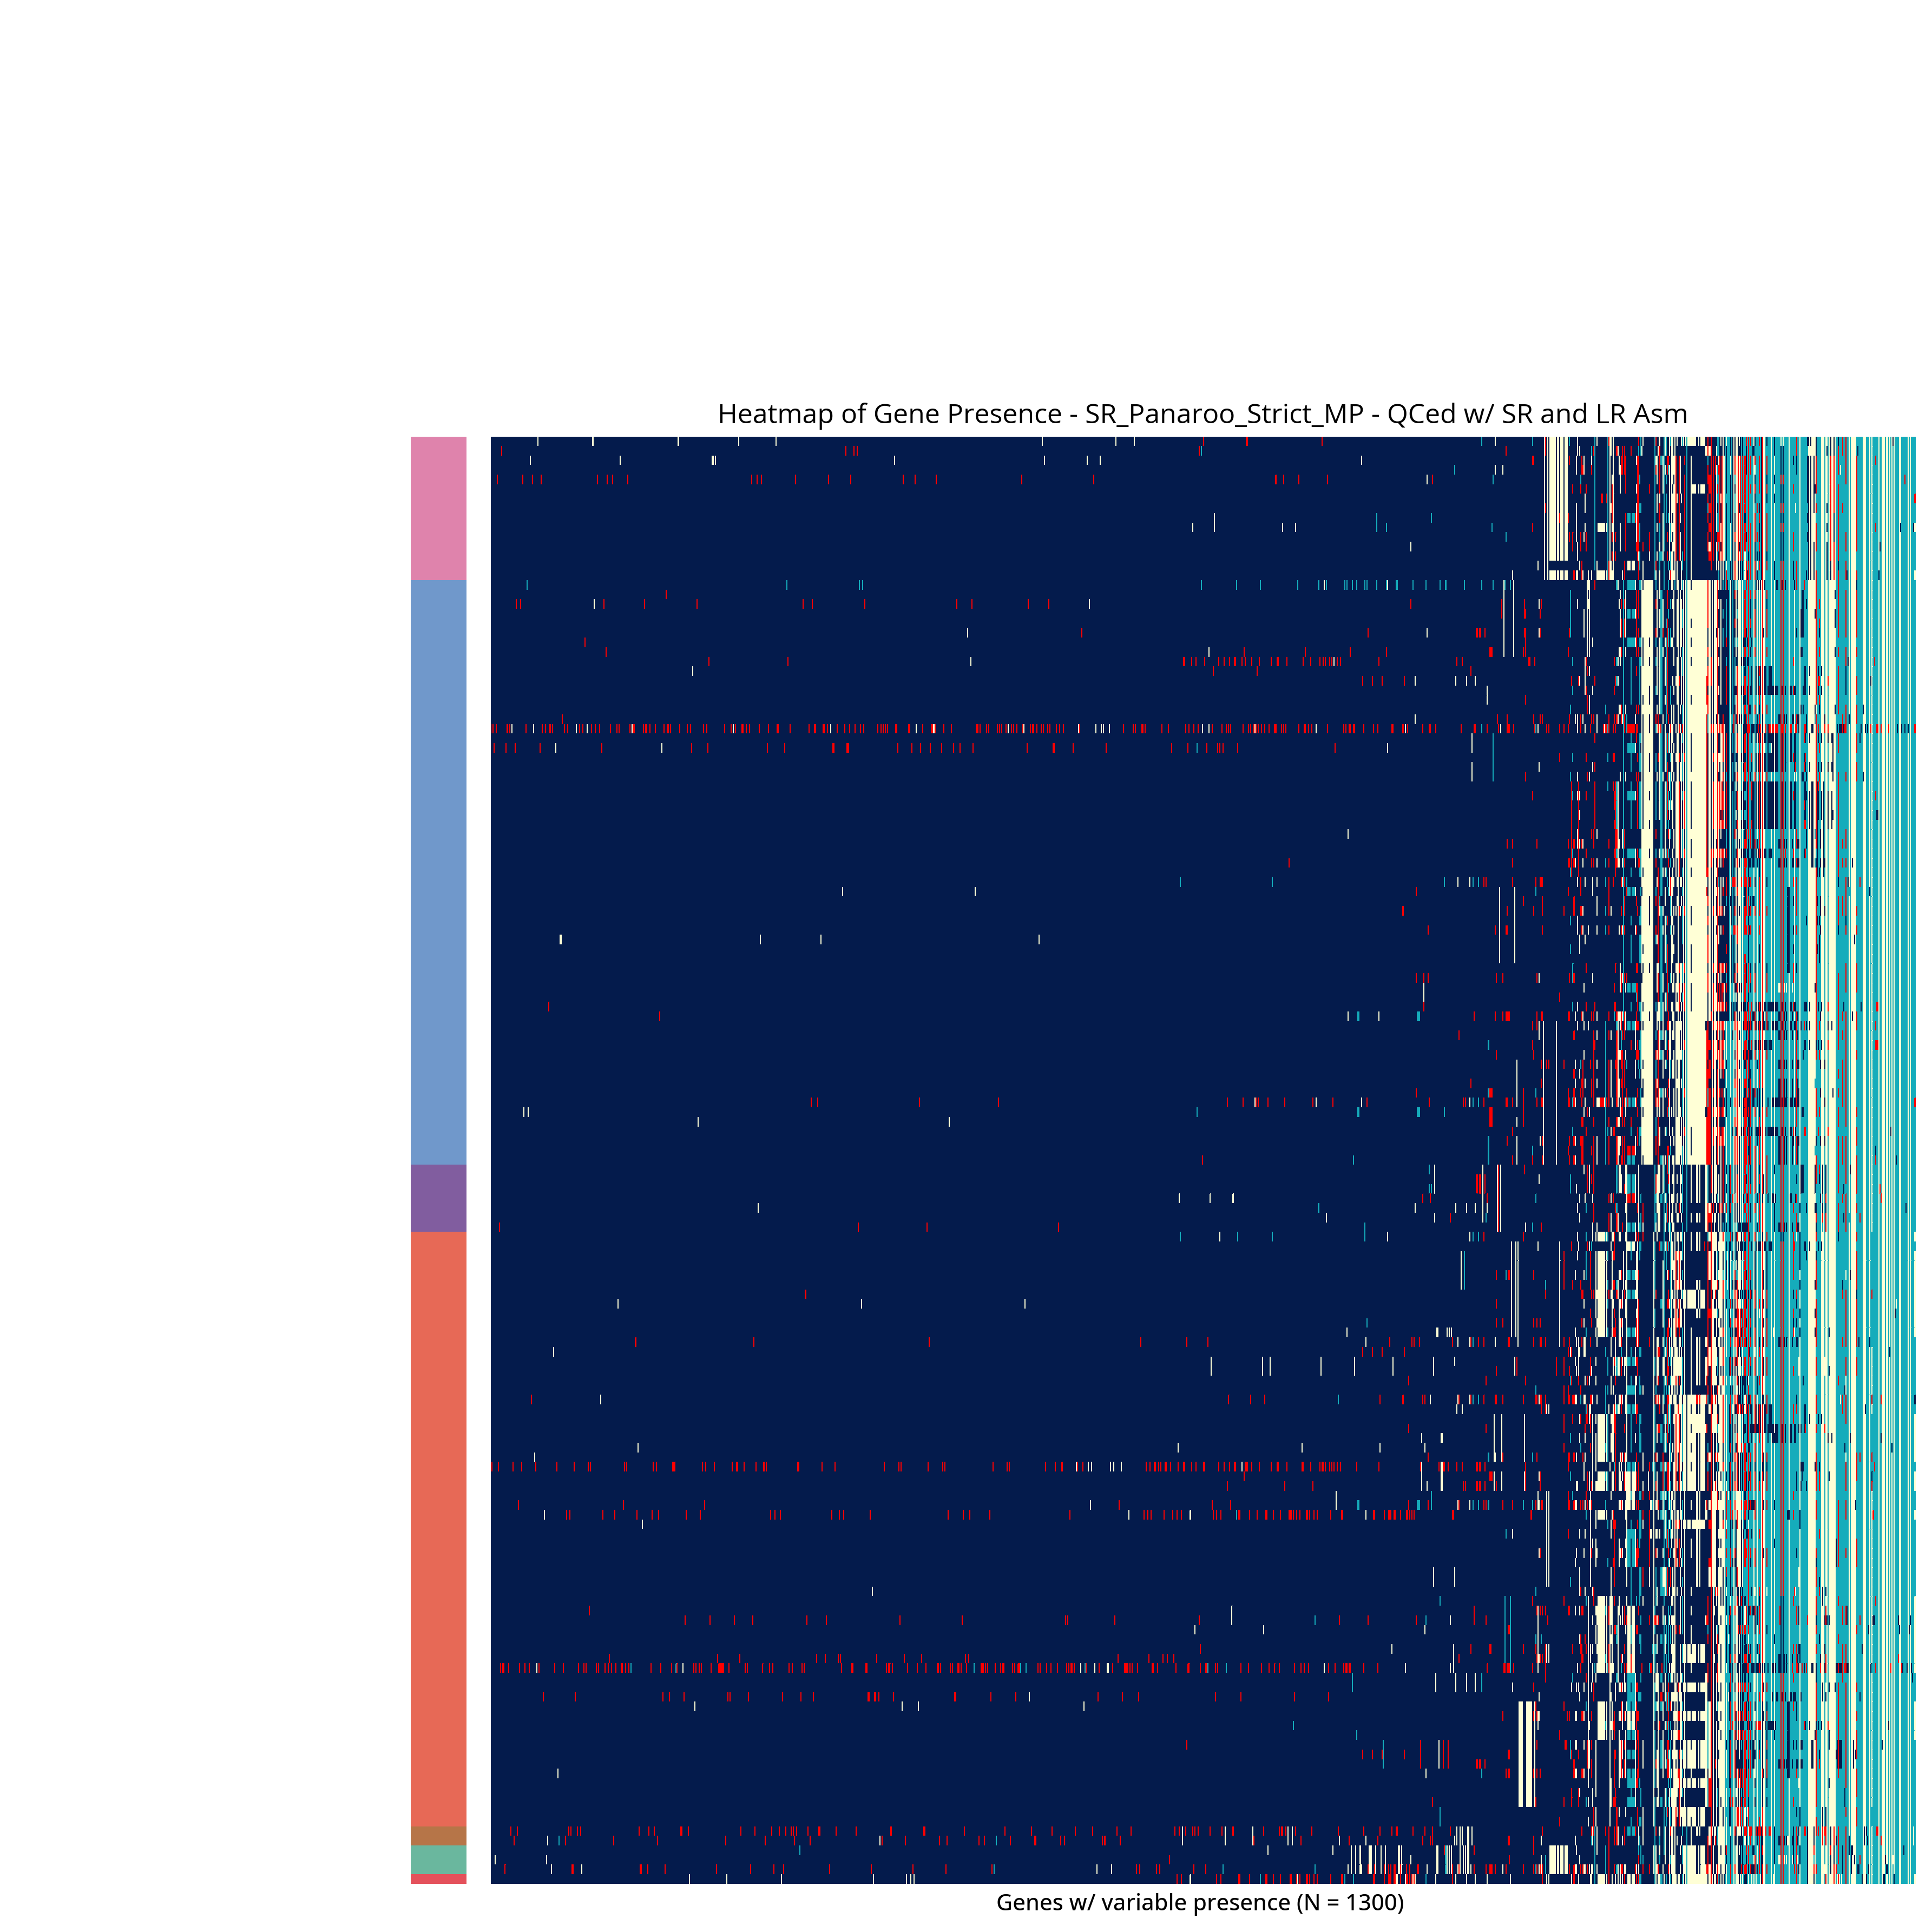

SR_Panaroo_Moderate_MP
(151, 1447)


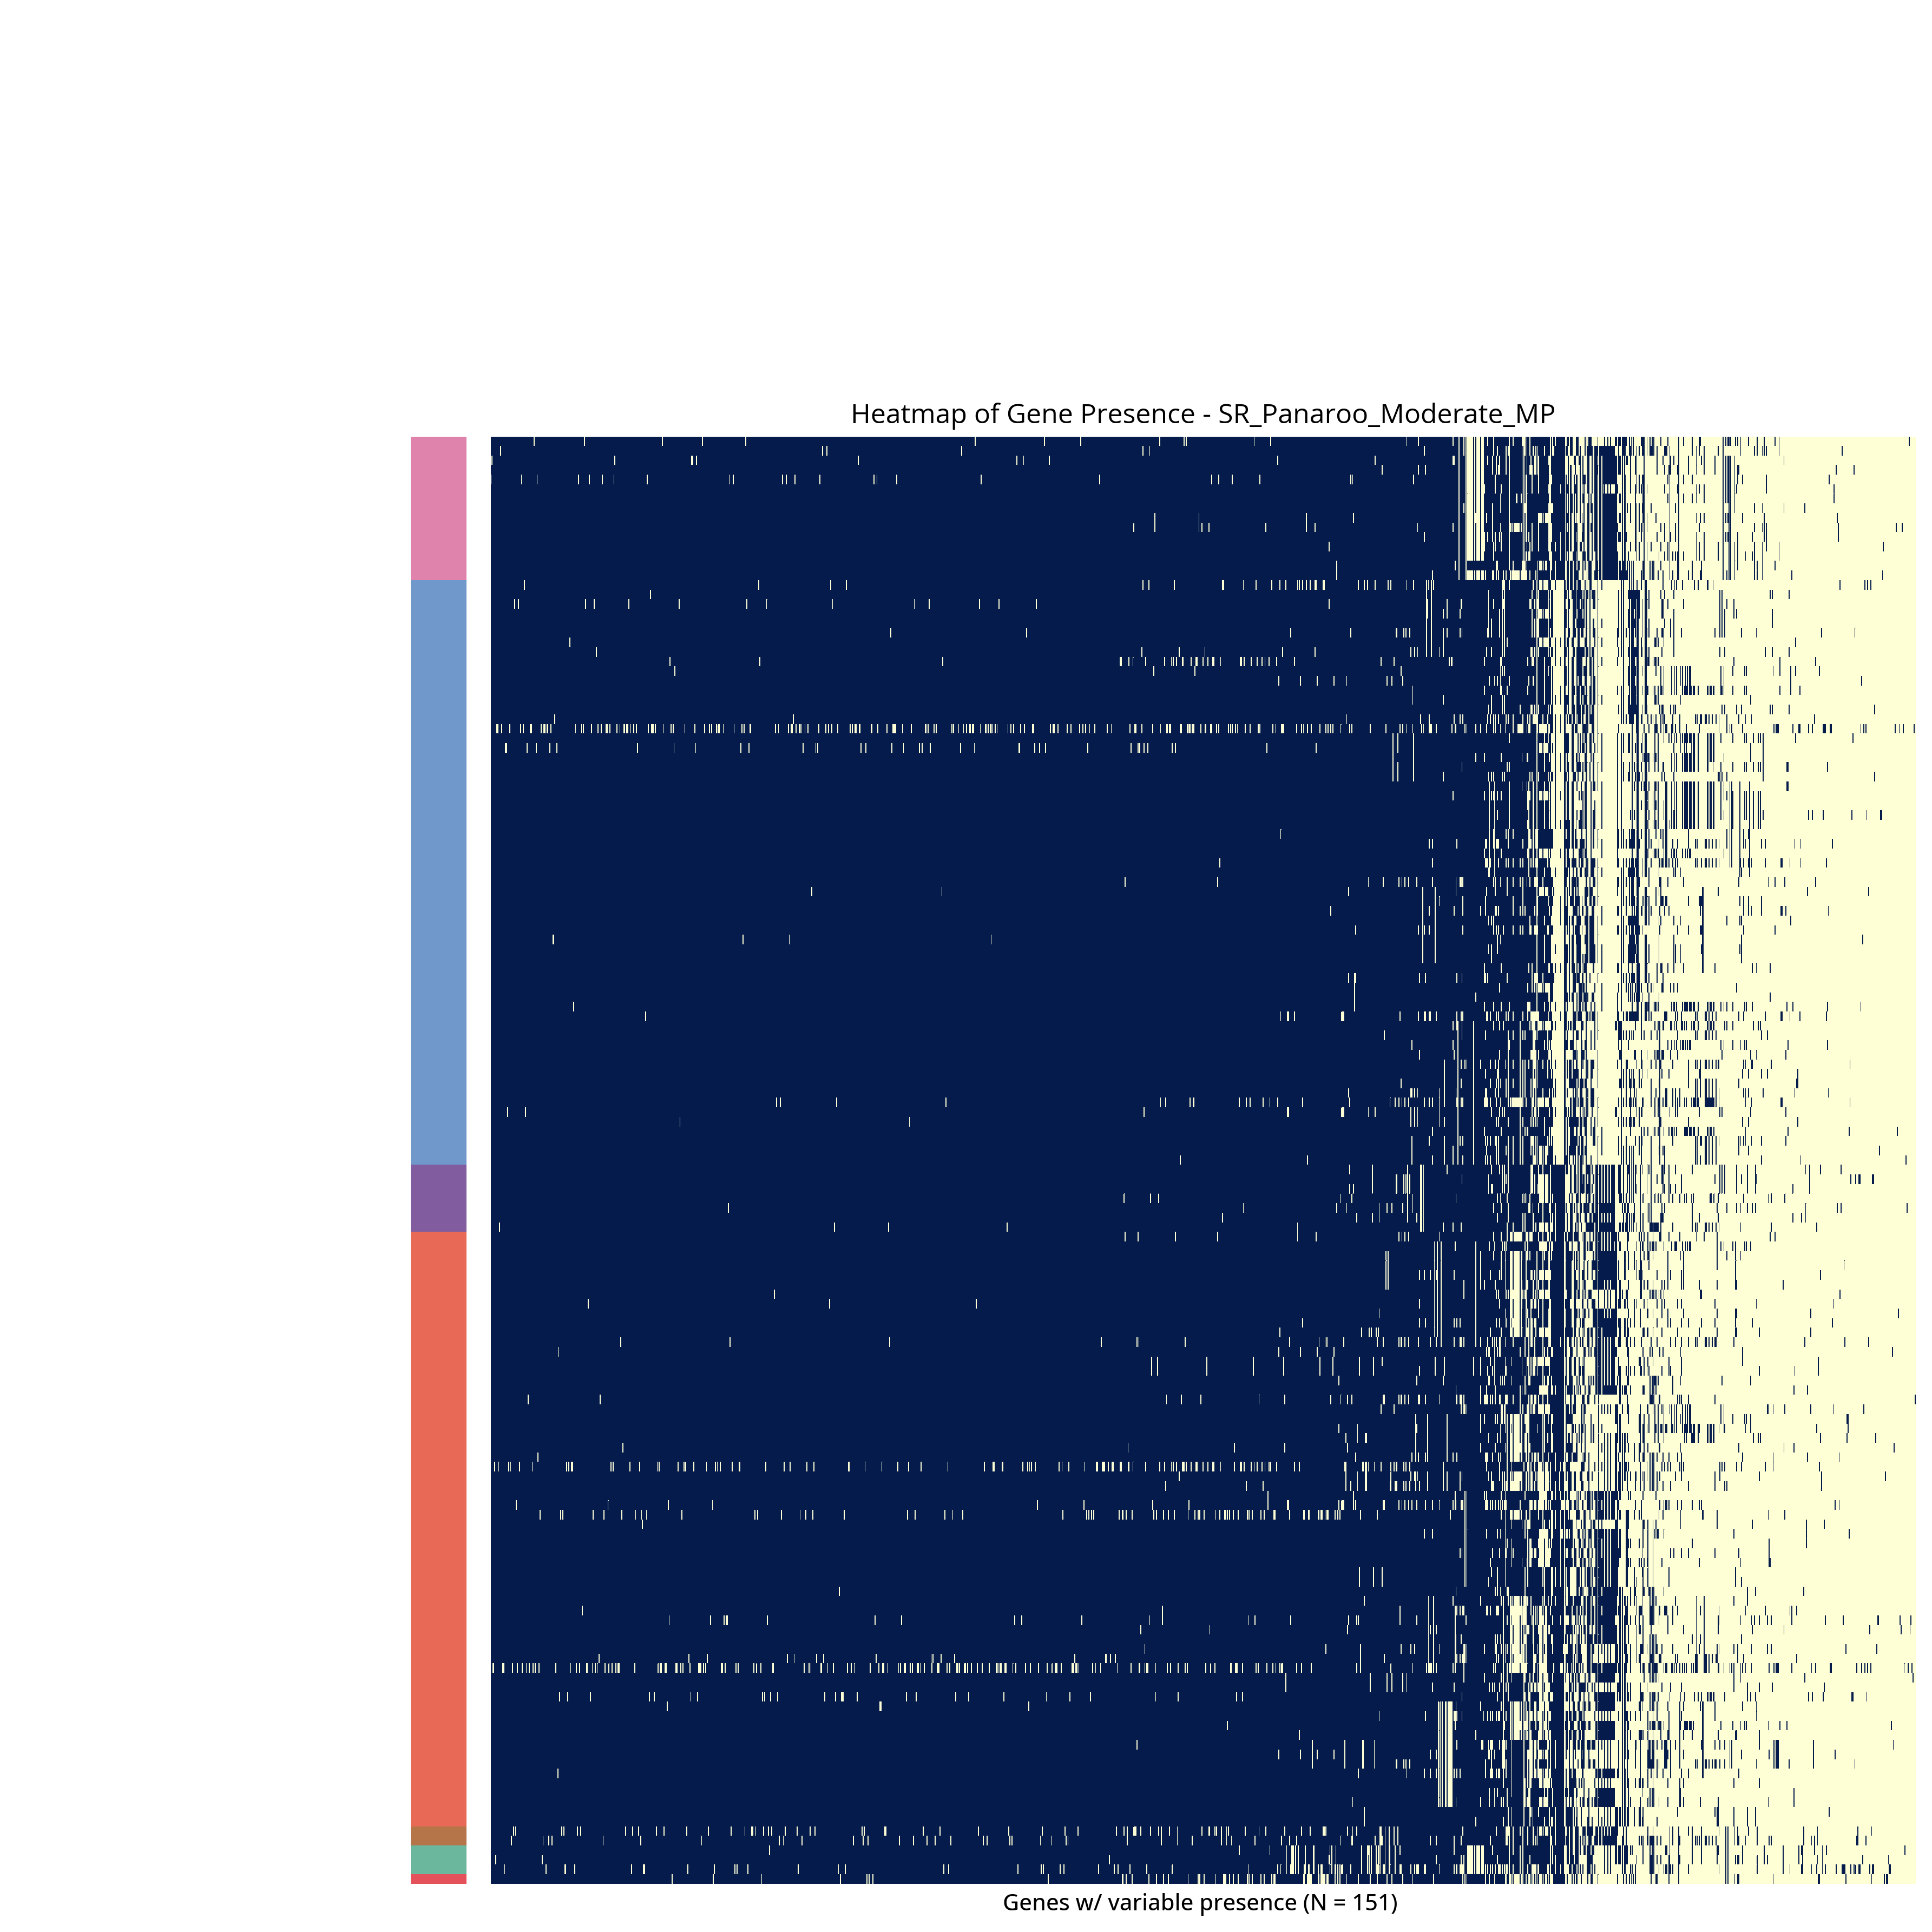

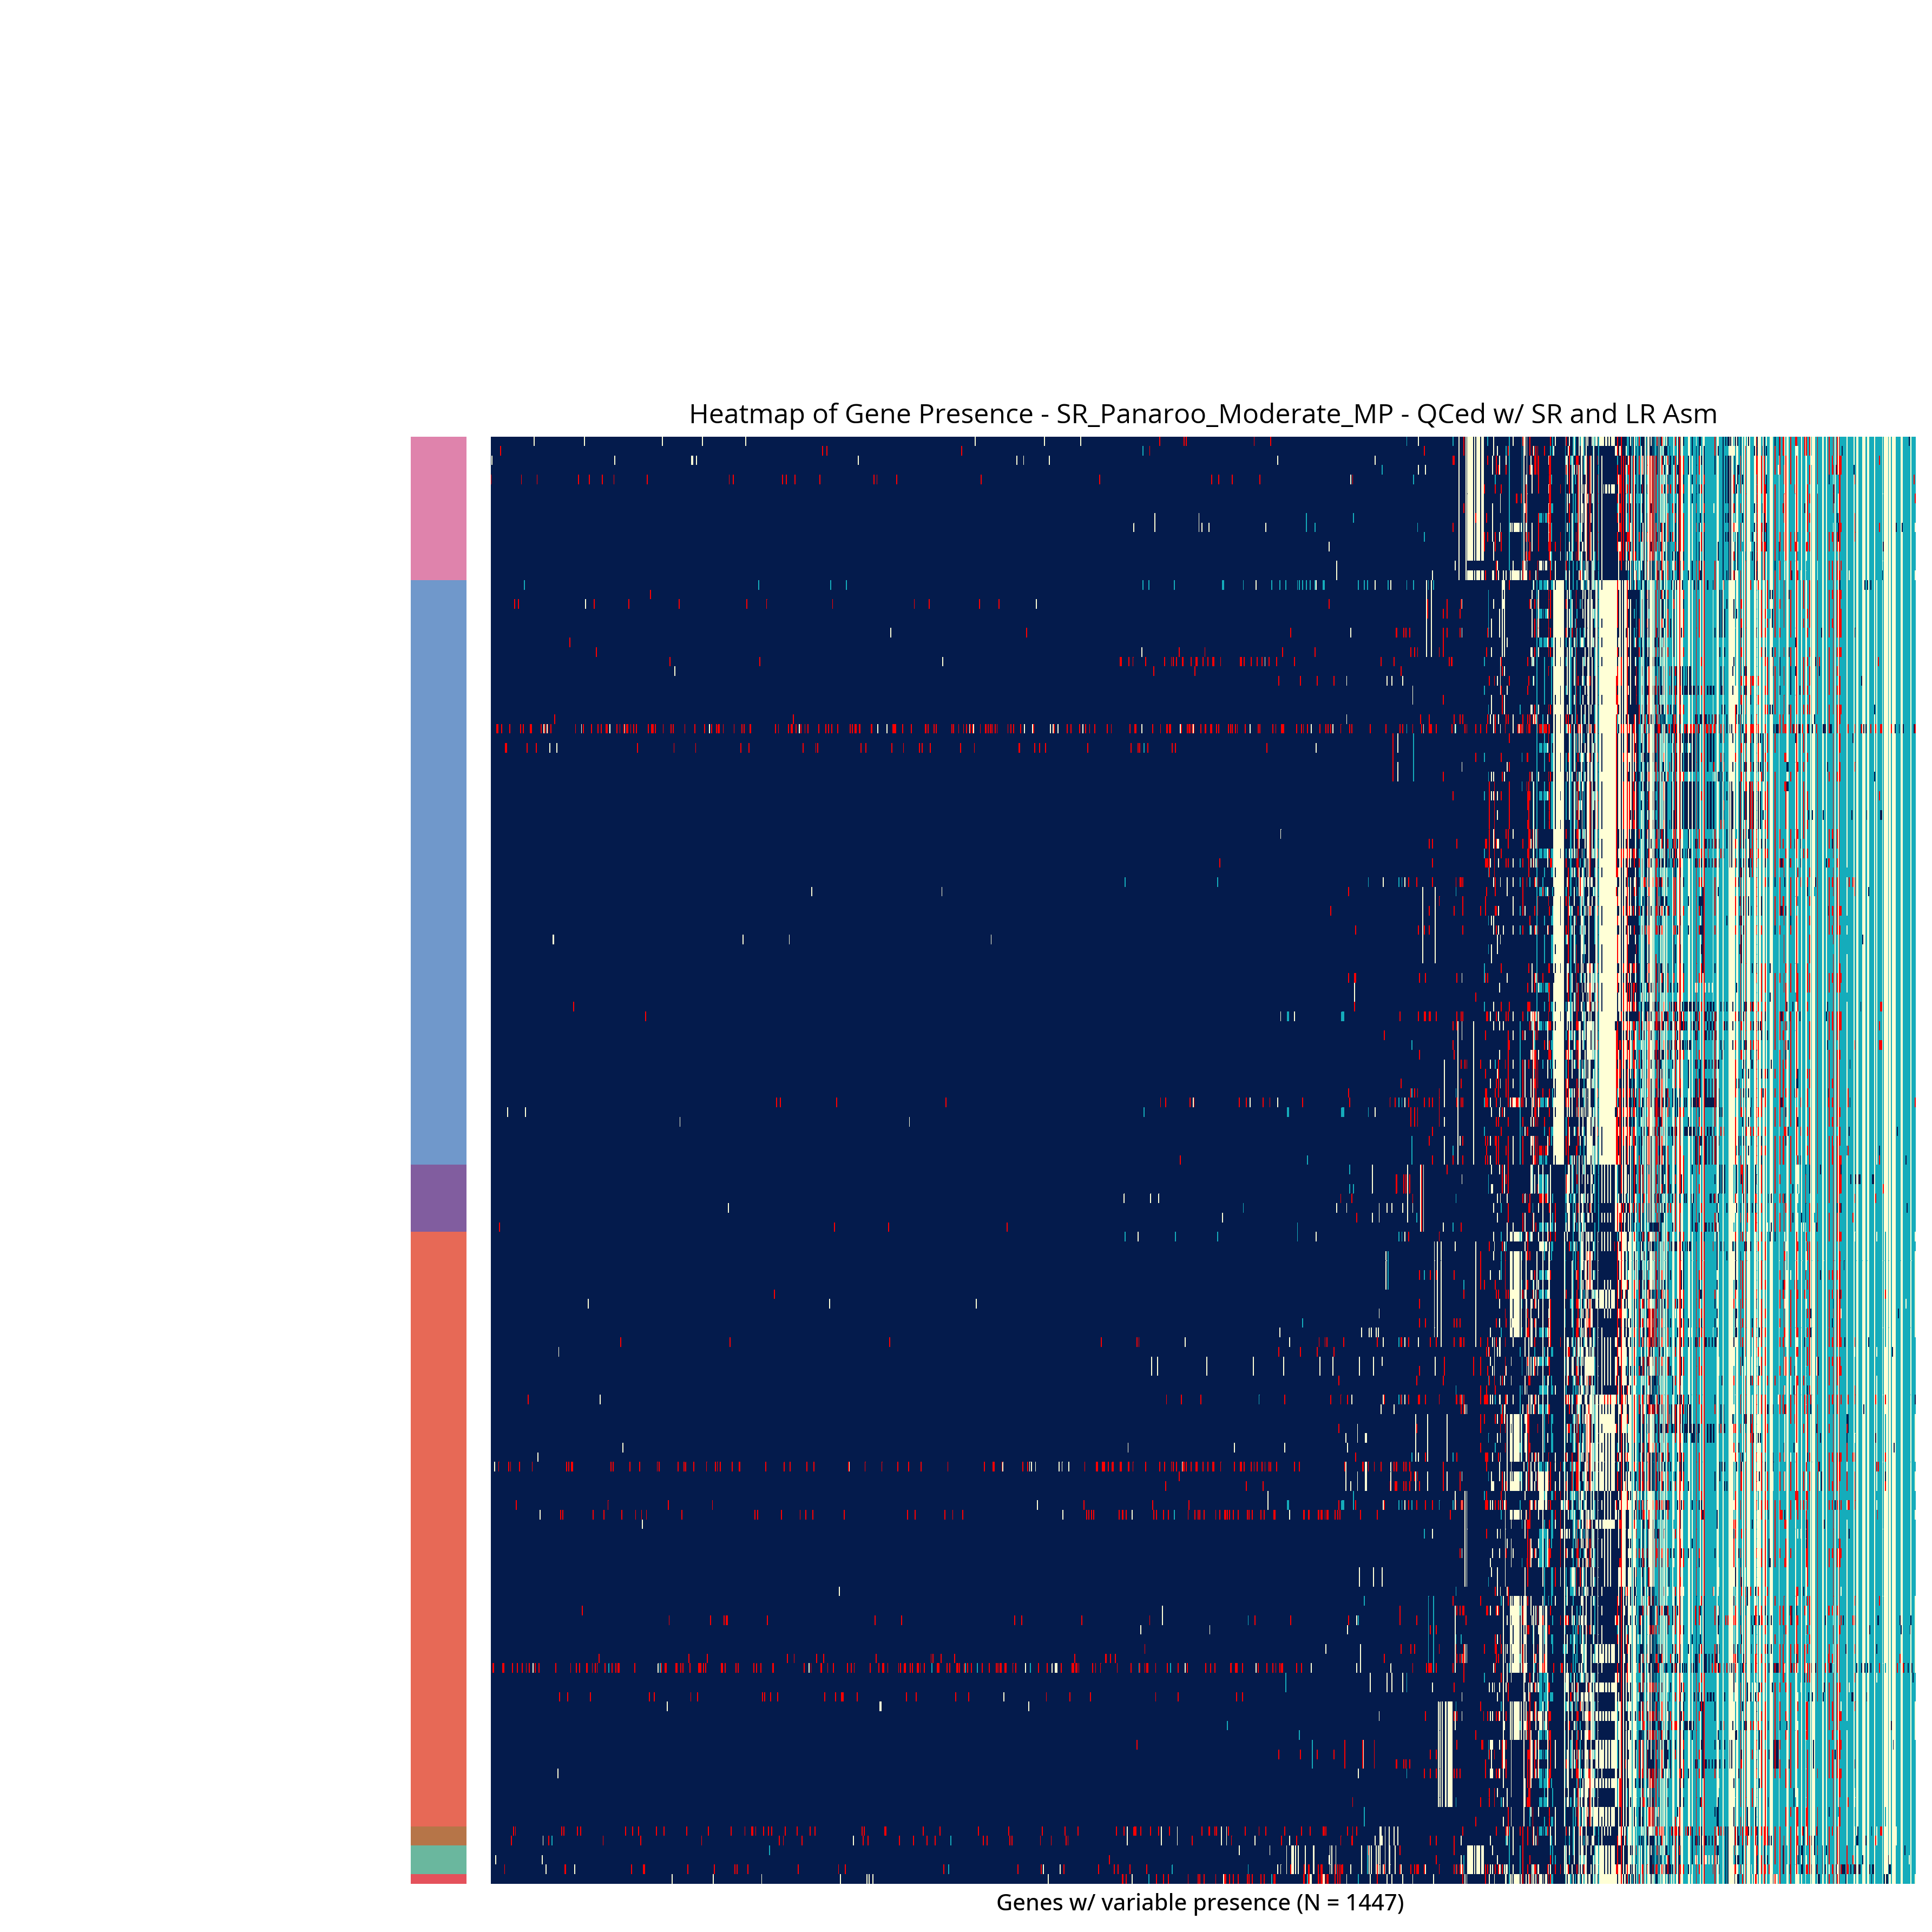

SR_Panaroo_Sens_MP
(151, 1664)


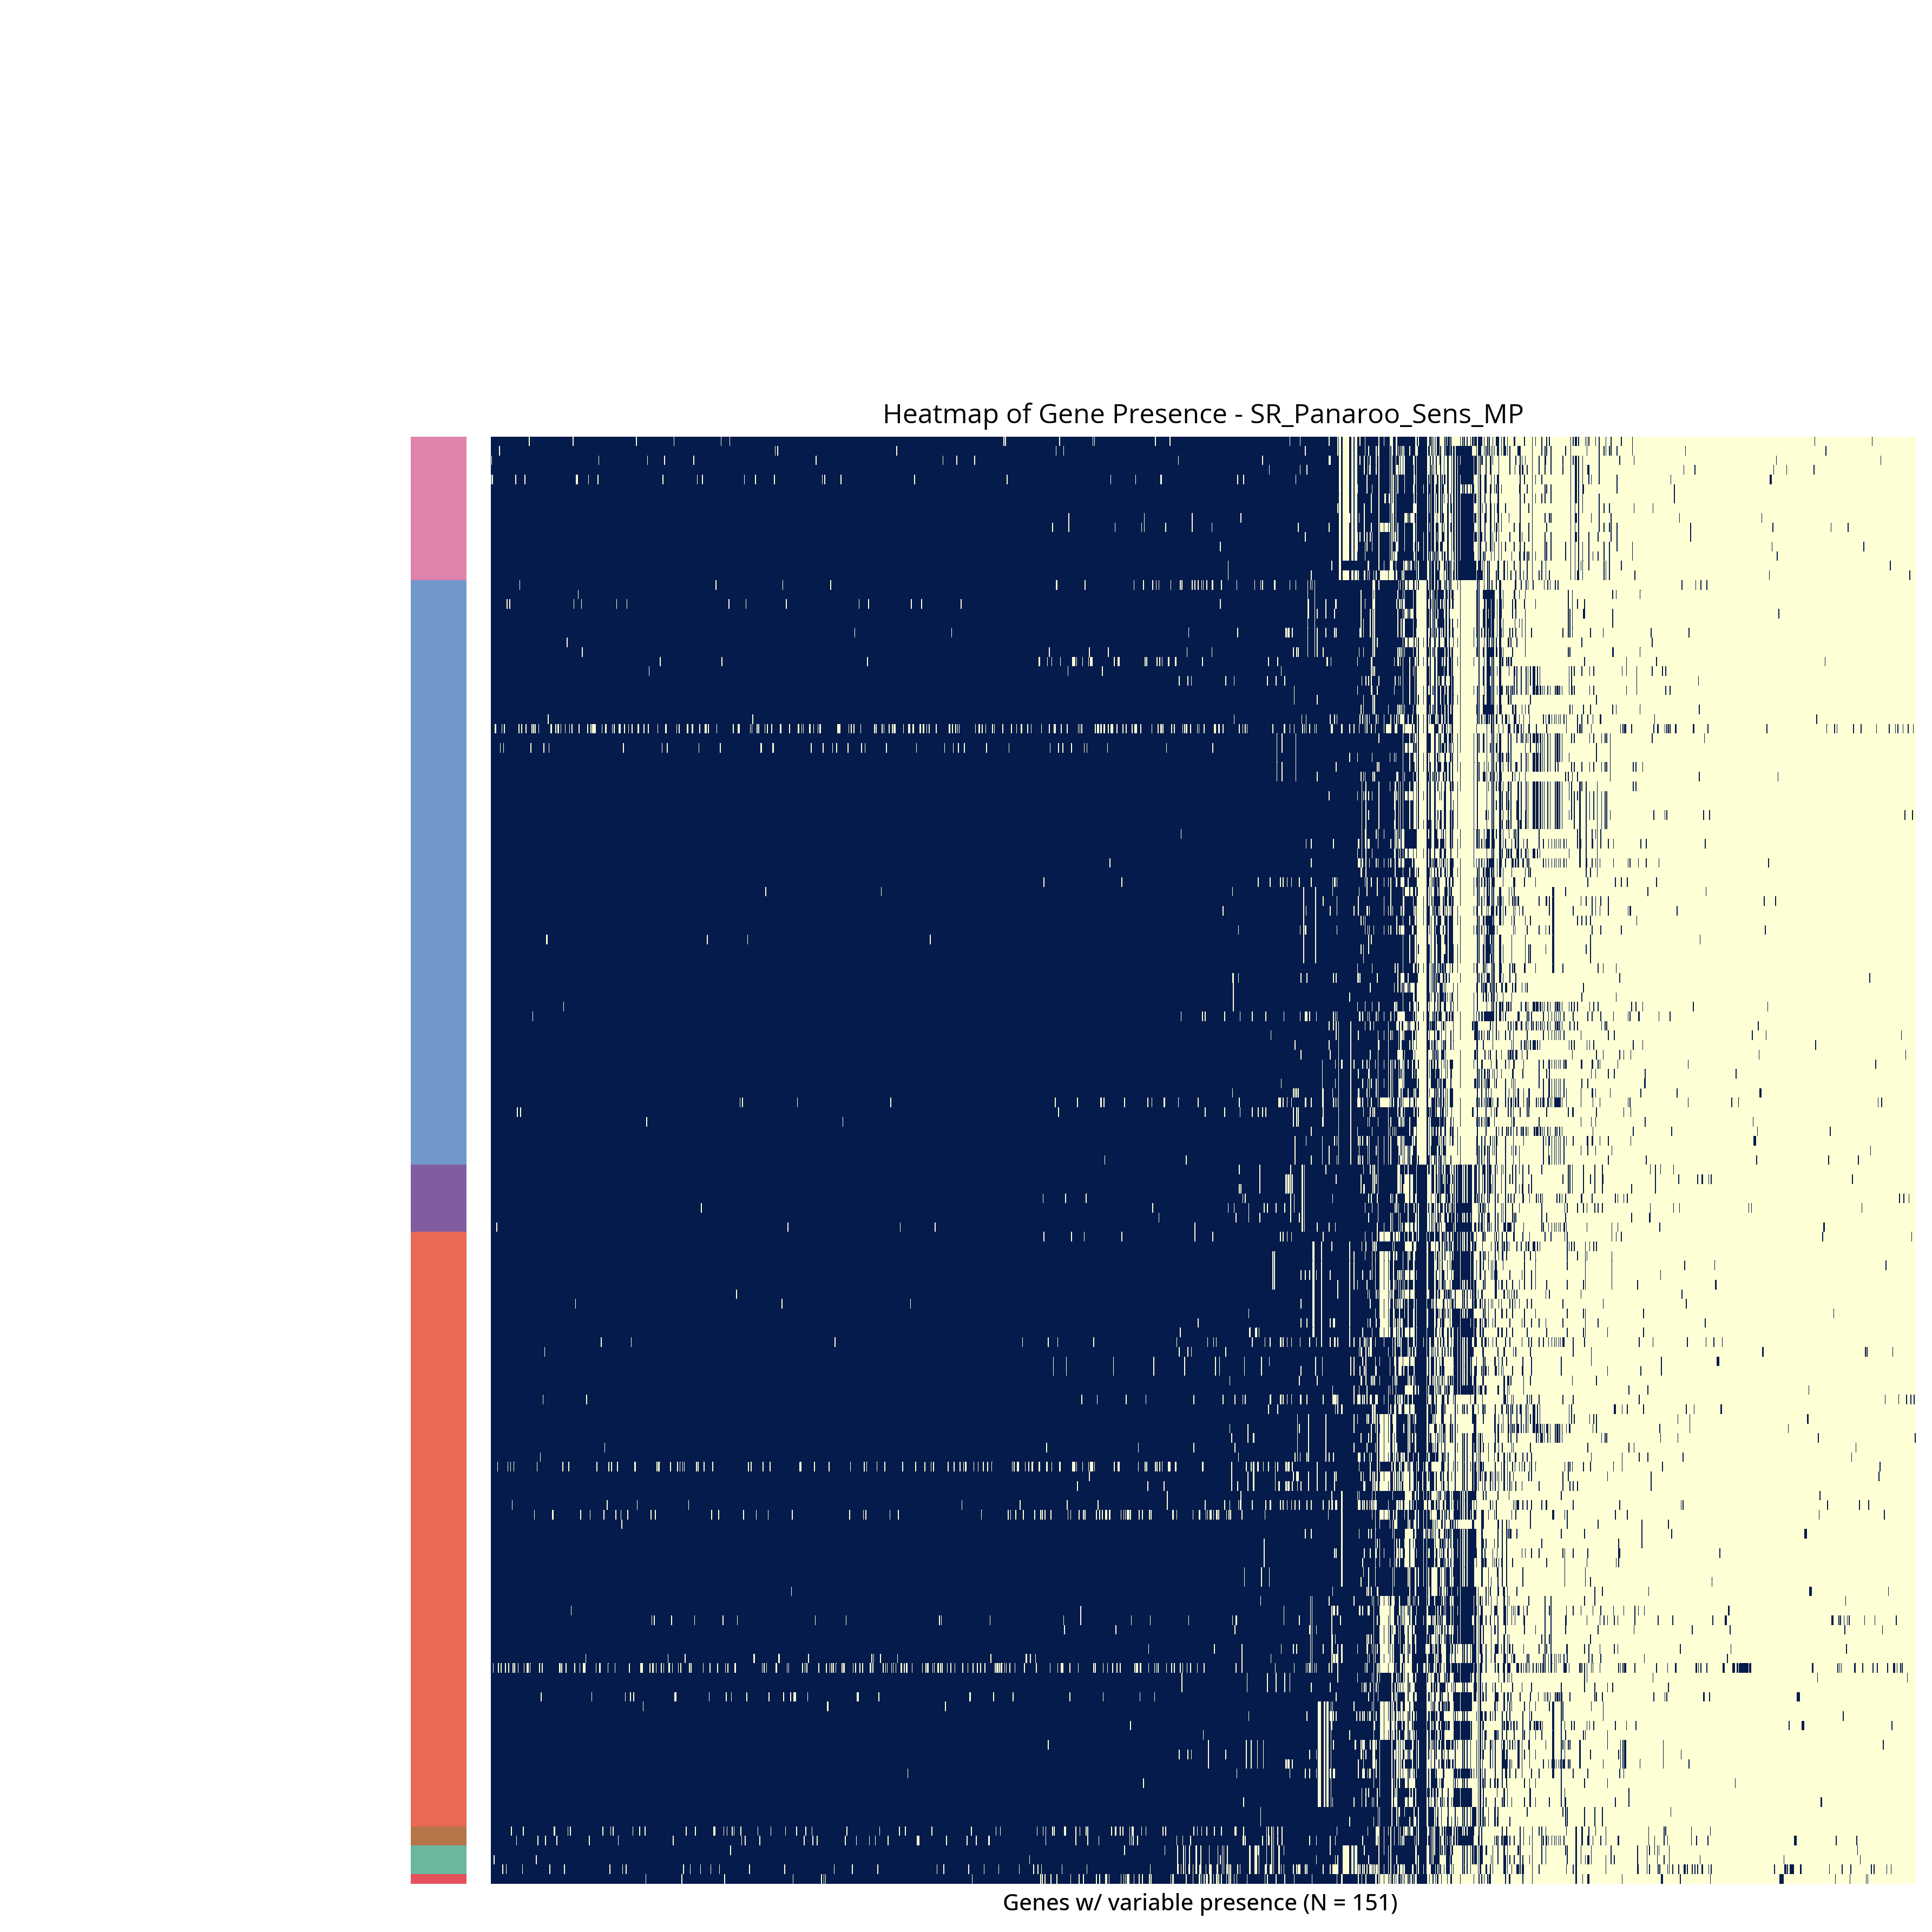

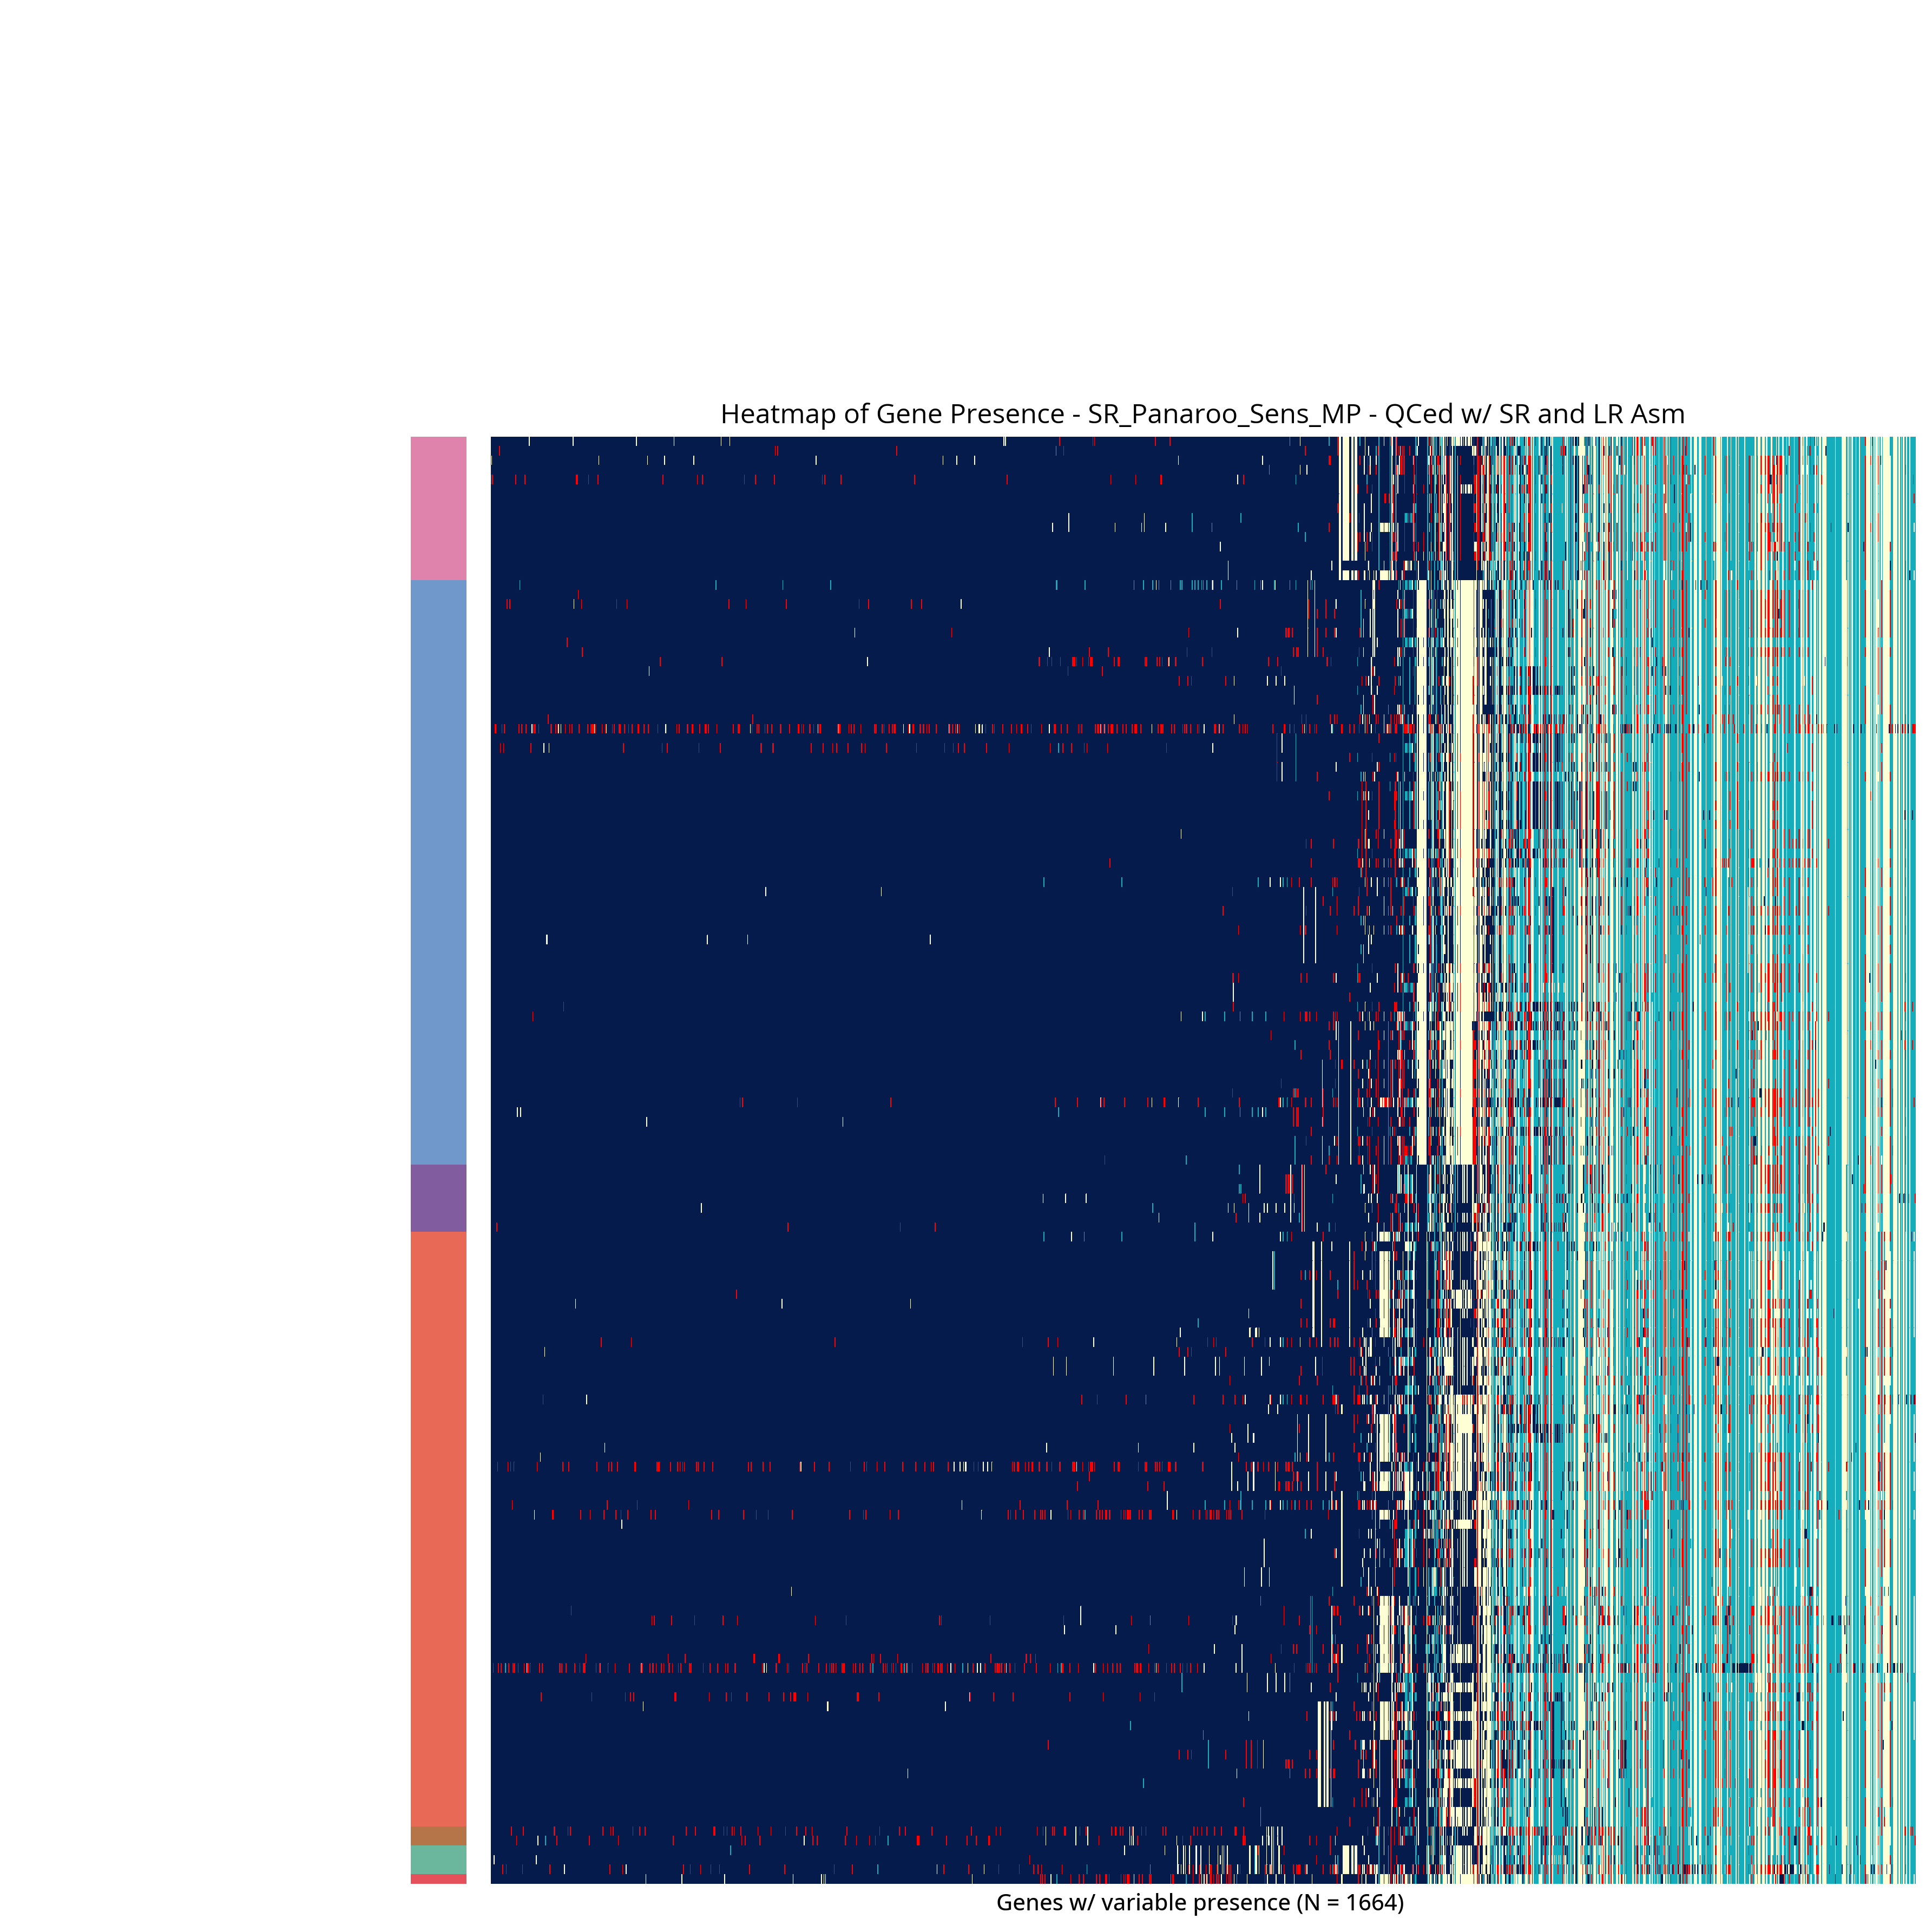

SR_Roary_NoSplitParalogs
(151, 2413)


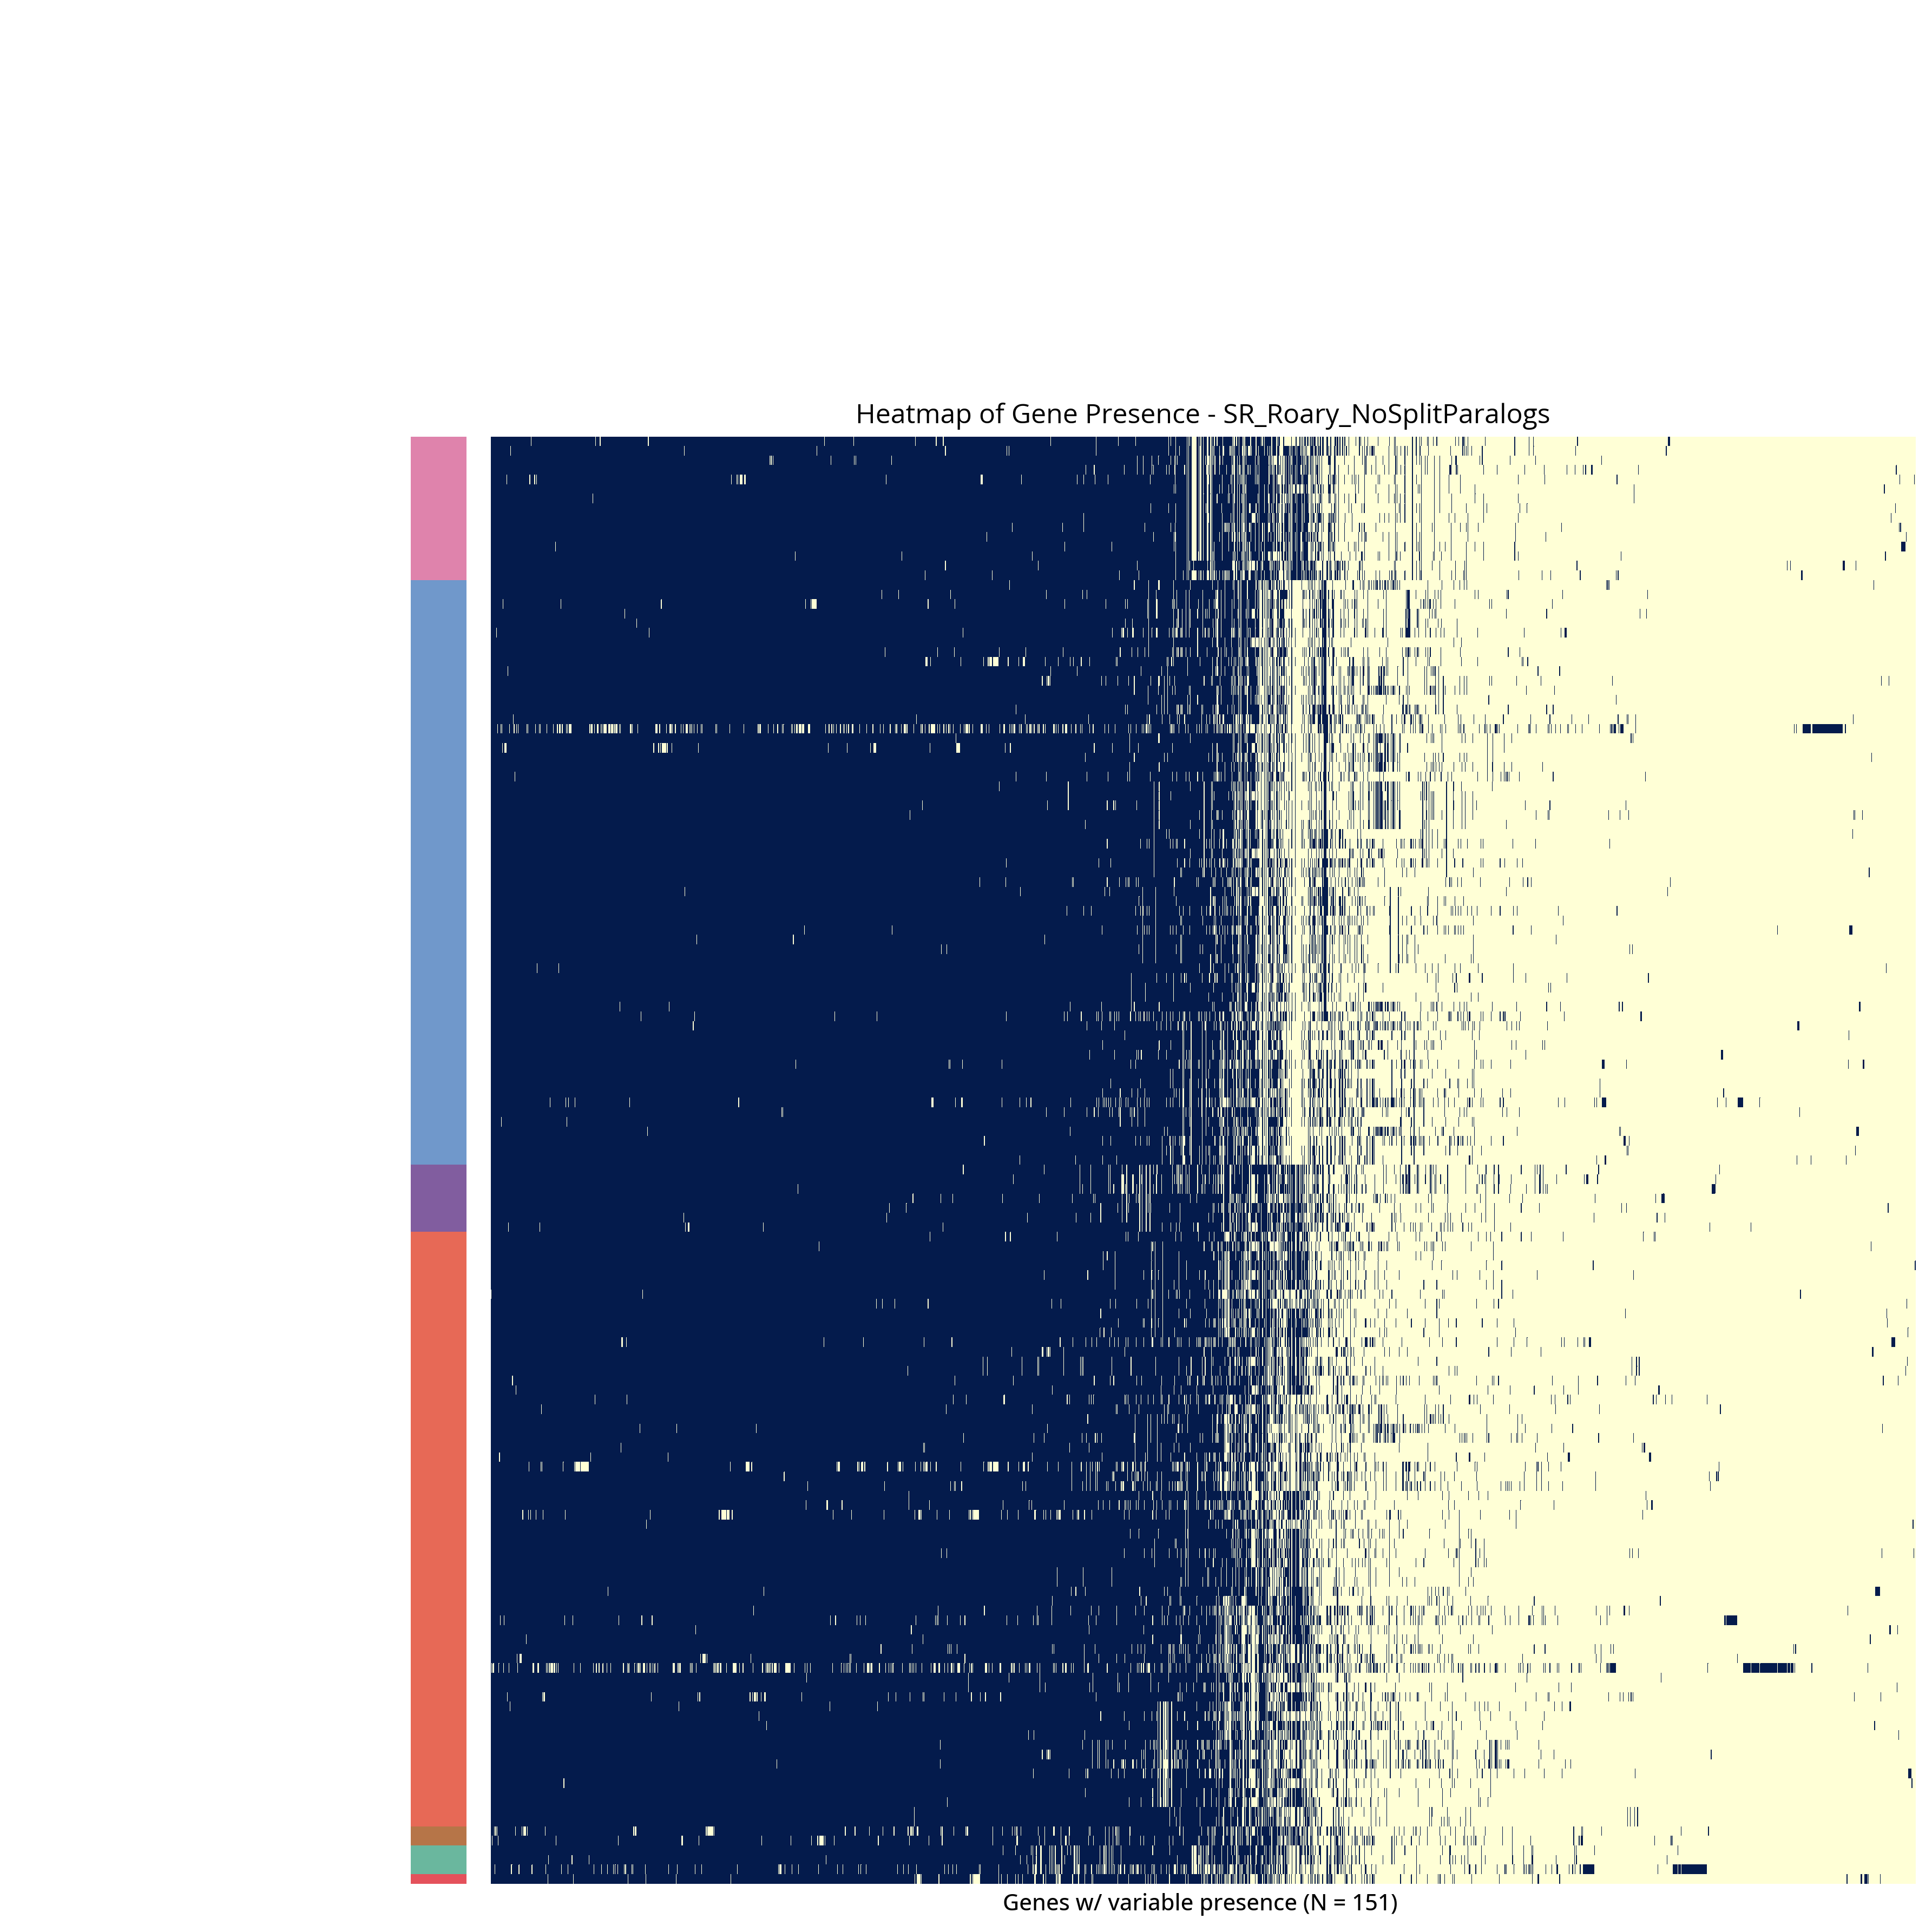

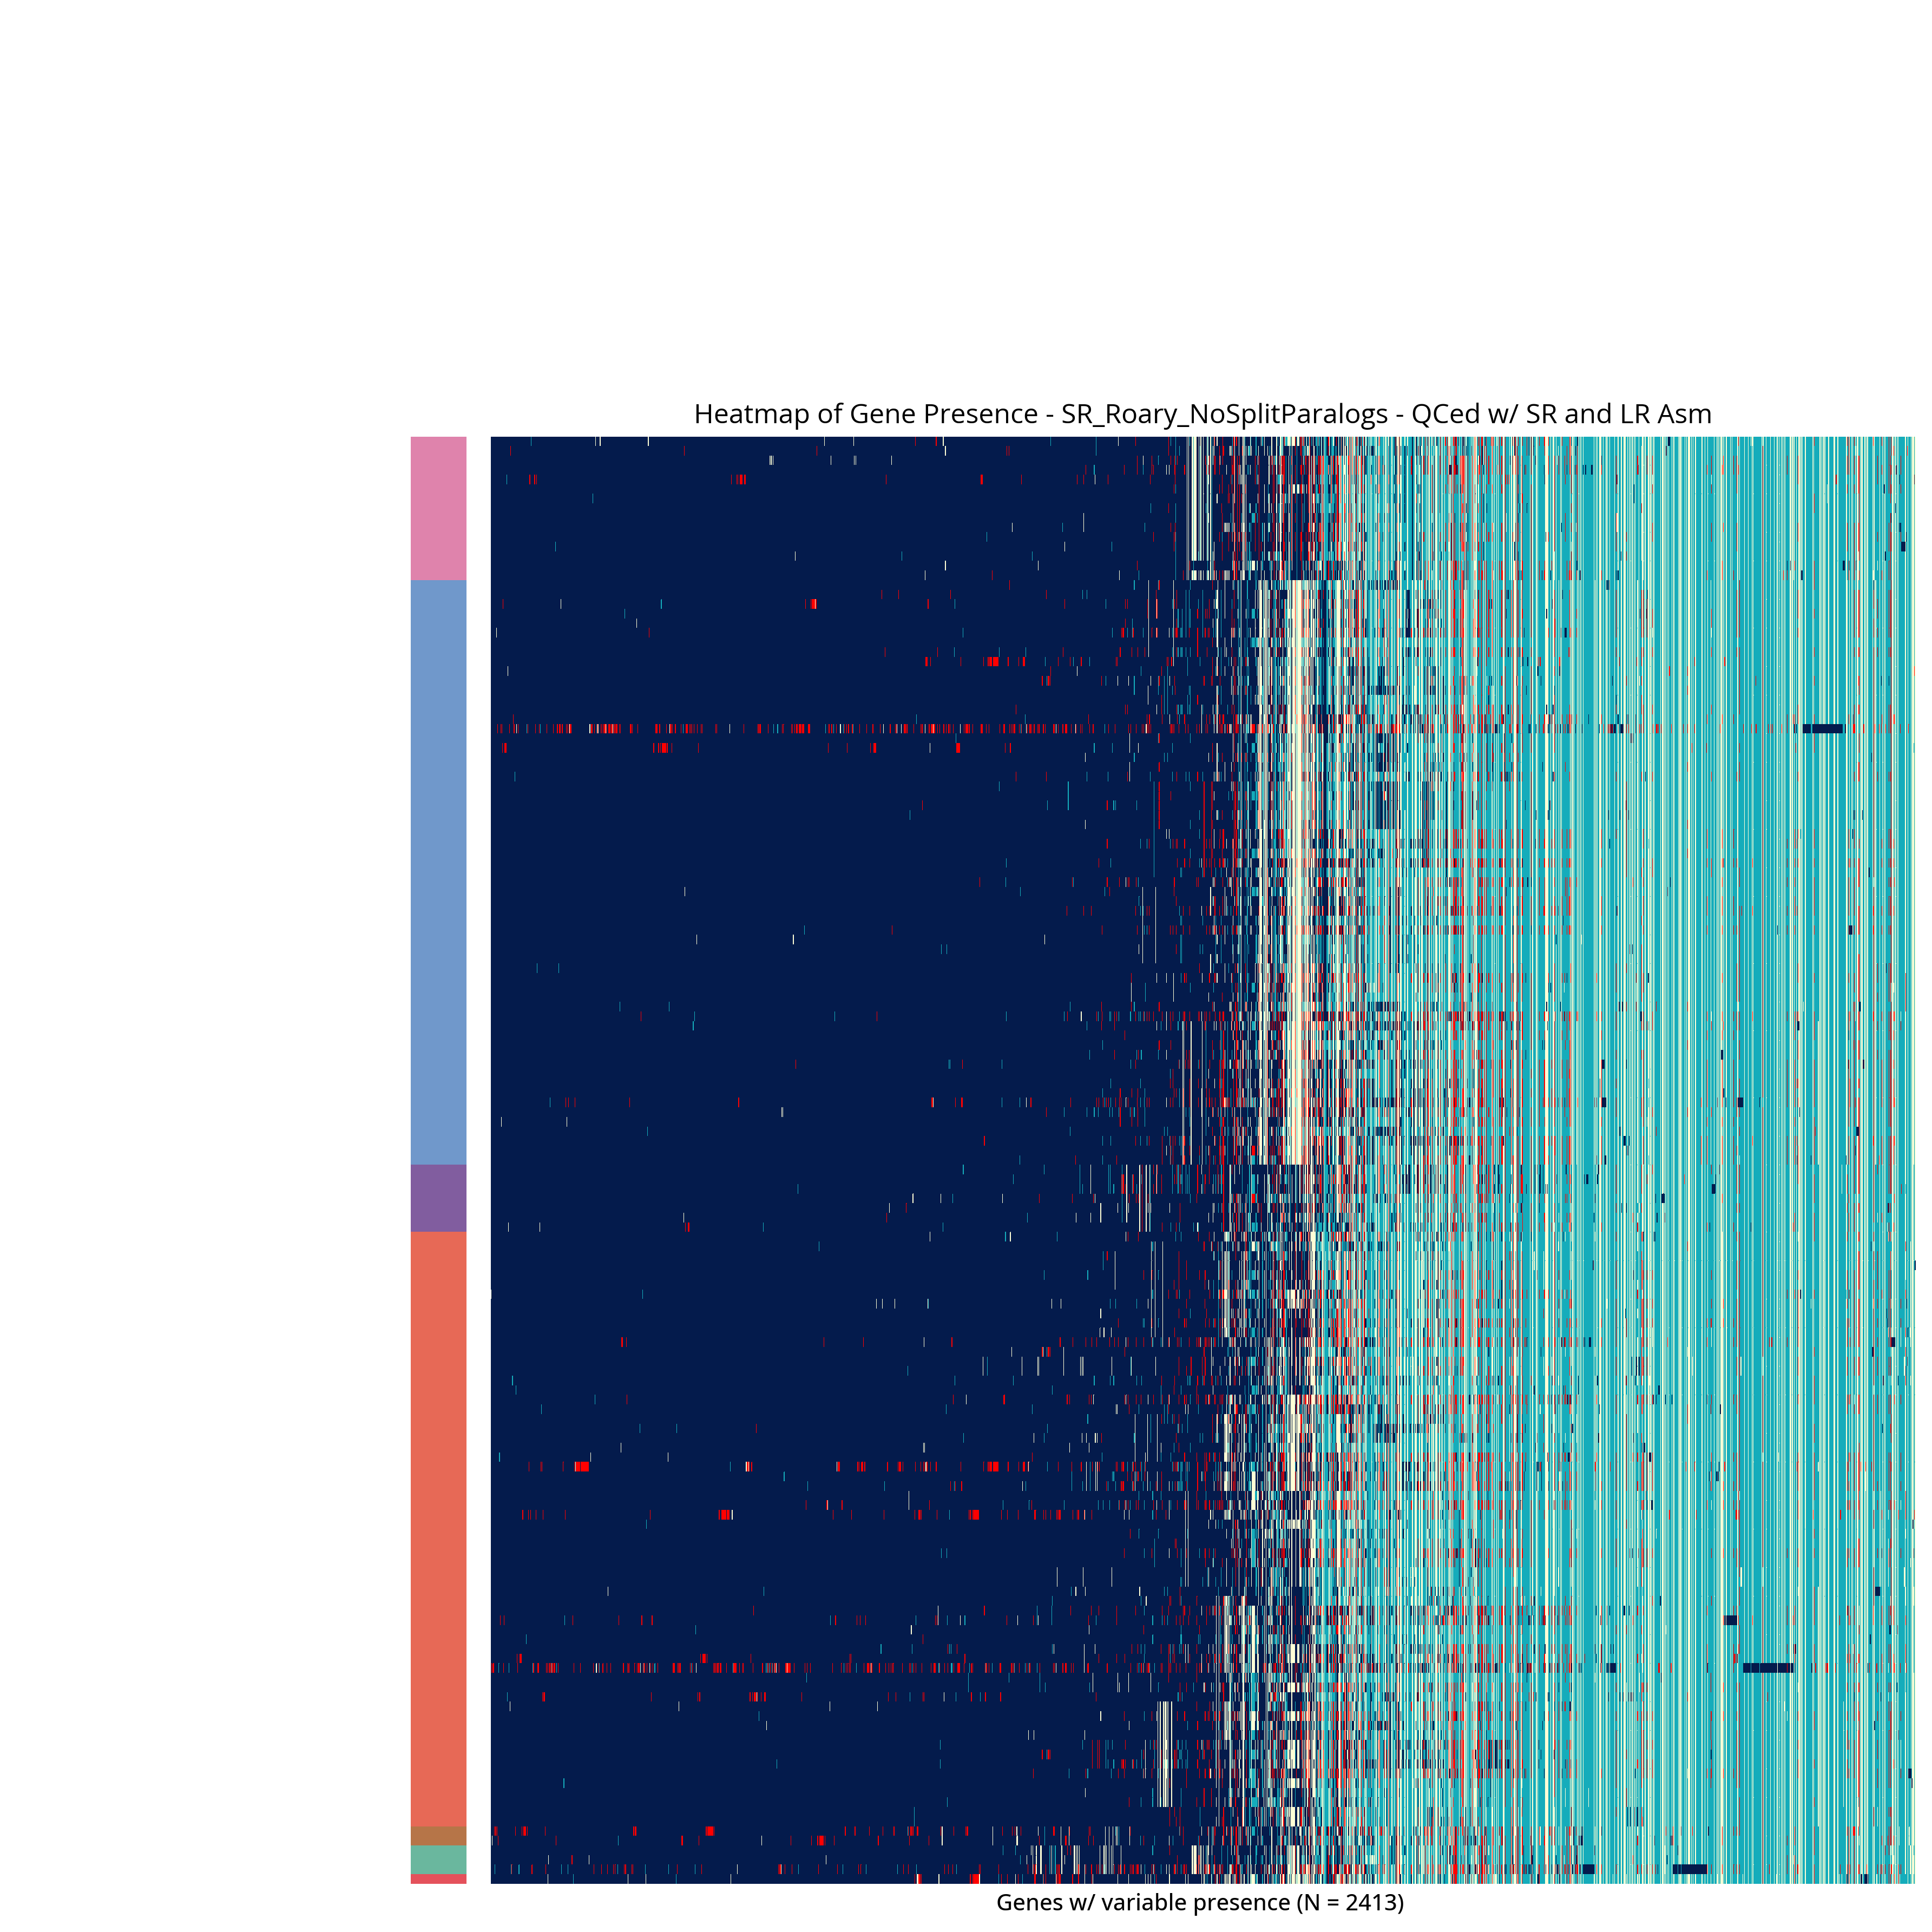

SR_Roary_NoSplitParalogs_I90
(151, 2335)


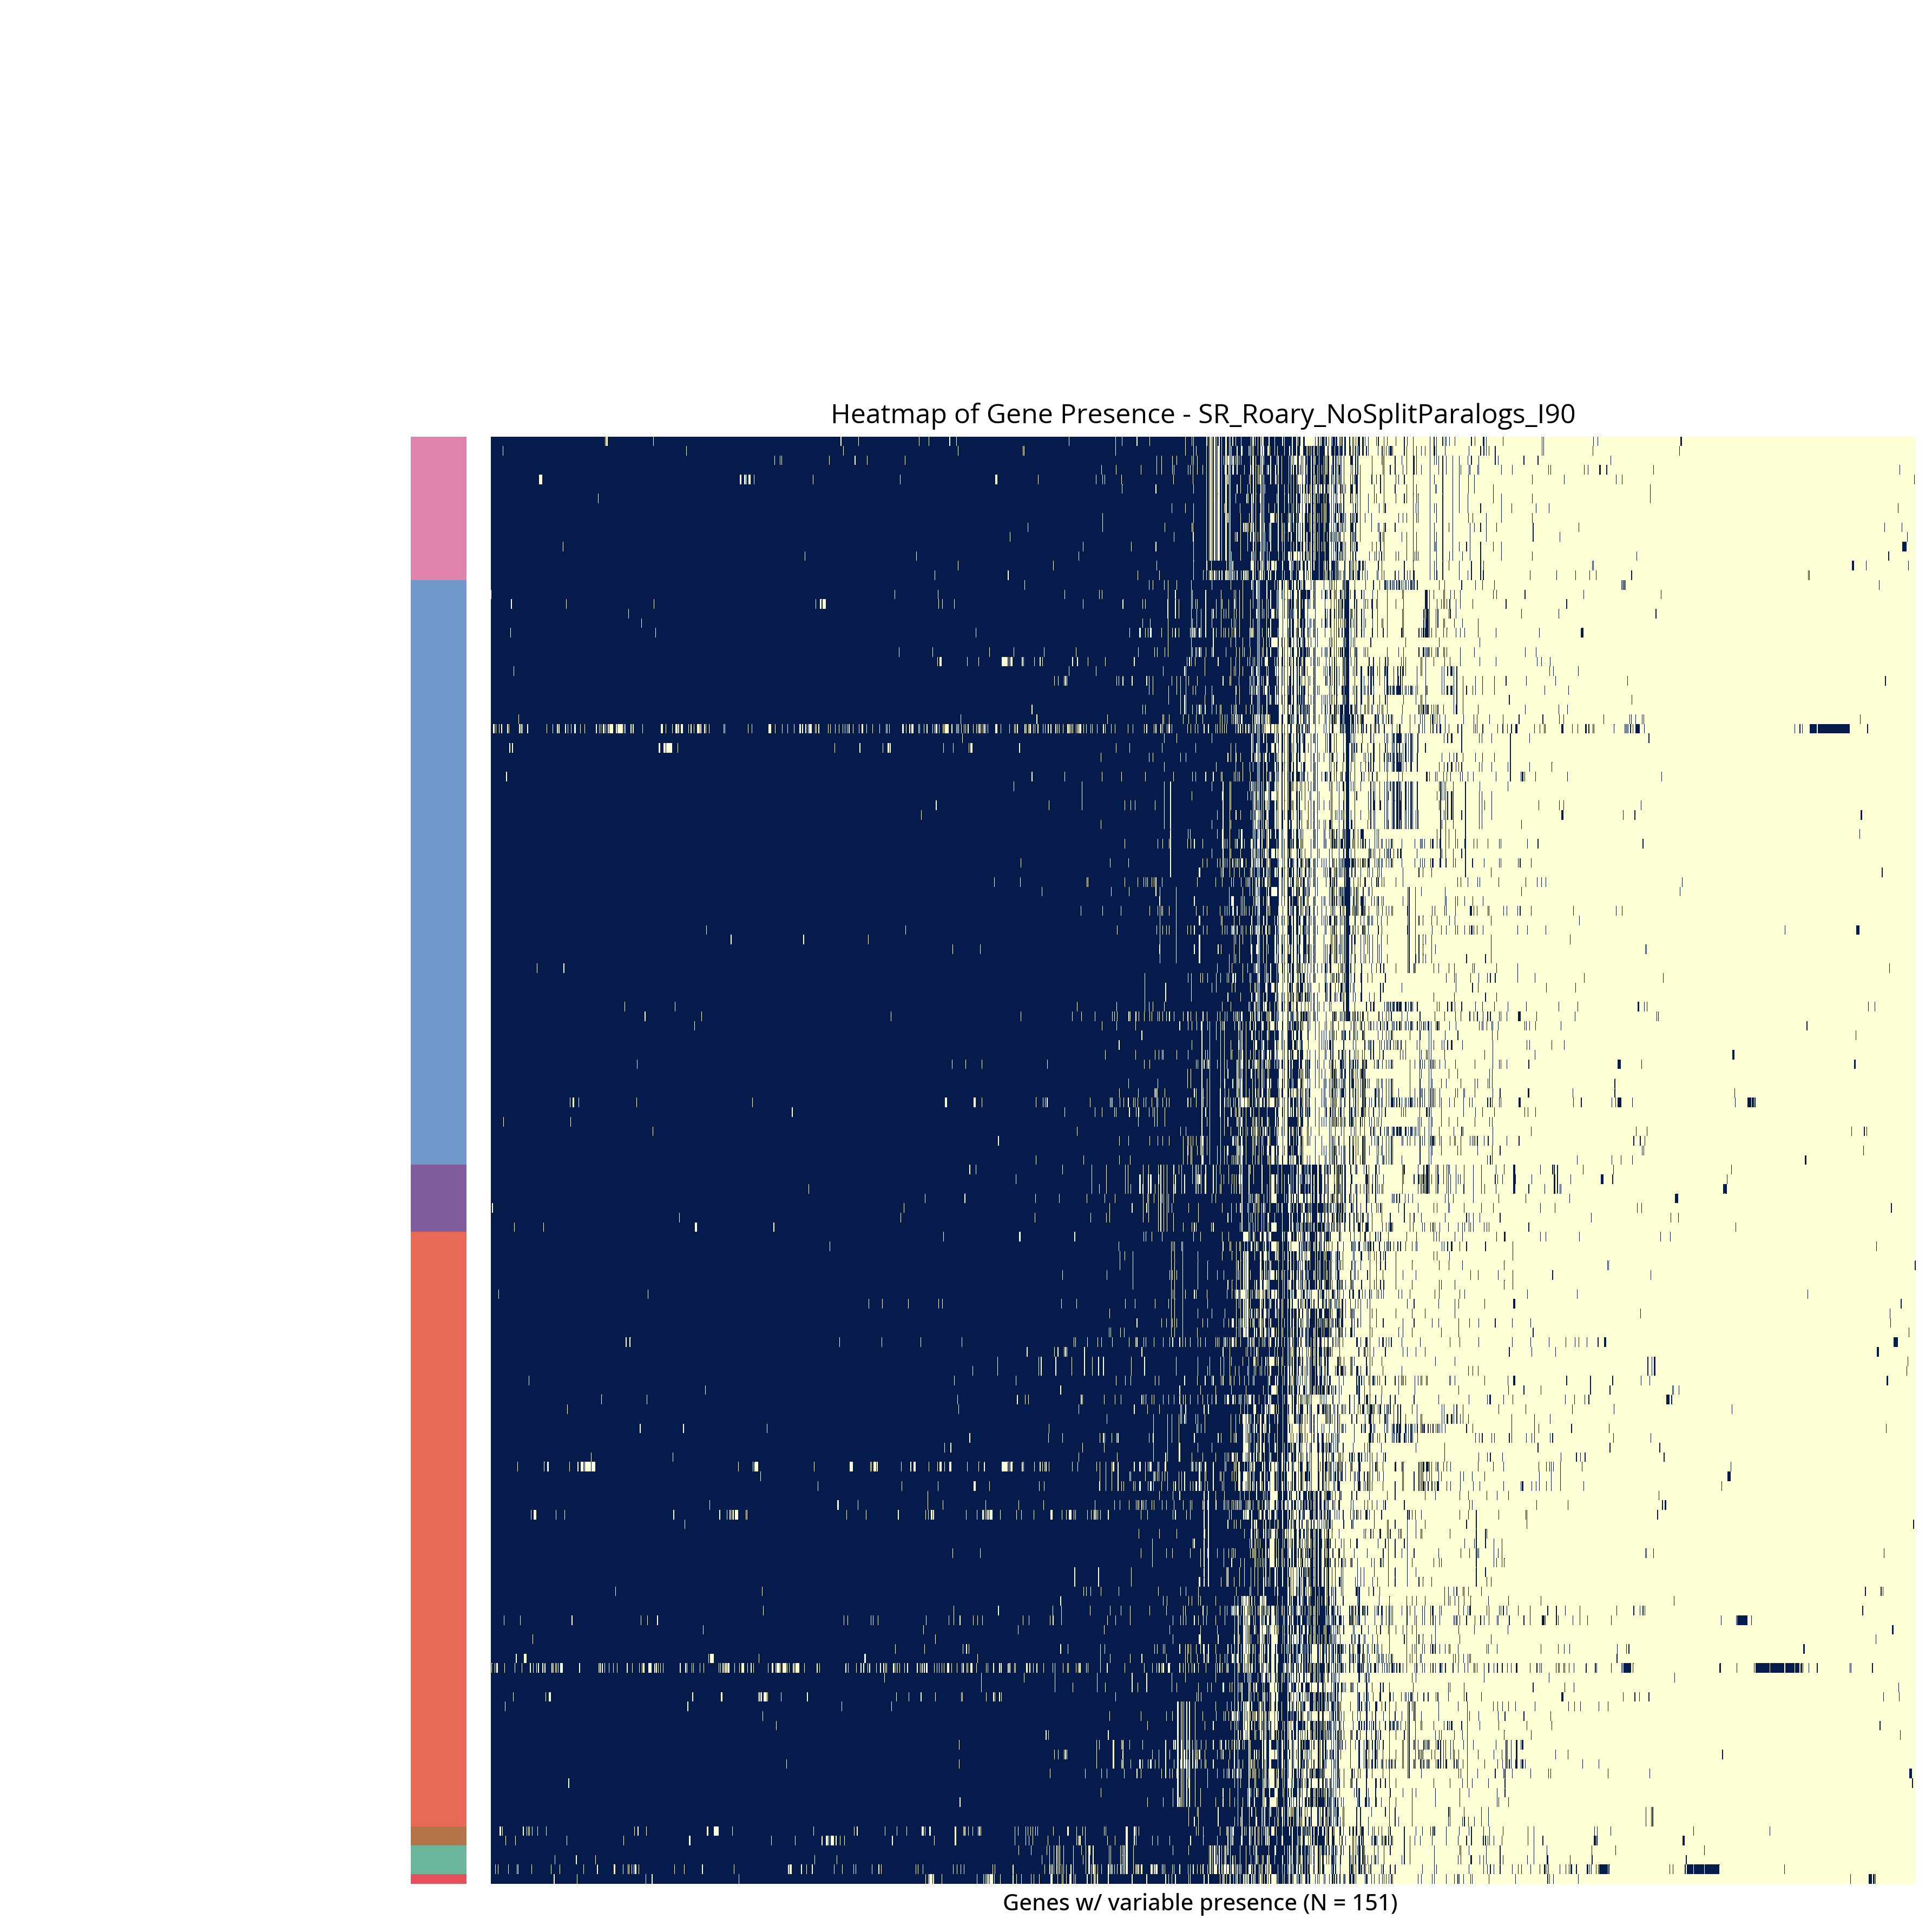

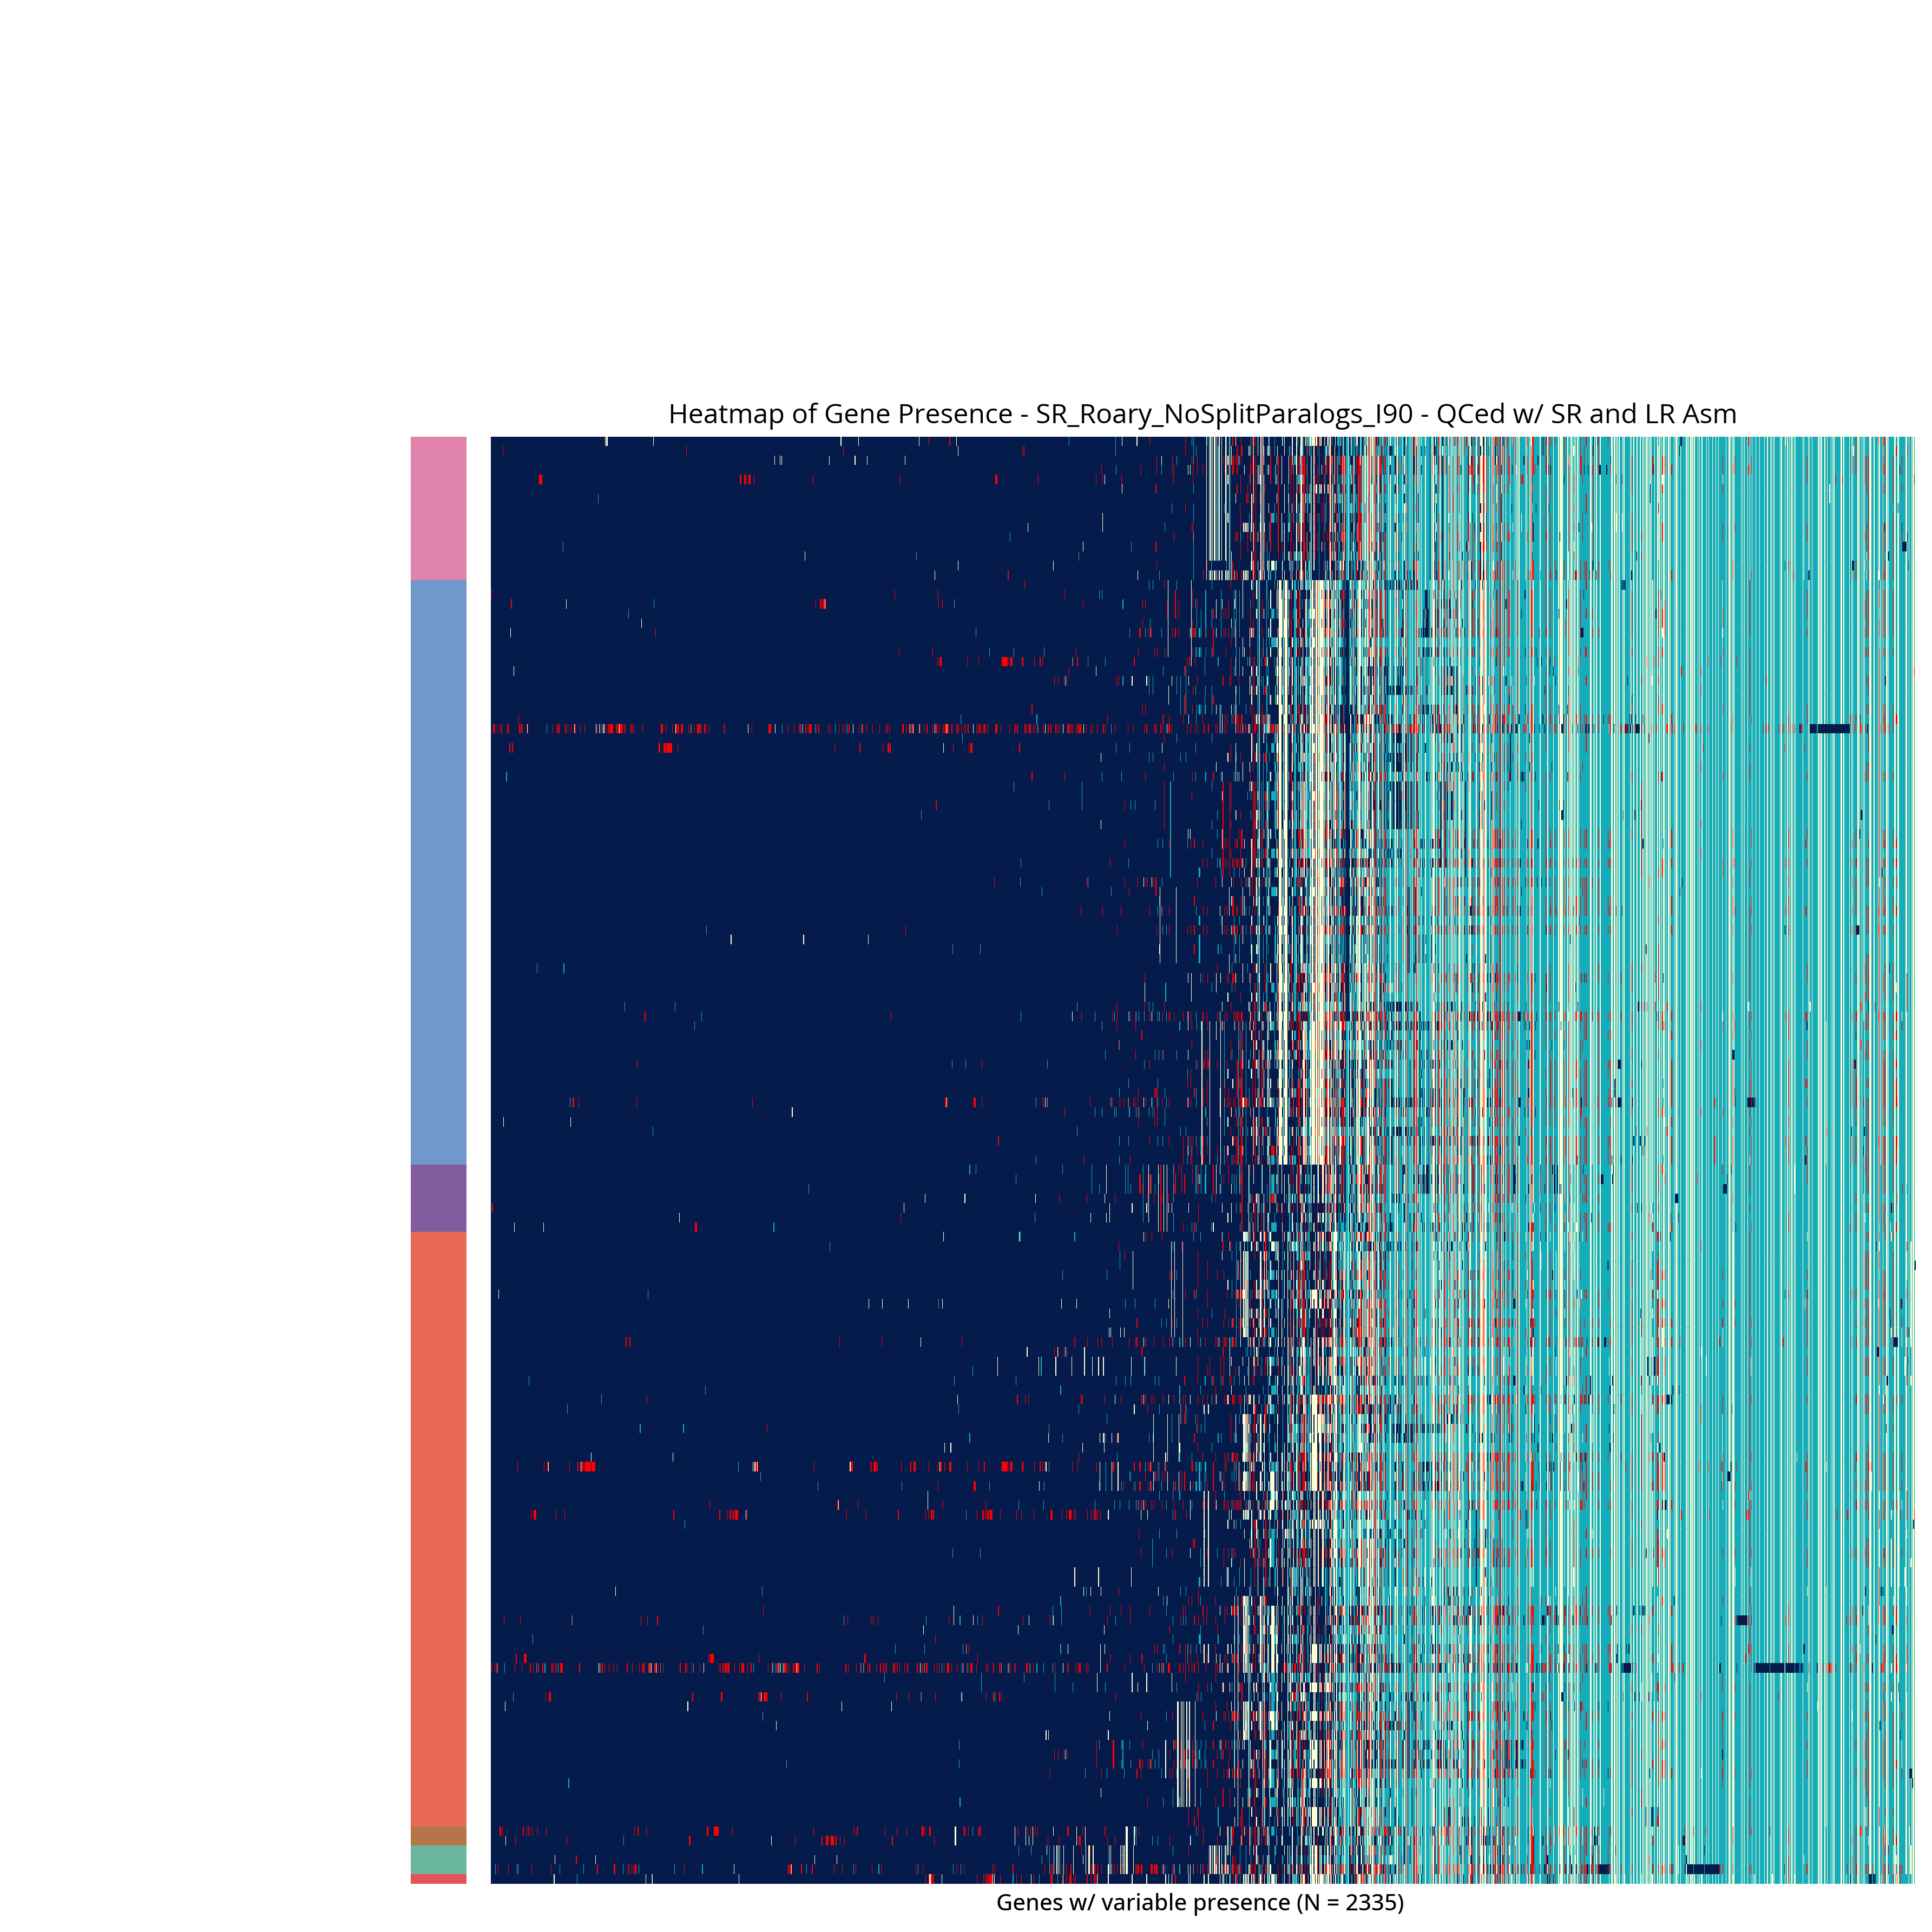

SR_Roary_NoSplitParalogs_I80
(151, 2234)


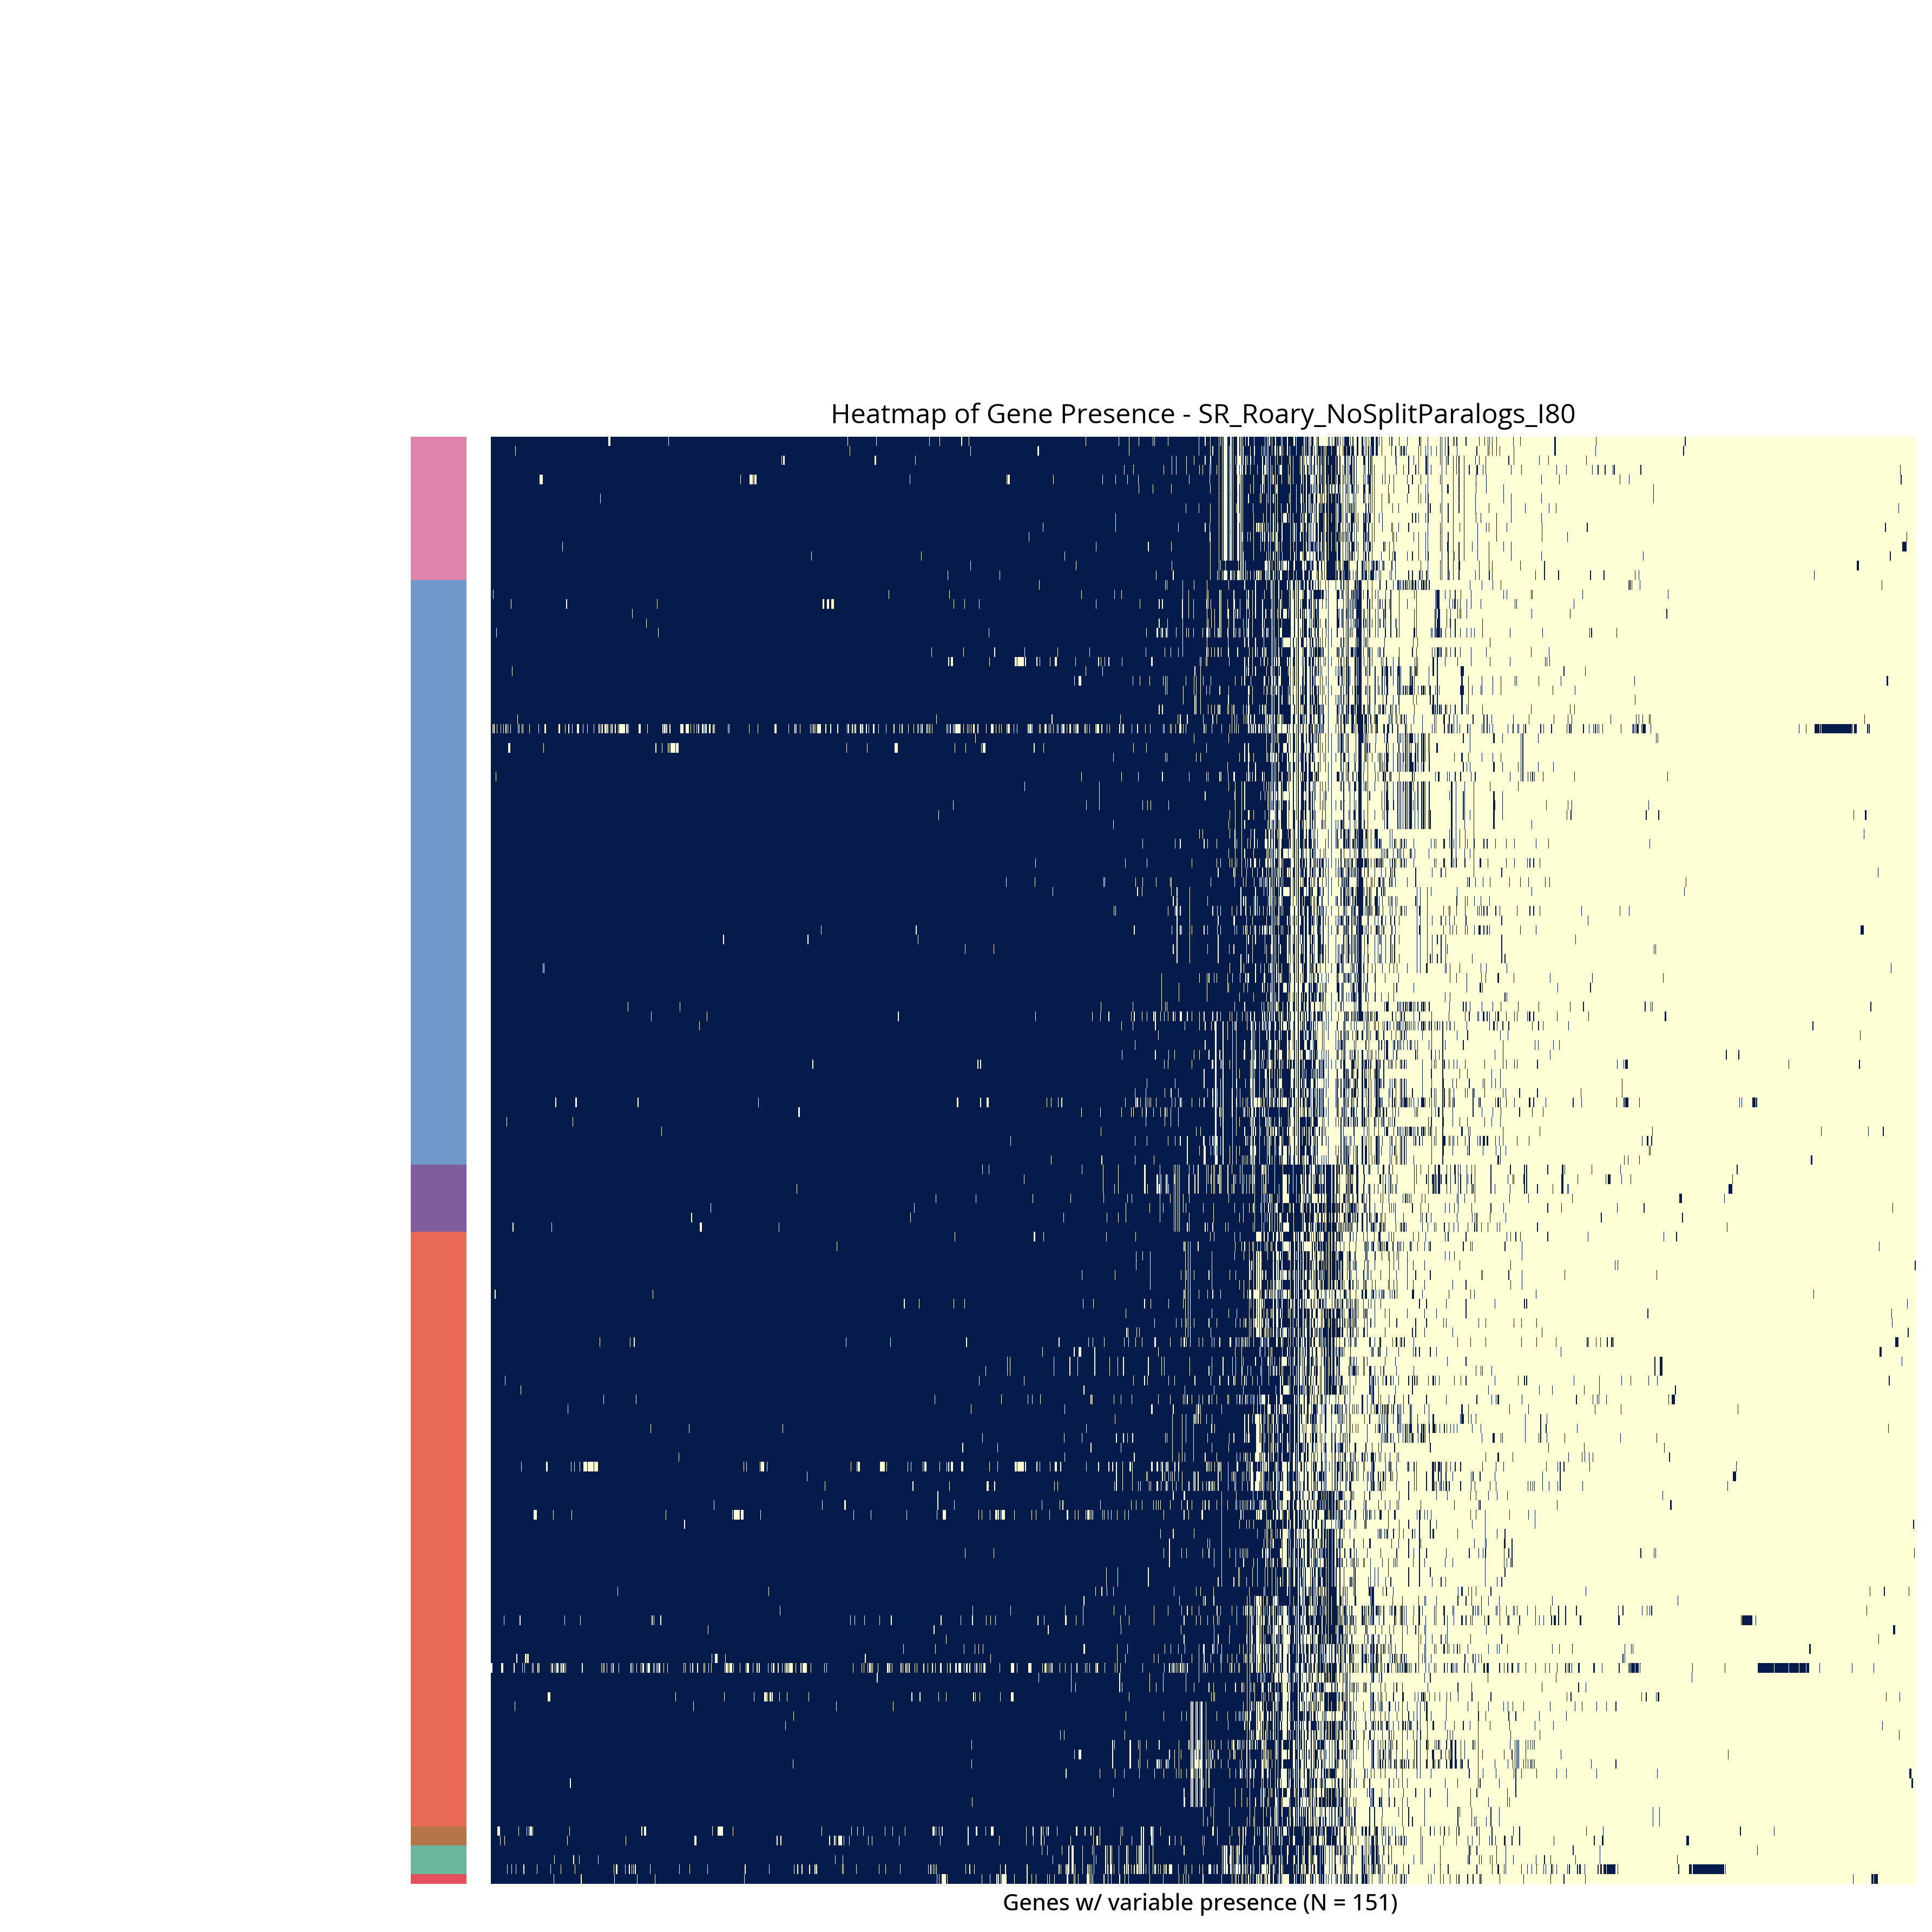

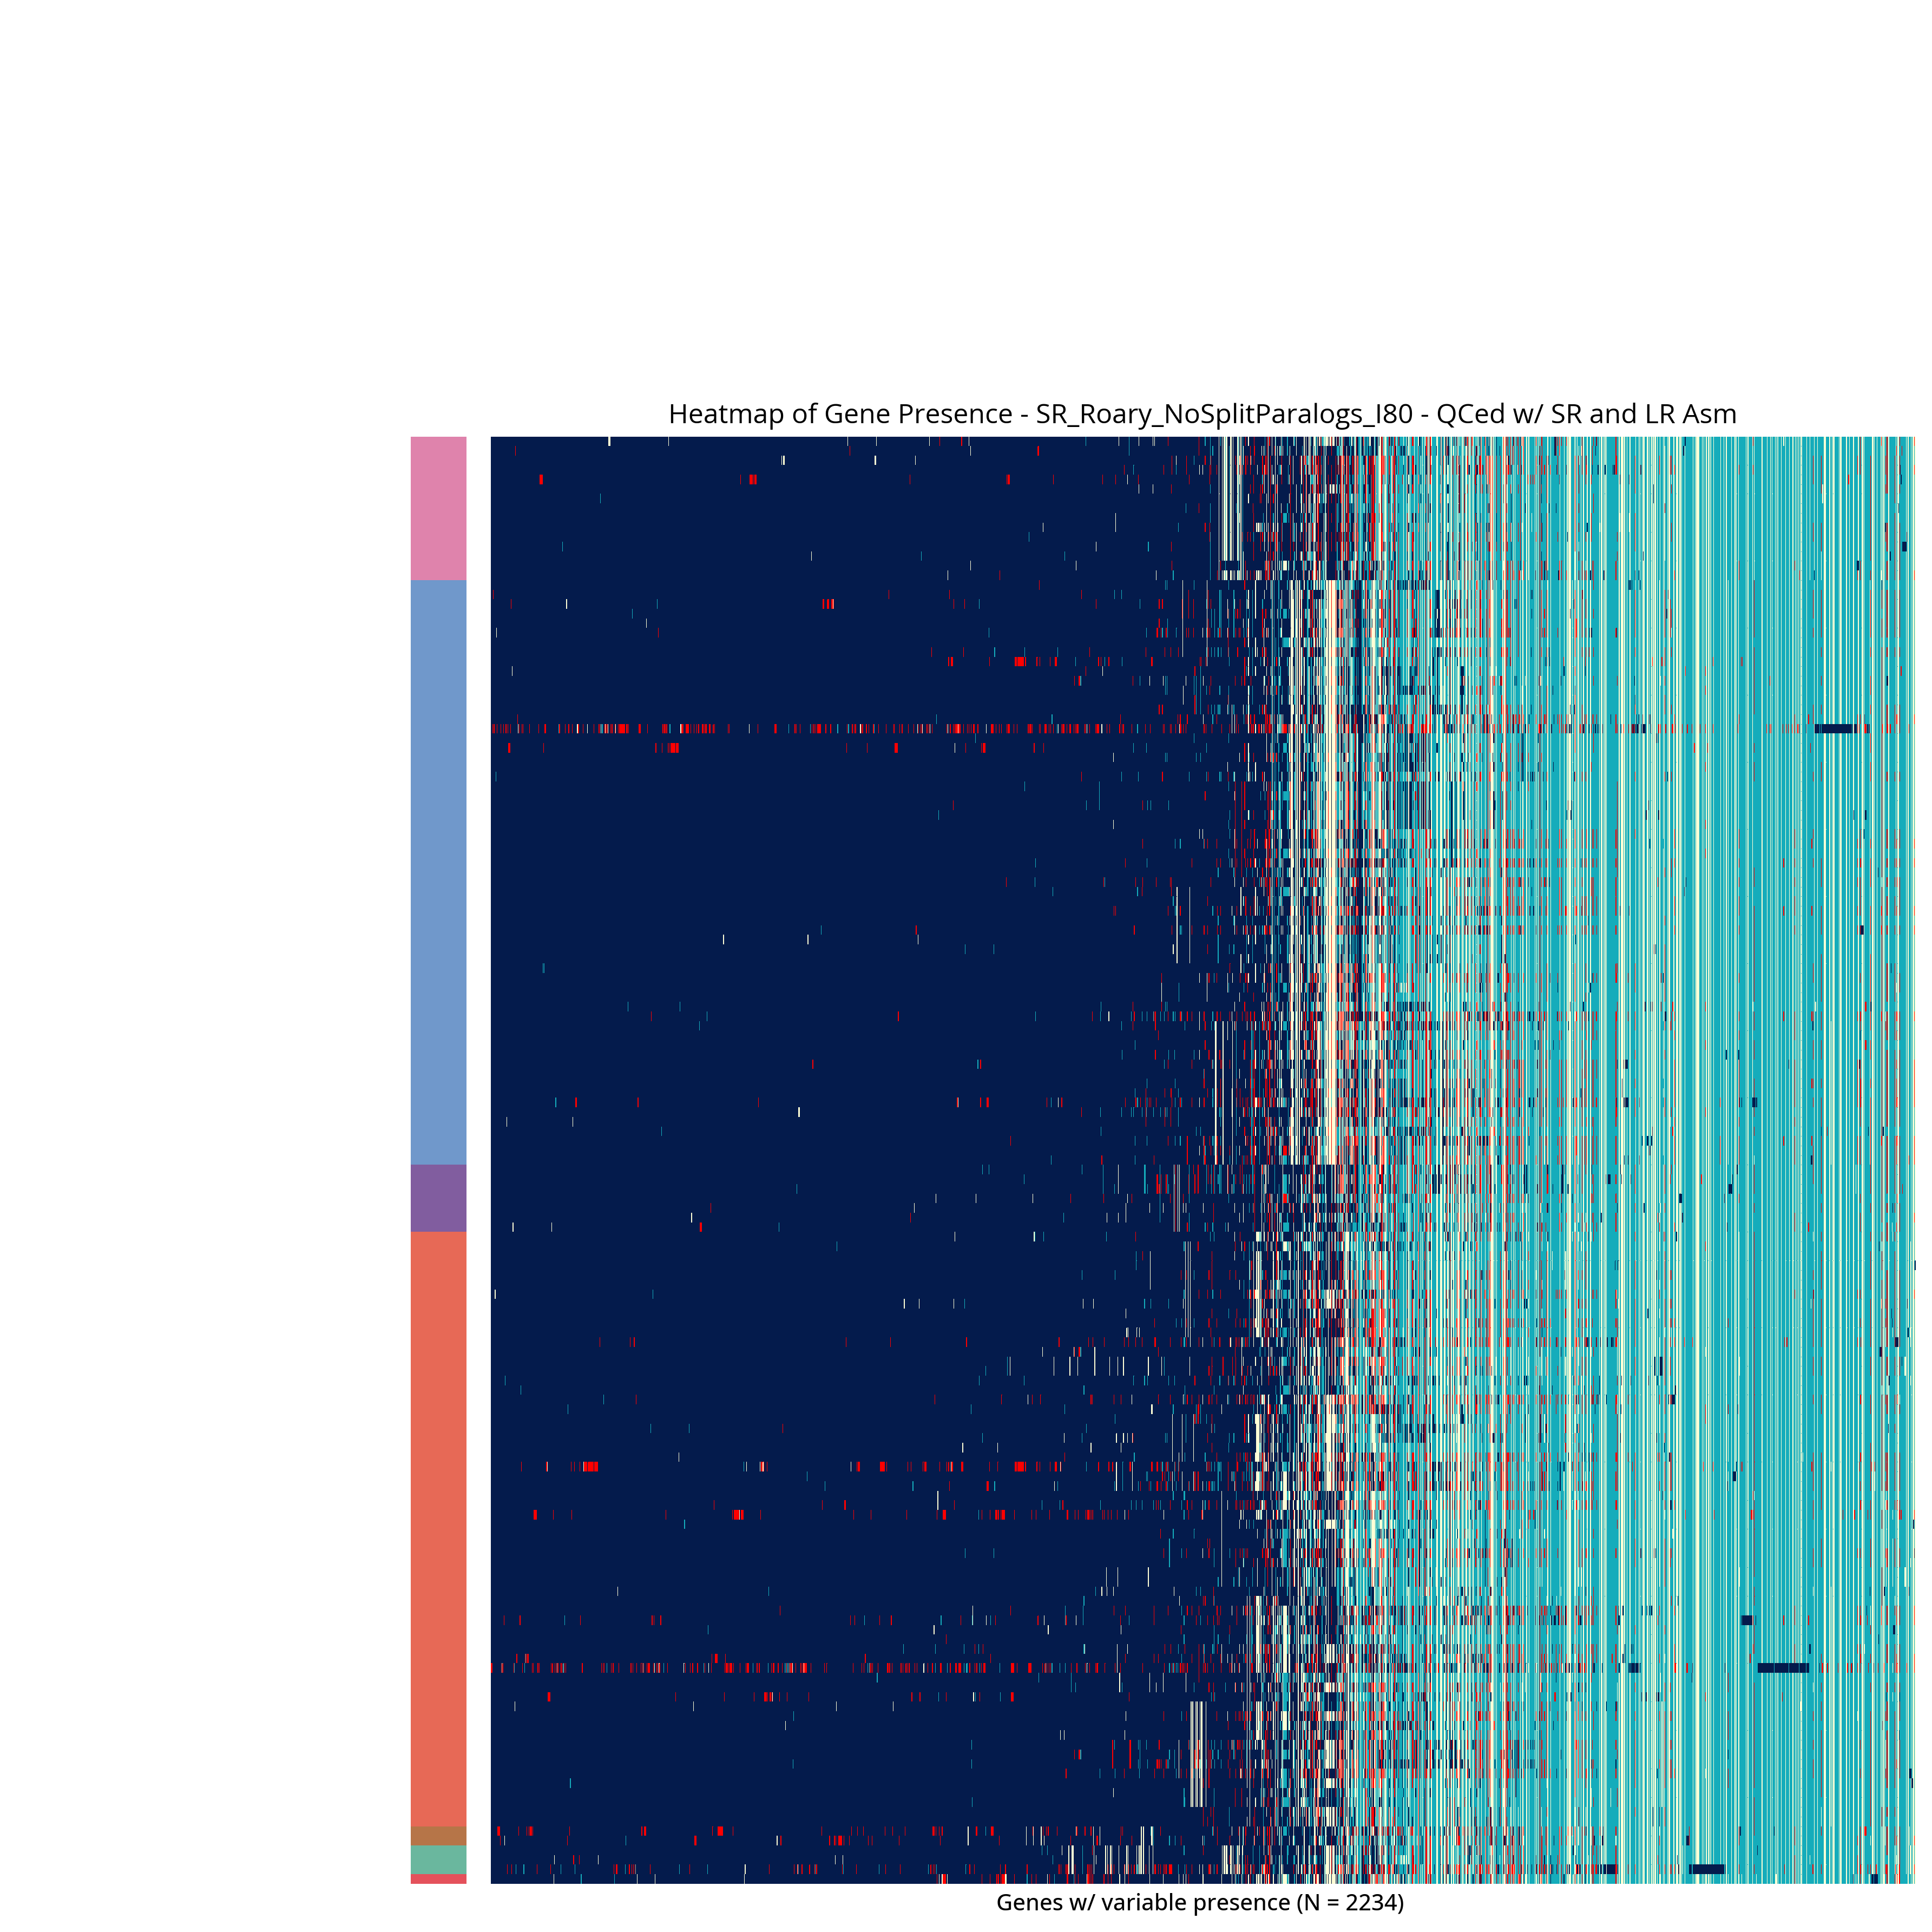

In [72]:
for i_Param in list(Pres_LRAsmQC_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = Pres_LRAsmQC_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False) 

    heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_2, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel(f'Mtb Assemblies (N = {heatmap_data.shape[0]}) ')
    plt.ylabel('')
    
    plt.xlabel(f'Genes w/ variable presence (N = {heatmap_data.shape[1]}) ')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param} - QCed w/ SR and LR Asm')
    plt.ylabel(f'Mtb Assemblies (N = {heatmap_data.shape[0]}) ')
    plt.ylabel('')
    
    plt.xlabel(f'Genes w/ variable presence (N = {heatmap_data.shape[1]}) ')

    plt.show() 



In [73]:
Pres_LRAsmQC_Dict["SR_Panaroo_Moderate_MP"].sort_values("NumAsm_WiGene", ascending=False).head(3)

Gene  N0072  N0153  TB3113  TB1236  TB2659  TB2780  TB1612  \
Gene                                                                           
group_2429  group_2429      1      1       1       1       1       1       1   
group_2316  group_2316      1      1       1       1       1       1       1   
kmtR              kmtR      1      1       1       1       1       1       1   

            TB2512  TB2981  TB3091  M0003941_3  TB3368  N0145  N0155  TB2995  \
Gene                                                                           
group_2429       1       1       1           1       1      1      1       1   
group_2316       1       1       1           1       1      1      1       1   
kmtR             1       1       1           1       1      1      1       1   

            TB3396  N0004  N1274  N0054  02_R1179  01_R1134  M0017522_5  \
Gene                                                                      
group_2429       1      1      1      1         1         1           1   
group_2316       1      1      1      1         1         1           1   
kmtR             1      1      1      1         1         1           1   

            M0016395_7  M0010874_7  02_R1708  02_R0894  01_R1430  M0014888_3  \
Gene                                                                           
group_2429           1           1         1         1         1           1   
group_2316           1           1         1         1         1           1   
kmtR                 1           1         1         1         1           1   

            02_R1896  TB4620  TB3162  MT_0080  TB3054  TB3251  M0016737_0  \
Gene                                                                        
group_2429         1       1       1        1       1       1           1   
group_2316         1       1       1        1       1       1           1   
kmtR               1       1       1        1       1       1           1   

            TB2661  TB3237  TB3169  TB3386  TB3334  M0011368_9  TB2968  N1272  \
Gene                                                                            
group_2429       1       1       1       1       1           1       1      1   
group_2316       1       1       1       1       1           1       1      1   
kmtR             1       1       1       1       1           1       1      1   

            N1176  N1202  N1177  N0091  RW-TB008  9050-05  4549-04  696-05  \
Gene                                                                         
group_2429      1      1      1      1         1        1        1       1   
group_2316      1      1      1      1         1        1        1       1   
kmtR            1      1      1      1         1        1        1       1   

            702-06  706-05  8129-04  3003-06  8651-04  QC-3  QC-9  QC-5  QC-8  \
Gene                                                                            
group_2429       1       1        1        1        1     1     1     1     1   
group_2316       1       1        1        1        1     1     1     1     1   
kmtR             1       1        1        1        1     1     1     1     1   

            QC-10  QC-4  QC-7  QC-6  QC-1  mada_1-10  mada_2-46  mada_1-1  \
Gene                                                                        
group_2429      1     1     1     1     1          1          1         1   
group_2316      1     1     1     1     1          1          1         1   
kmtR            1     1     1     1     1          1          1         1   

            mada_1-36  mada_1-39  mada_1-51  mada_1-44  mada_117  mada_118  \
Gene                                                                         
group_2429          1          1          1          1         1         1   
group_2316          1          1          1          1         1         1   
kmtR                1          1          1          1         1         1   

            mada_122  mada_107  R27252  R23887  R30215  R30078  R29816  \

In [74]:
#DF = Pres_LRAsmQC_Dict["SR_Panaroo_Moderate"].sort_values("NumAsm_WiGene", ascending=False)

#DF_LoBUSCO = DF = 
#DF_LoBUSCO = DF = 


## Plot all BEFORE & AFTER LR-Asm QC plots - WHOLE Pan-genome Matrix

SR_Panaroo_Strict_MP
(151, 4211)


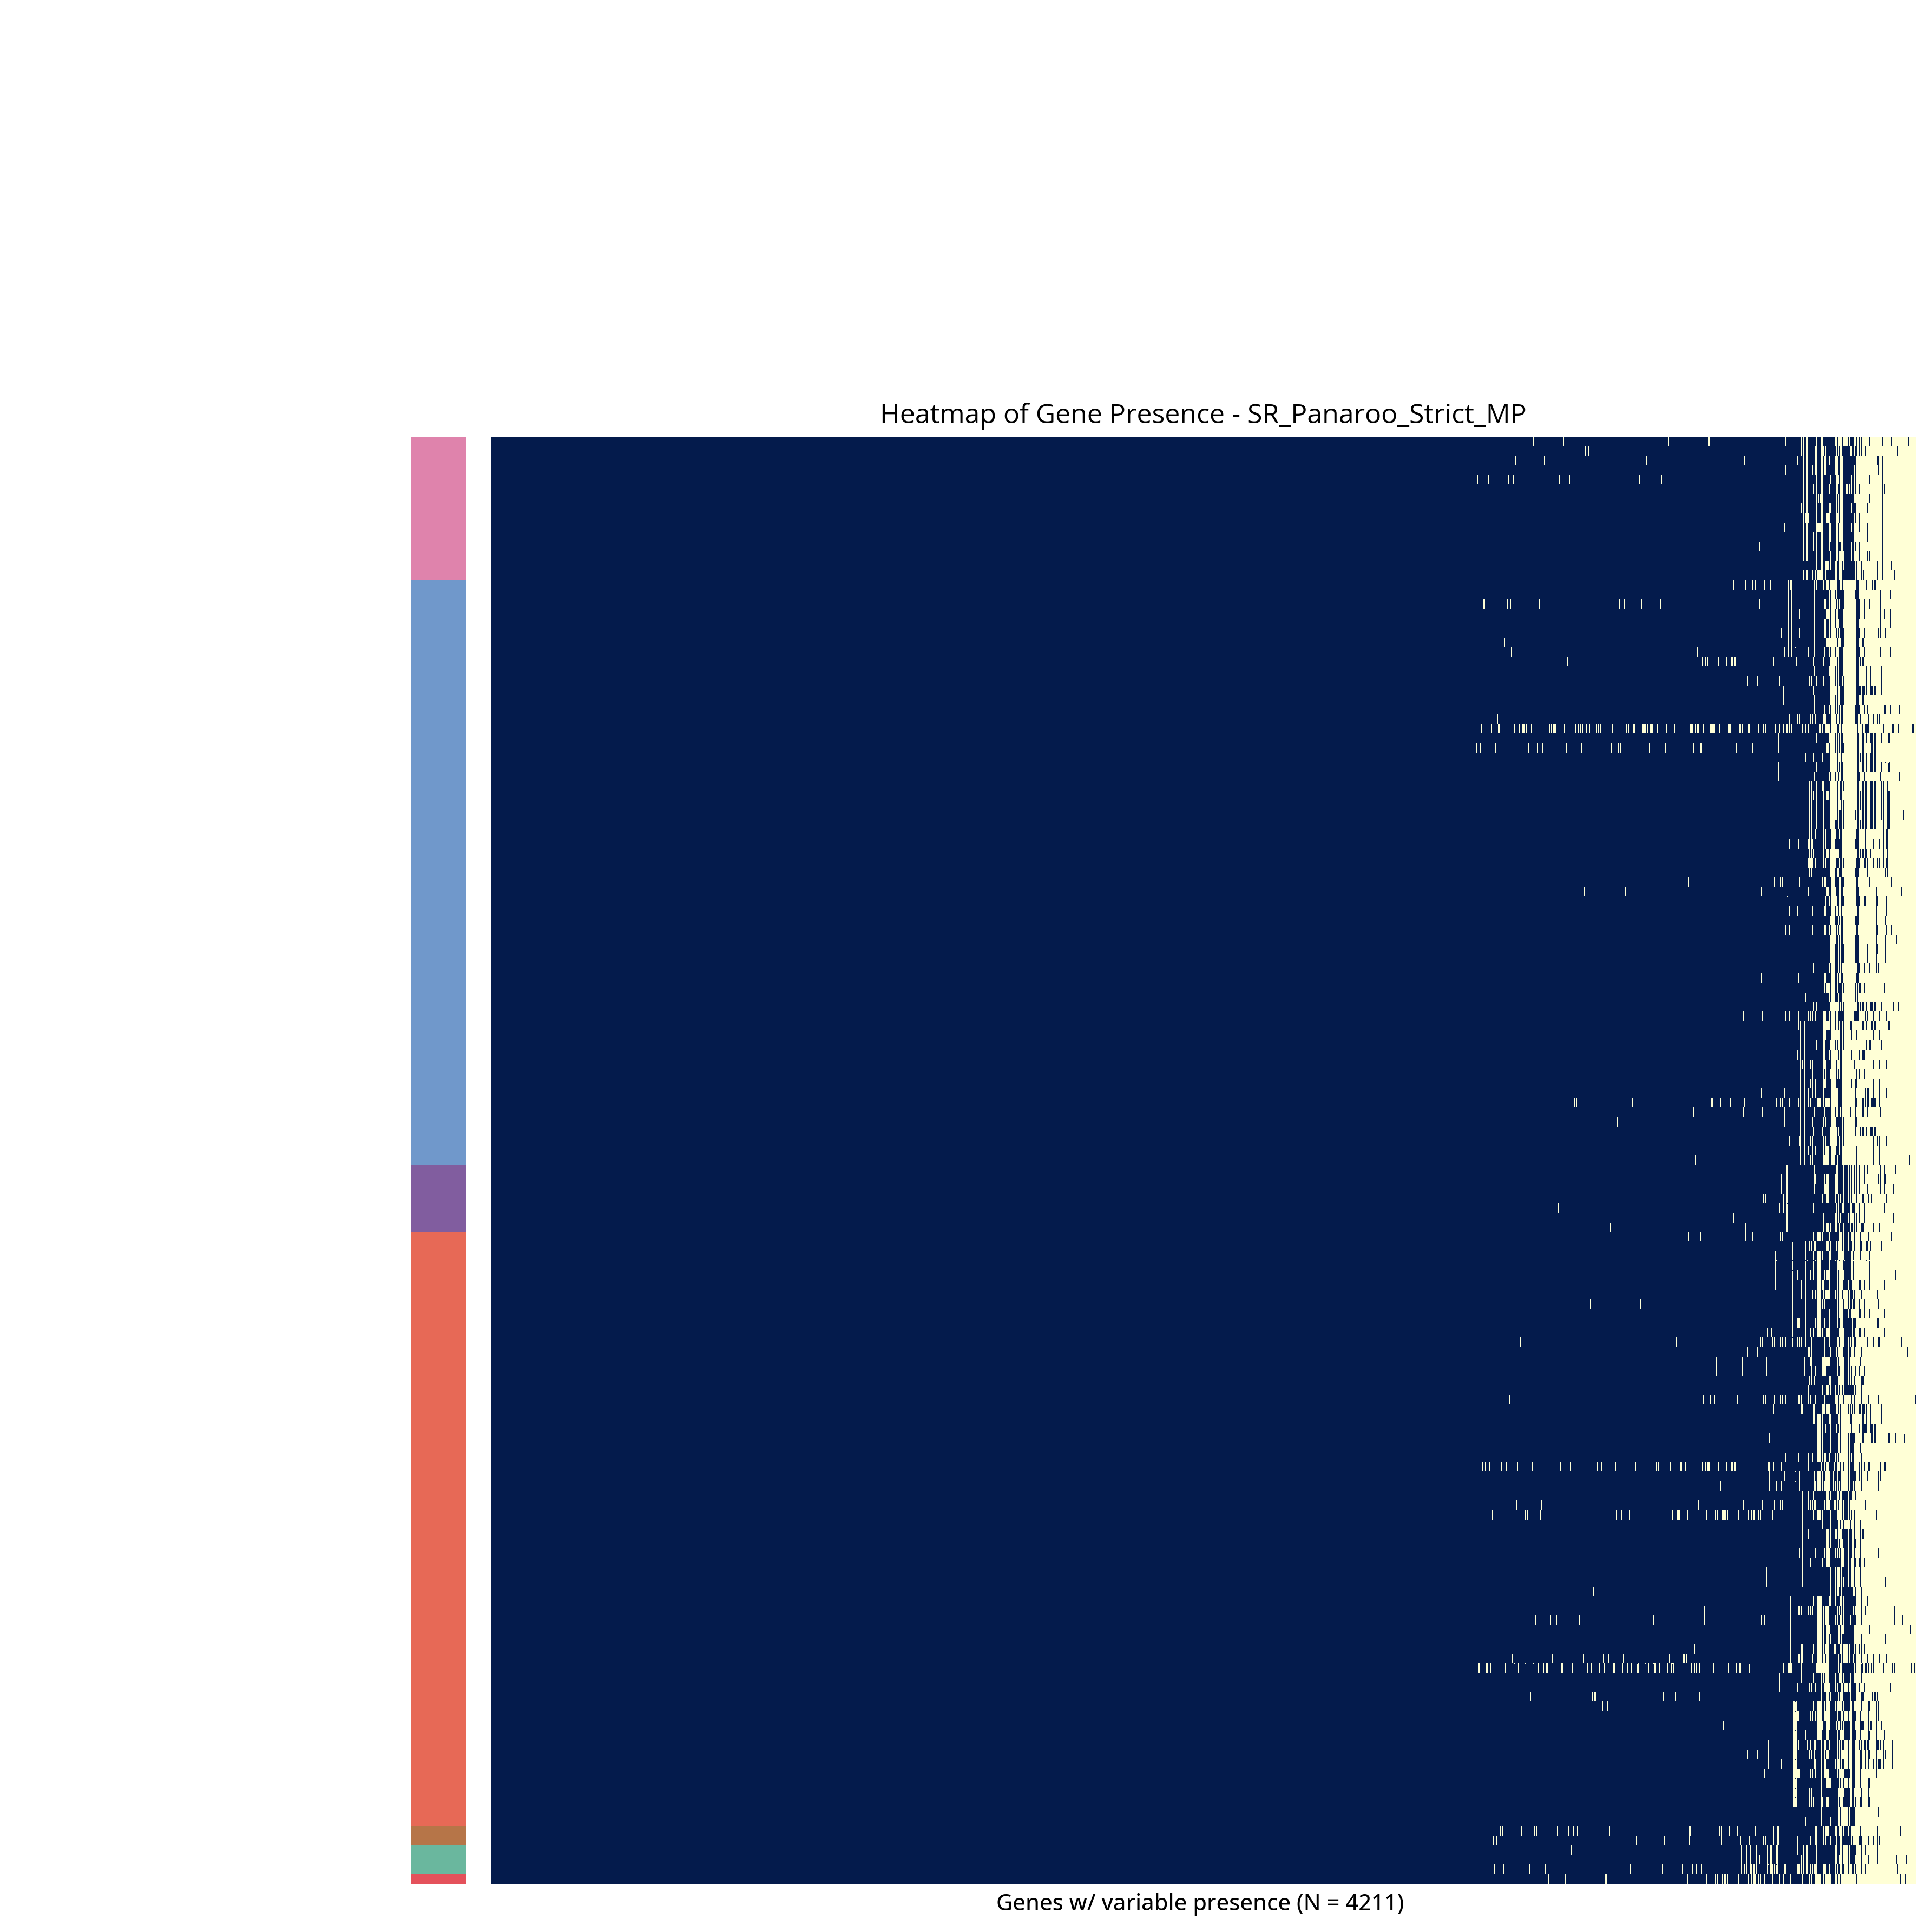

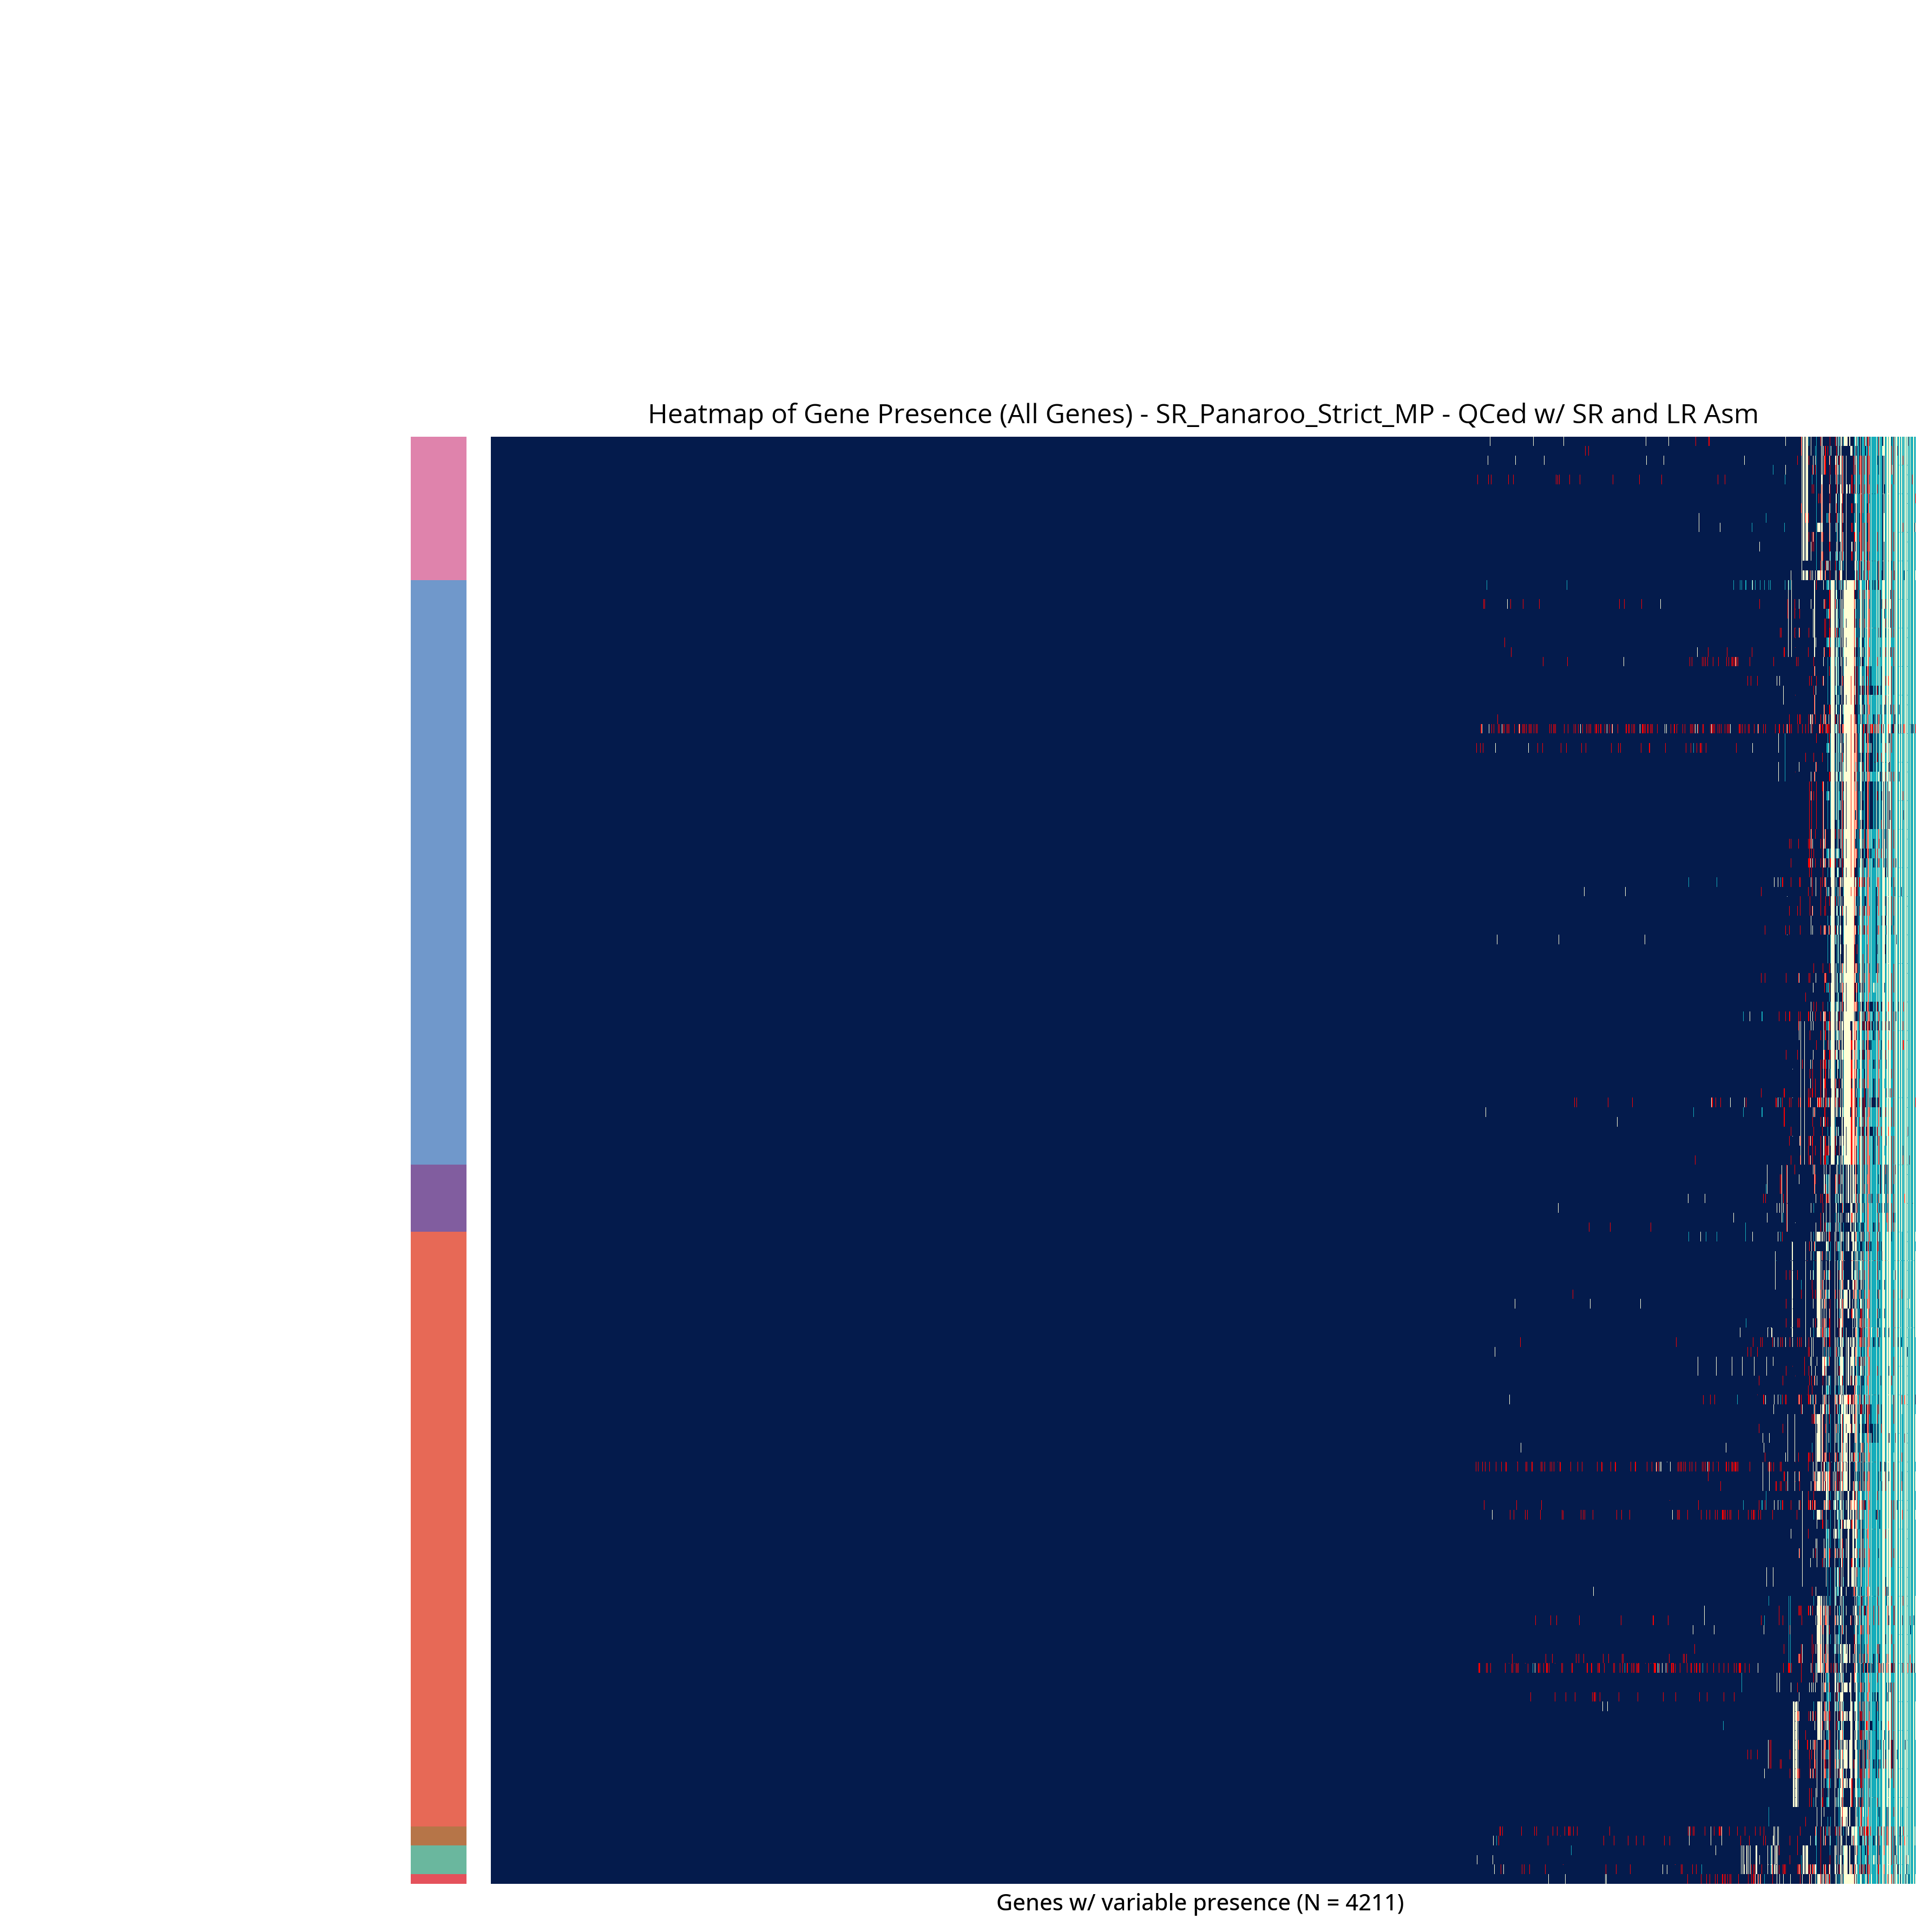

SR_Panaroo_Moderate_MP
(151, 4382)


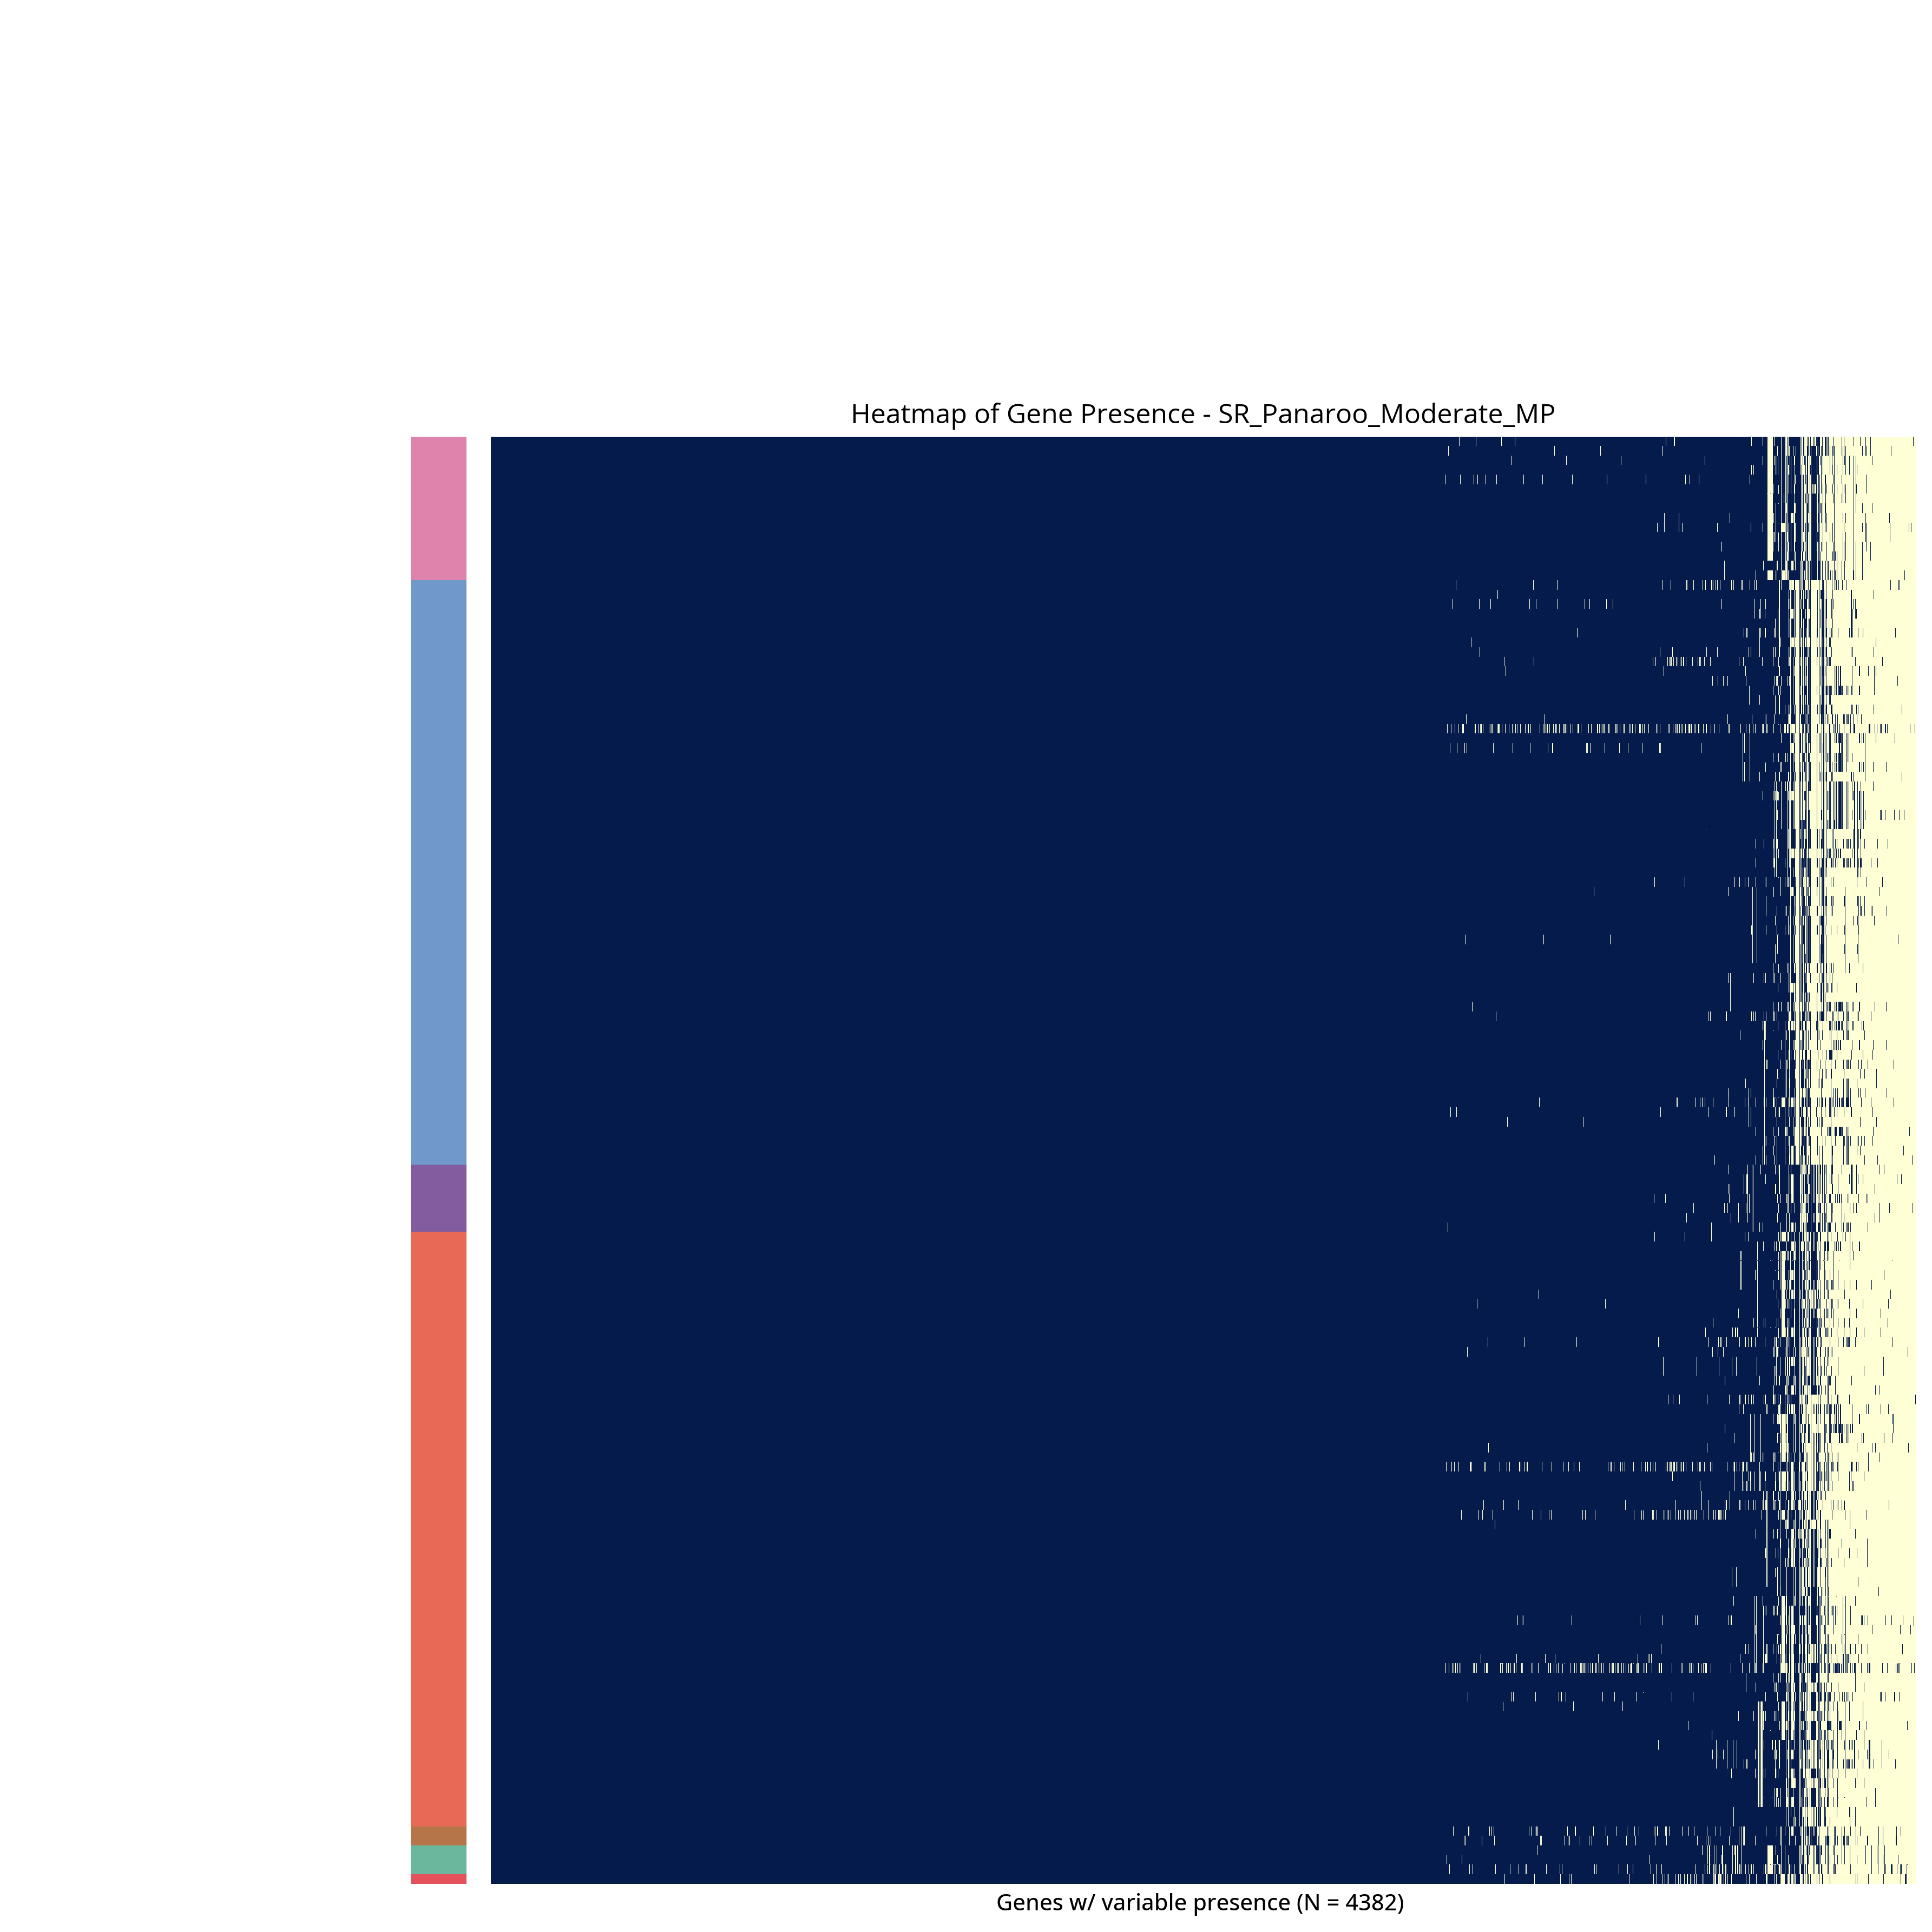

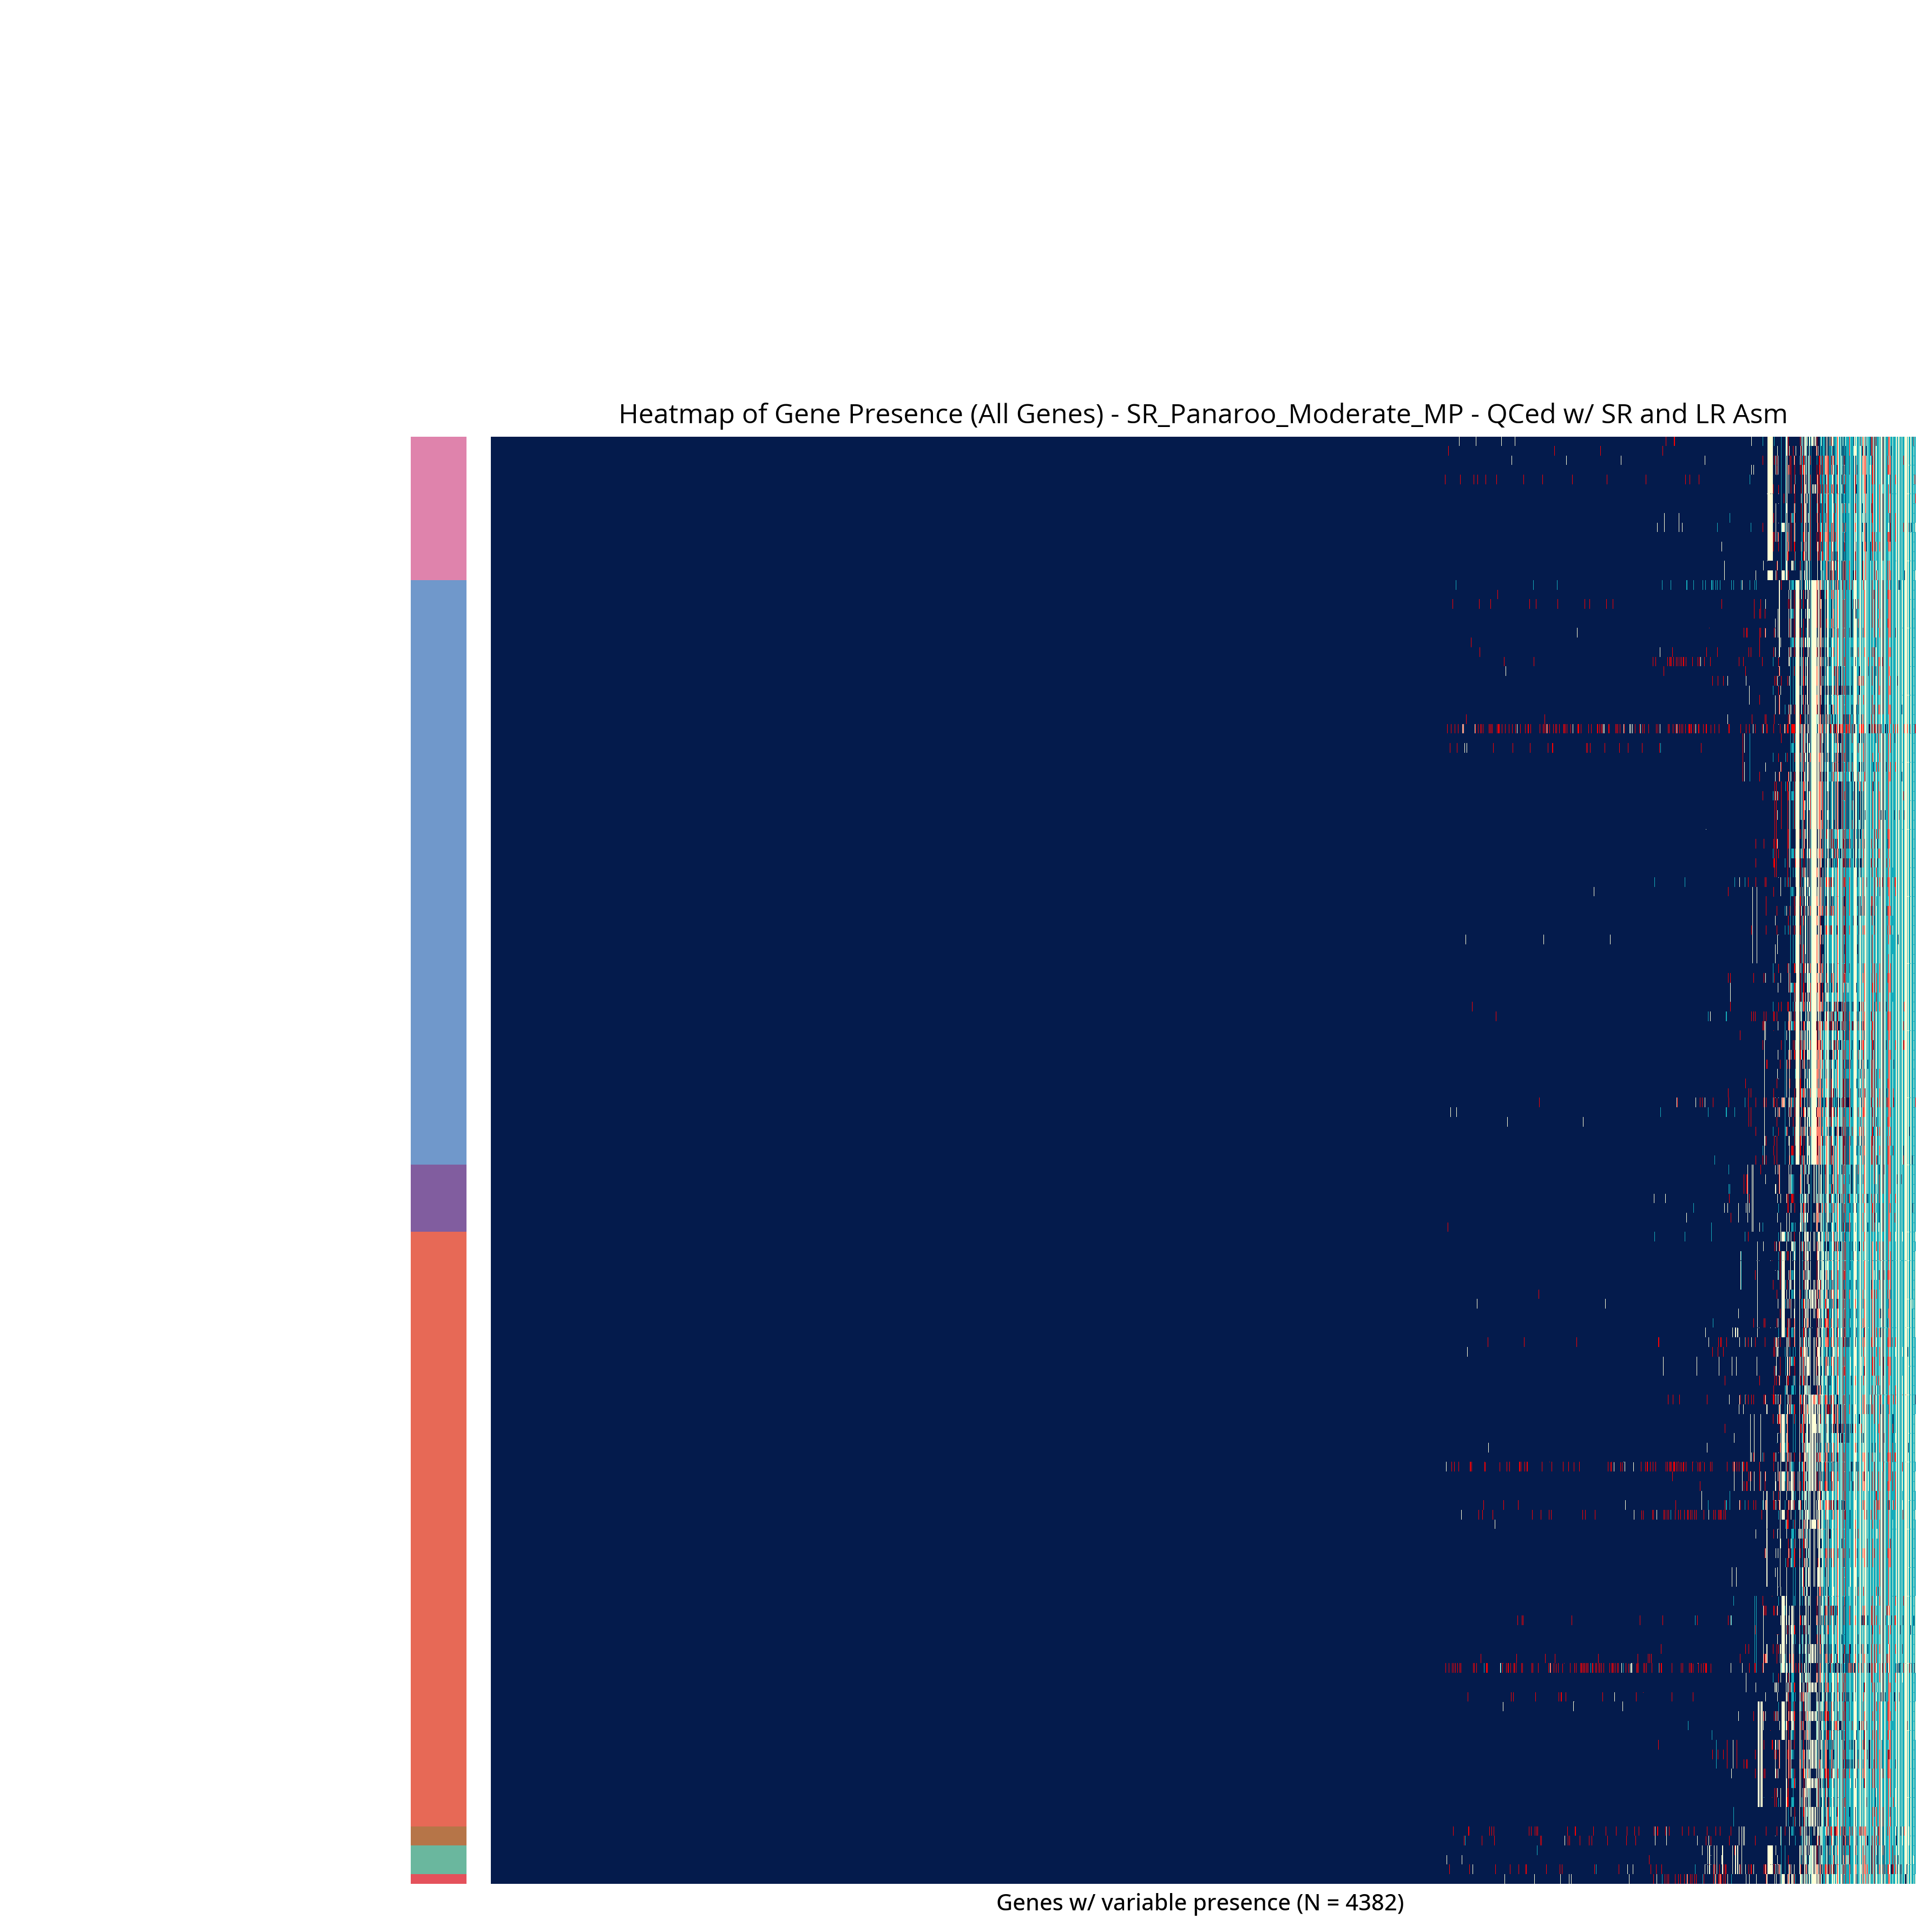

SR_Panaroo_Sens_MP
(151, 4600)


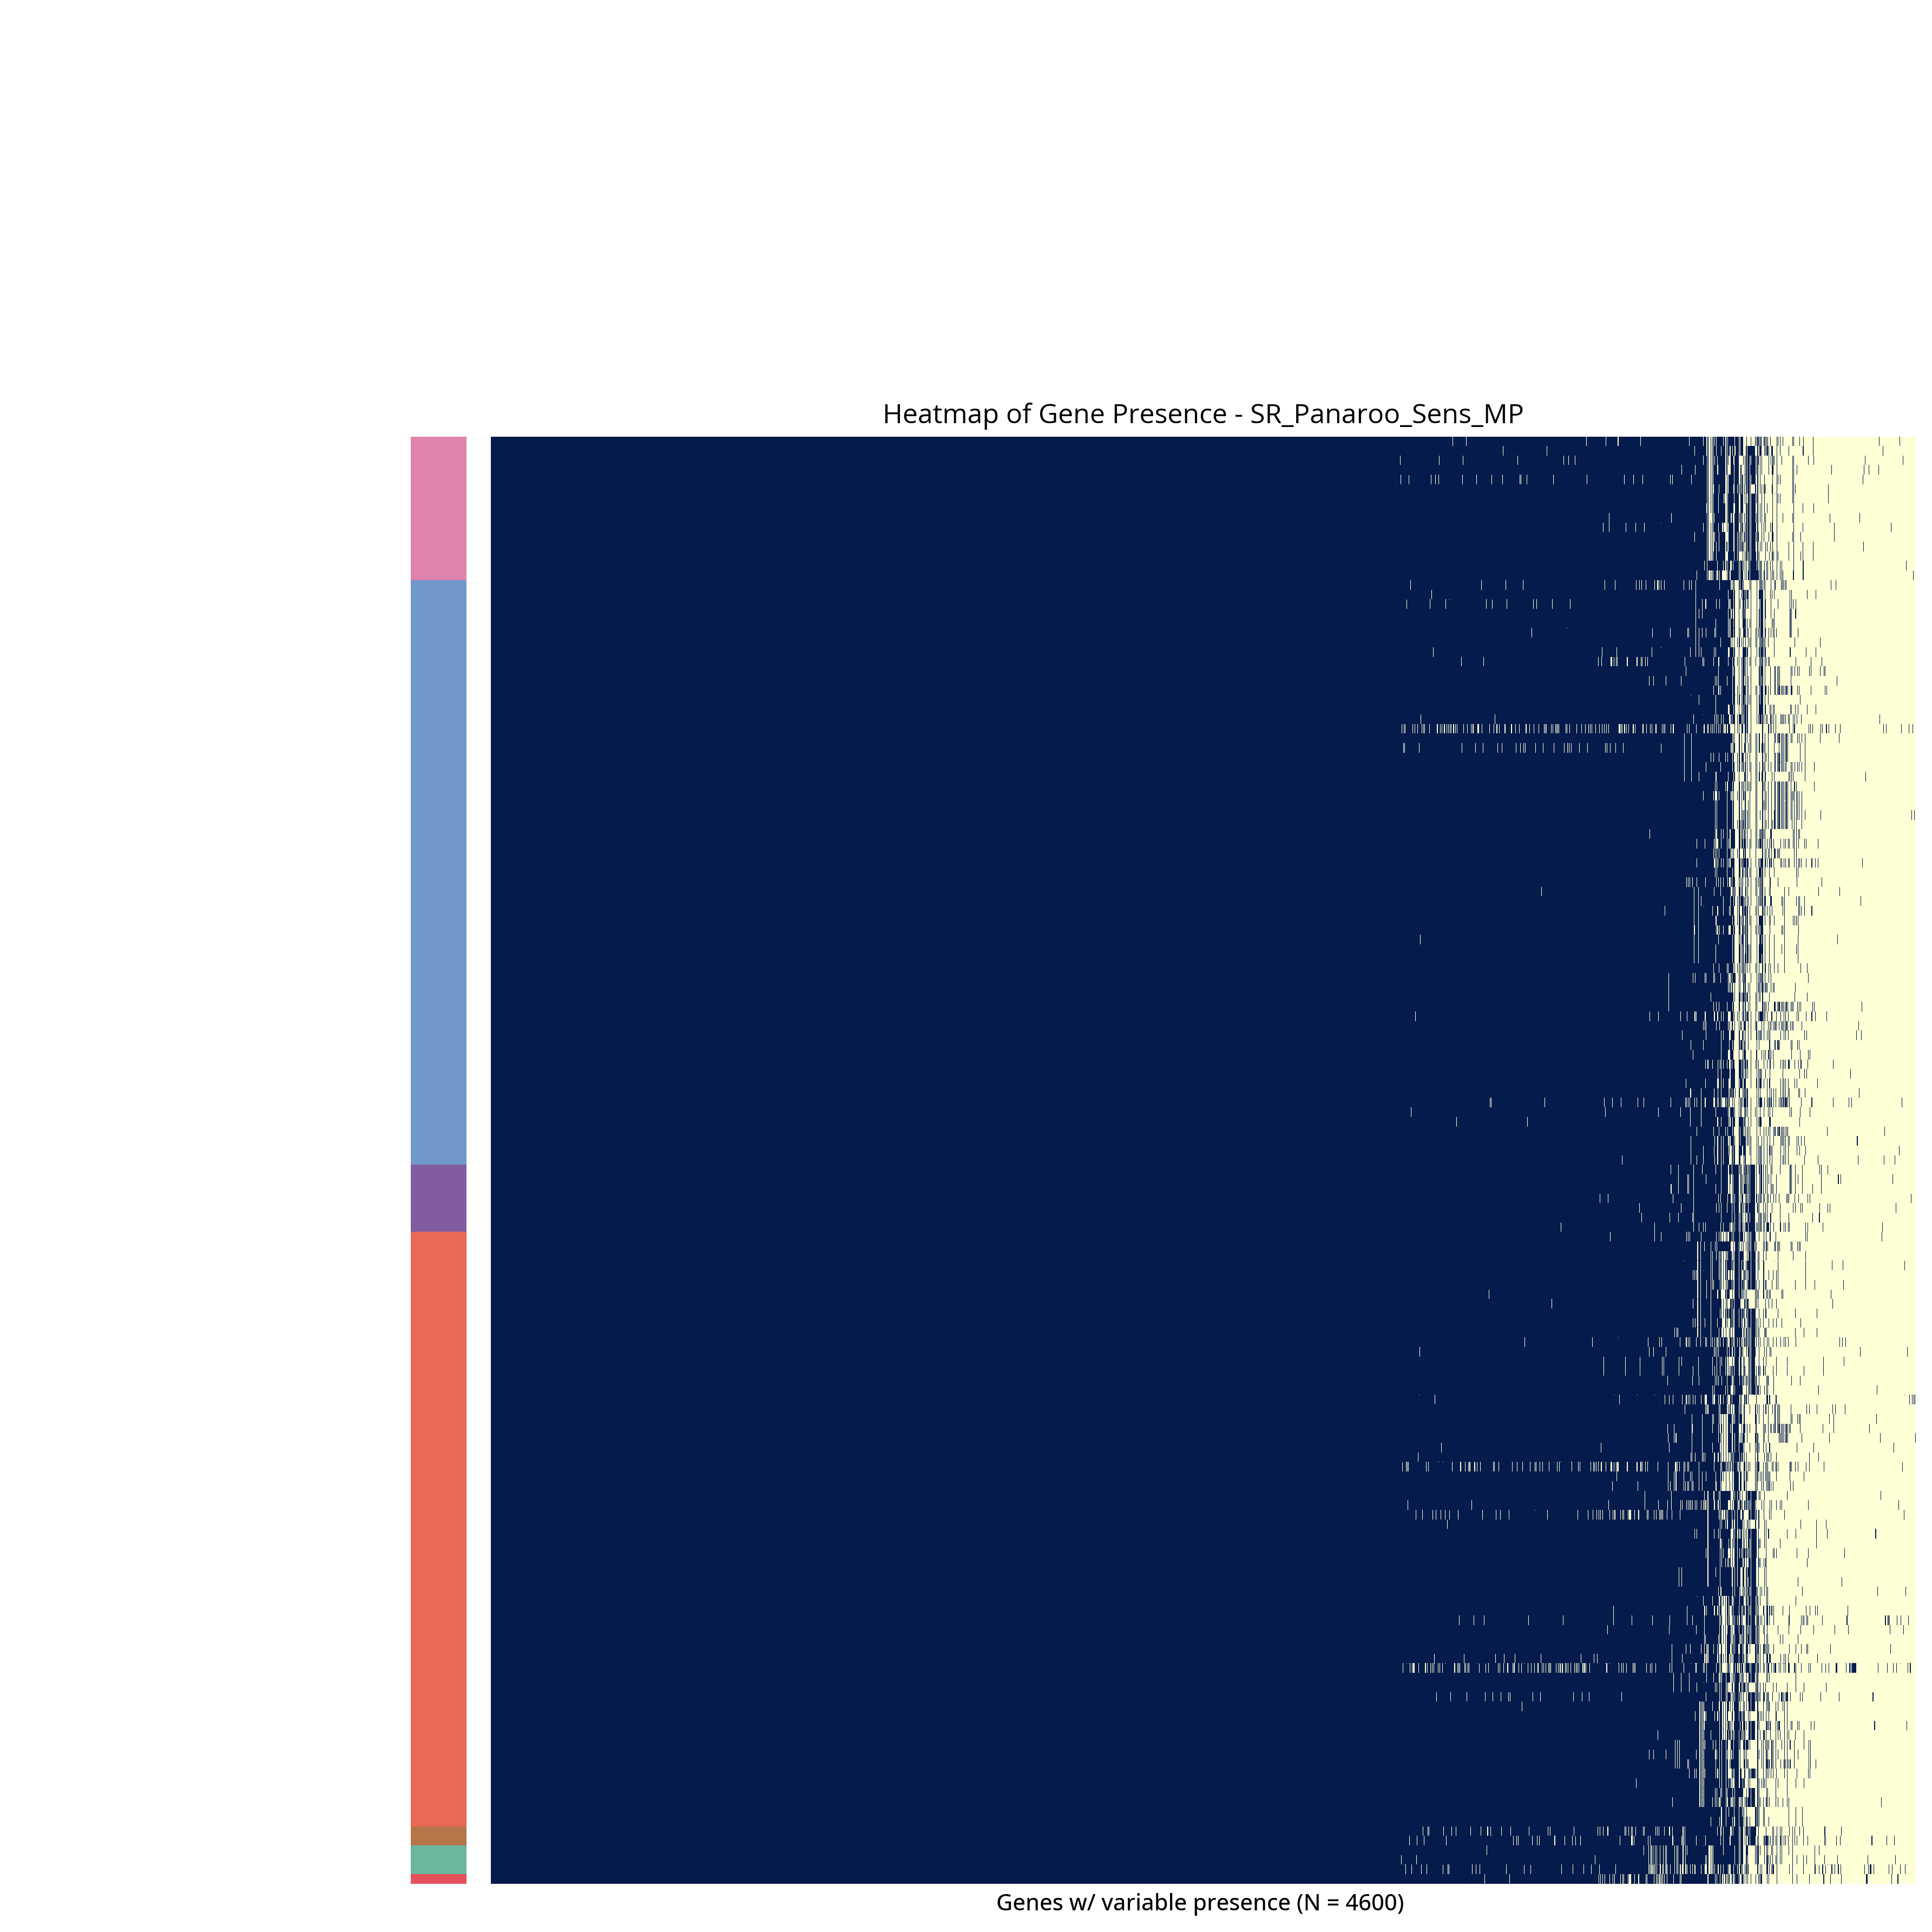

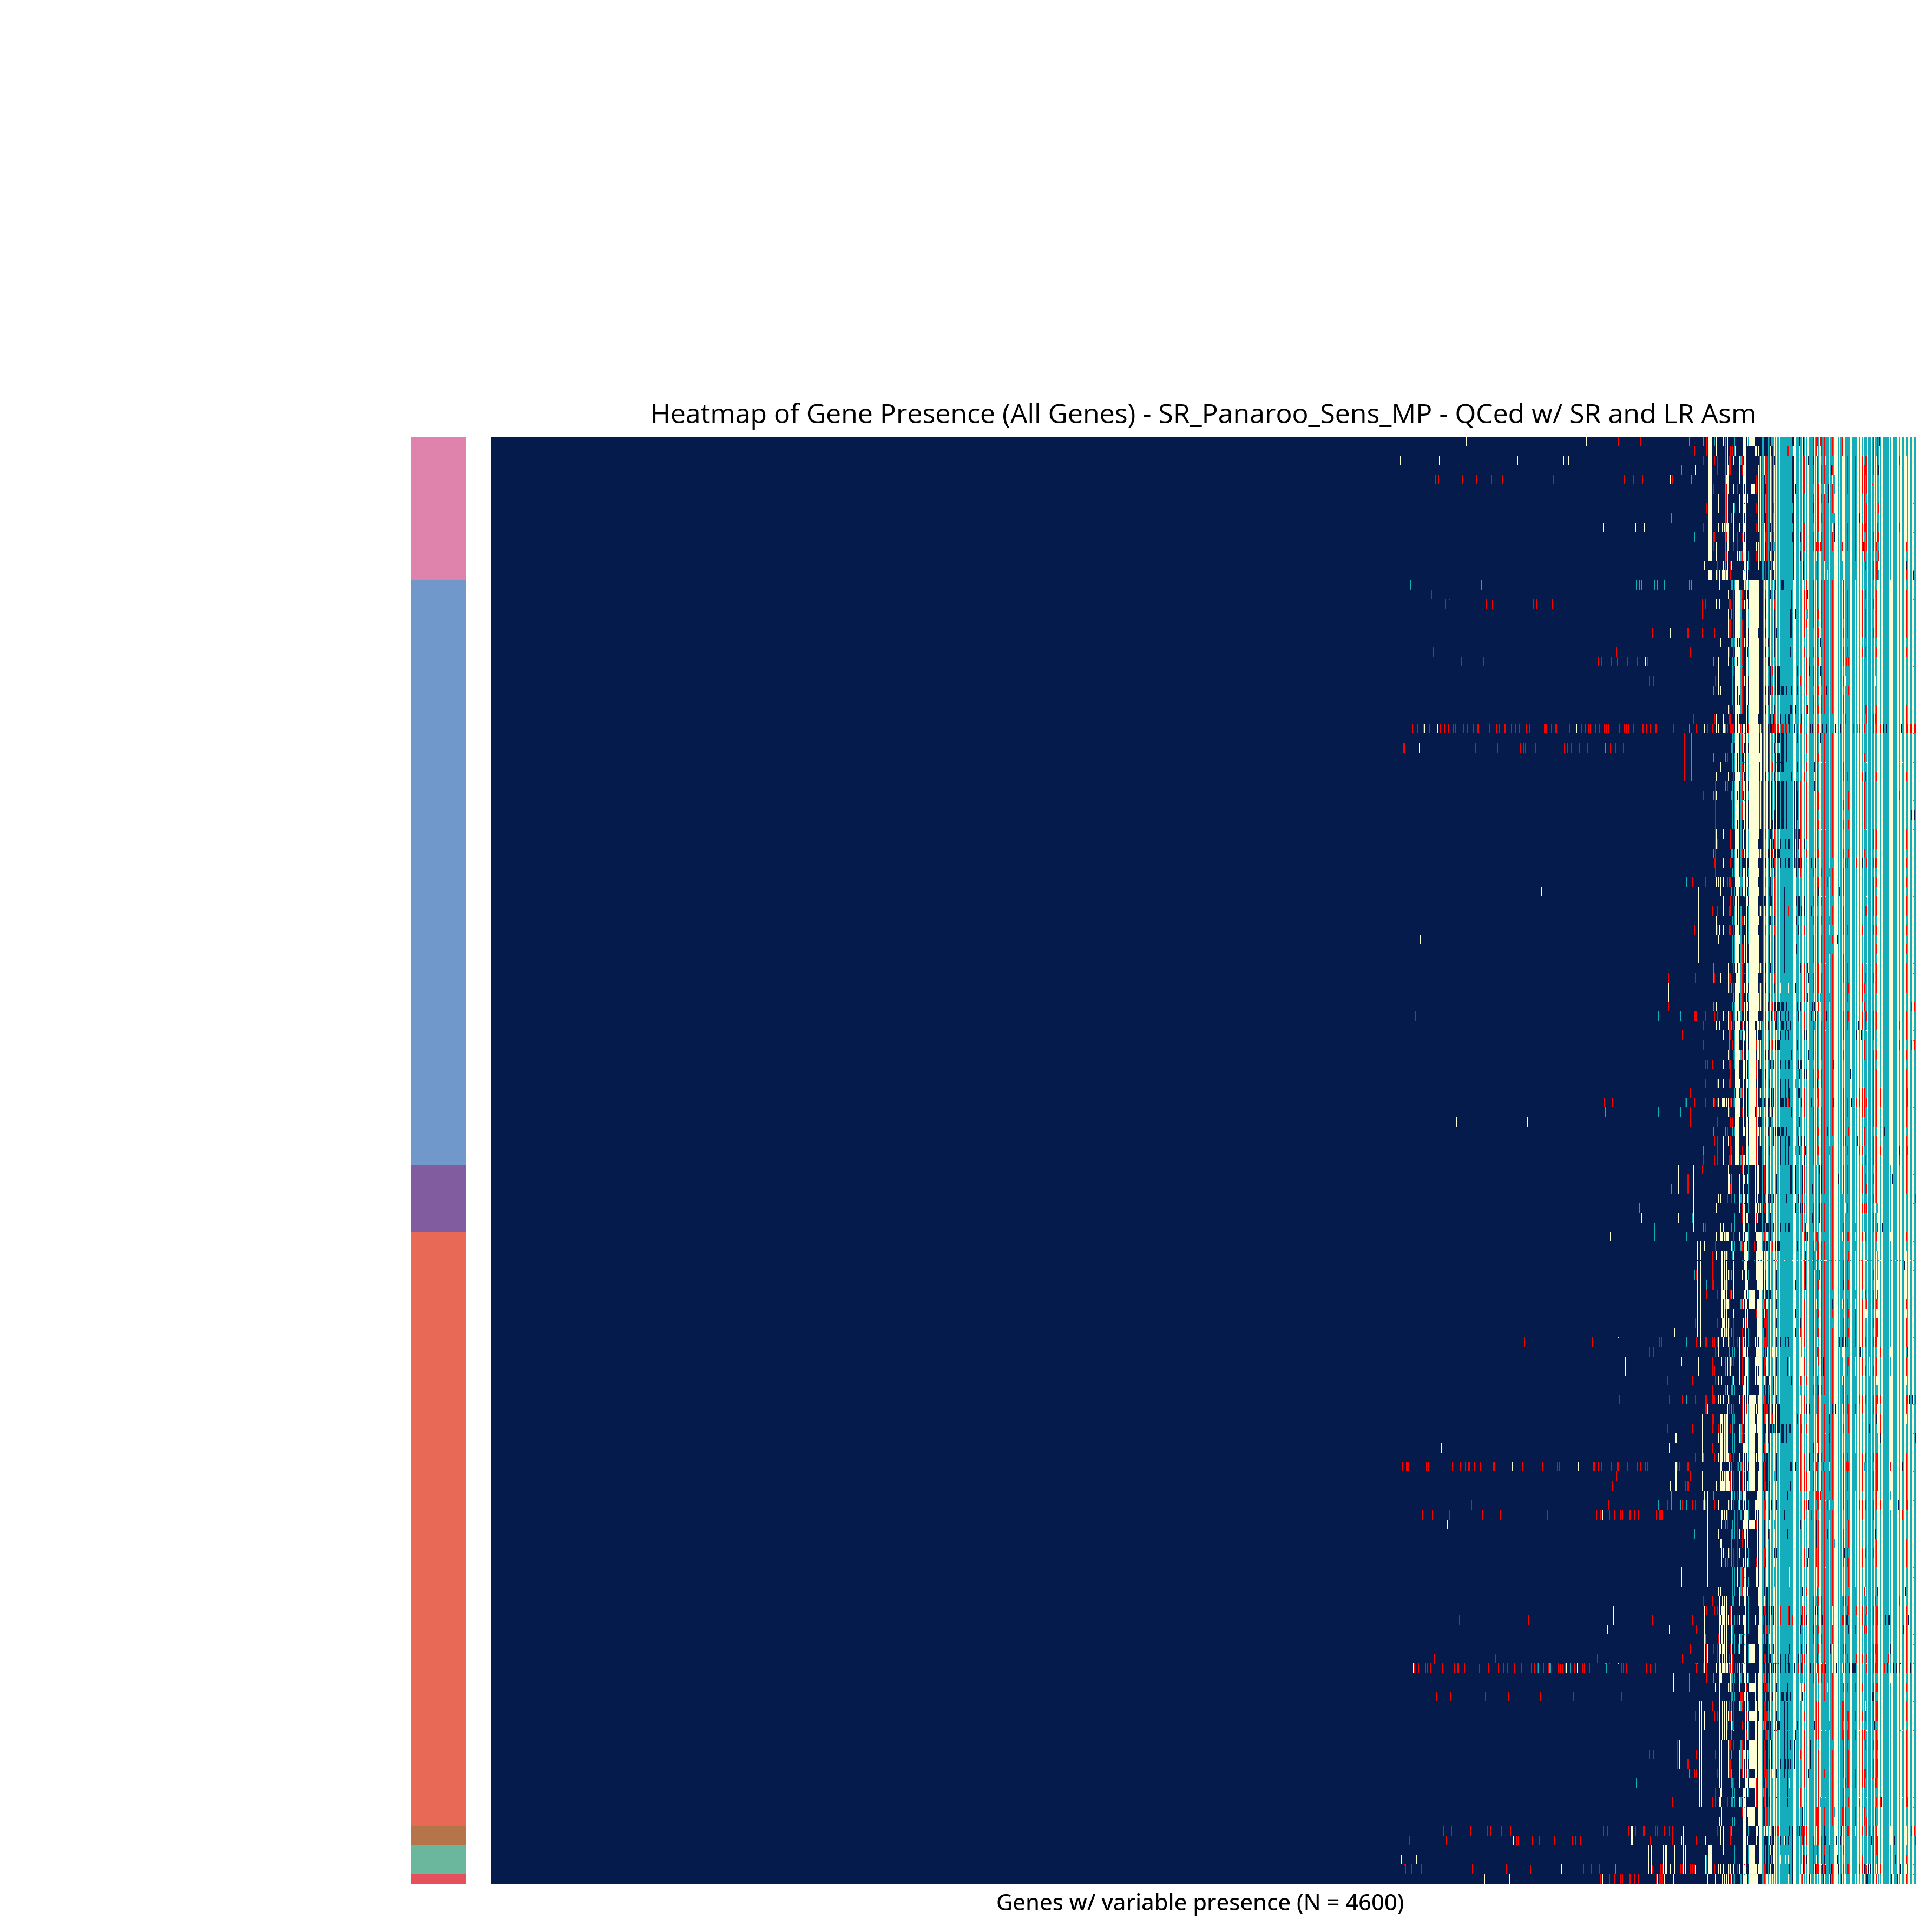

SR_Roary_NoSplitParalogs
(151, 5025)


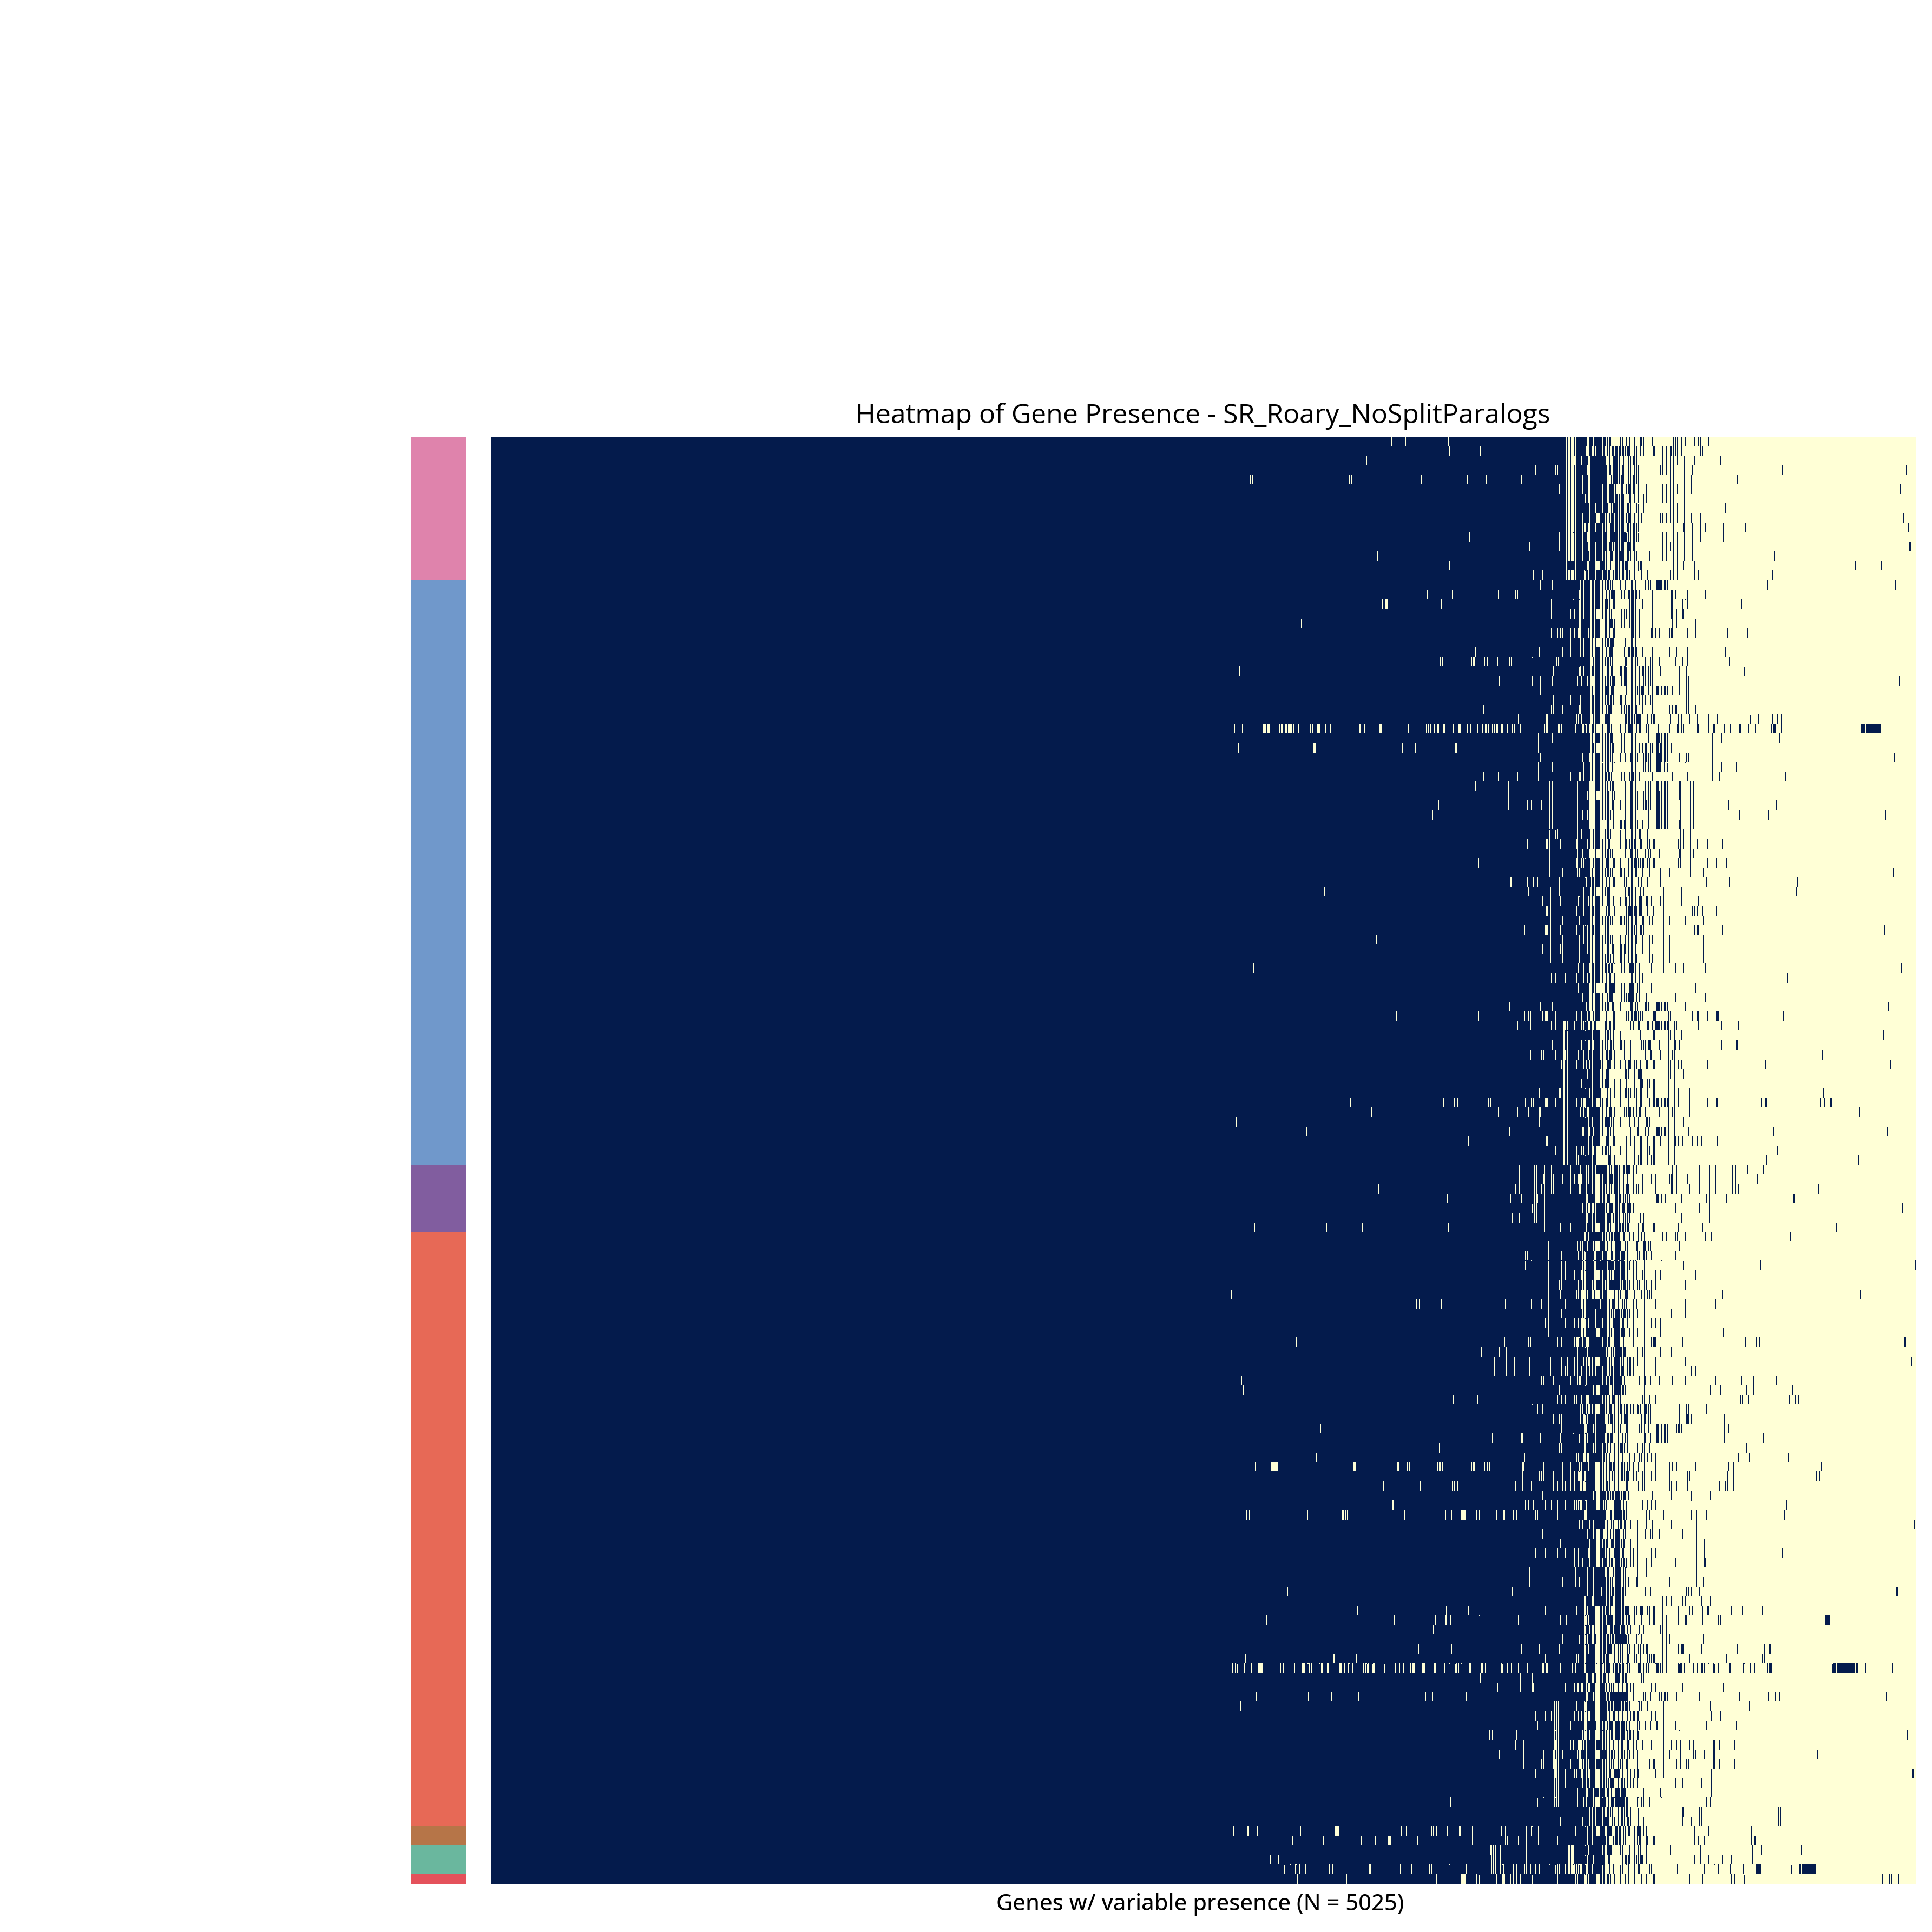

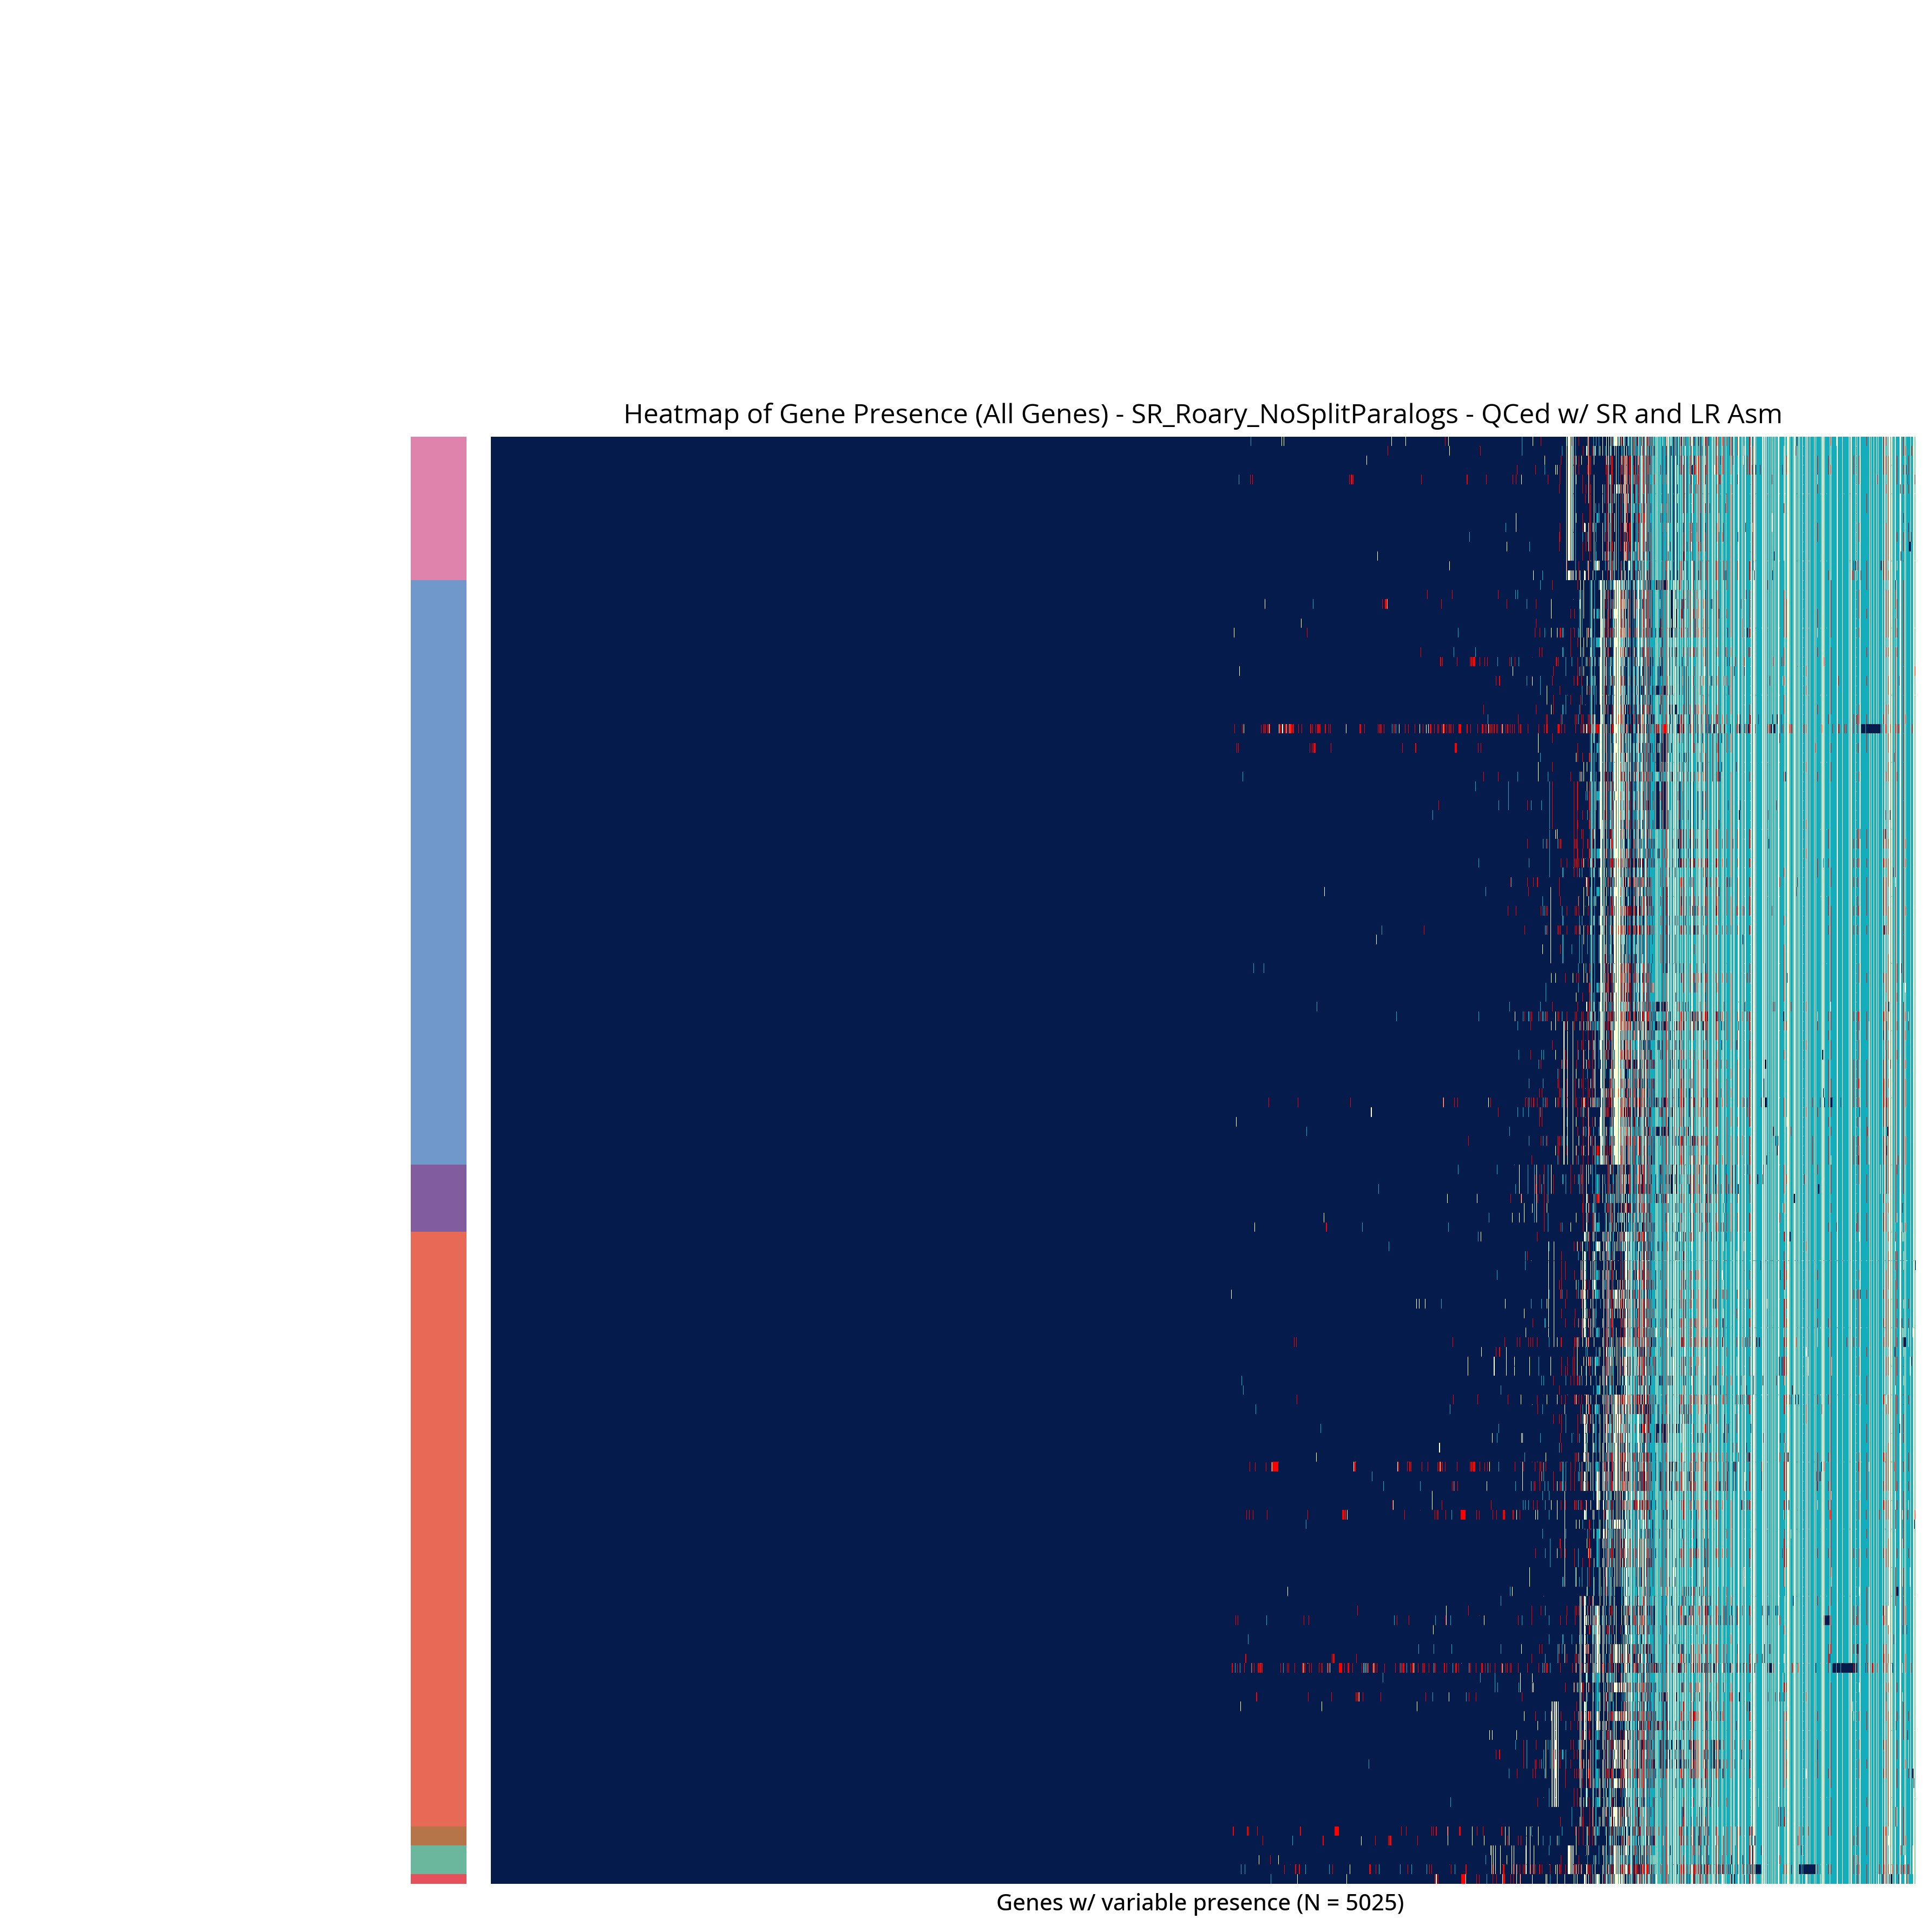

SR_Roary_NoSplitParalogs_I90
(151, 4956)


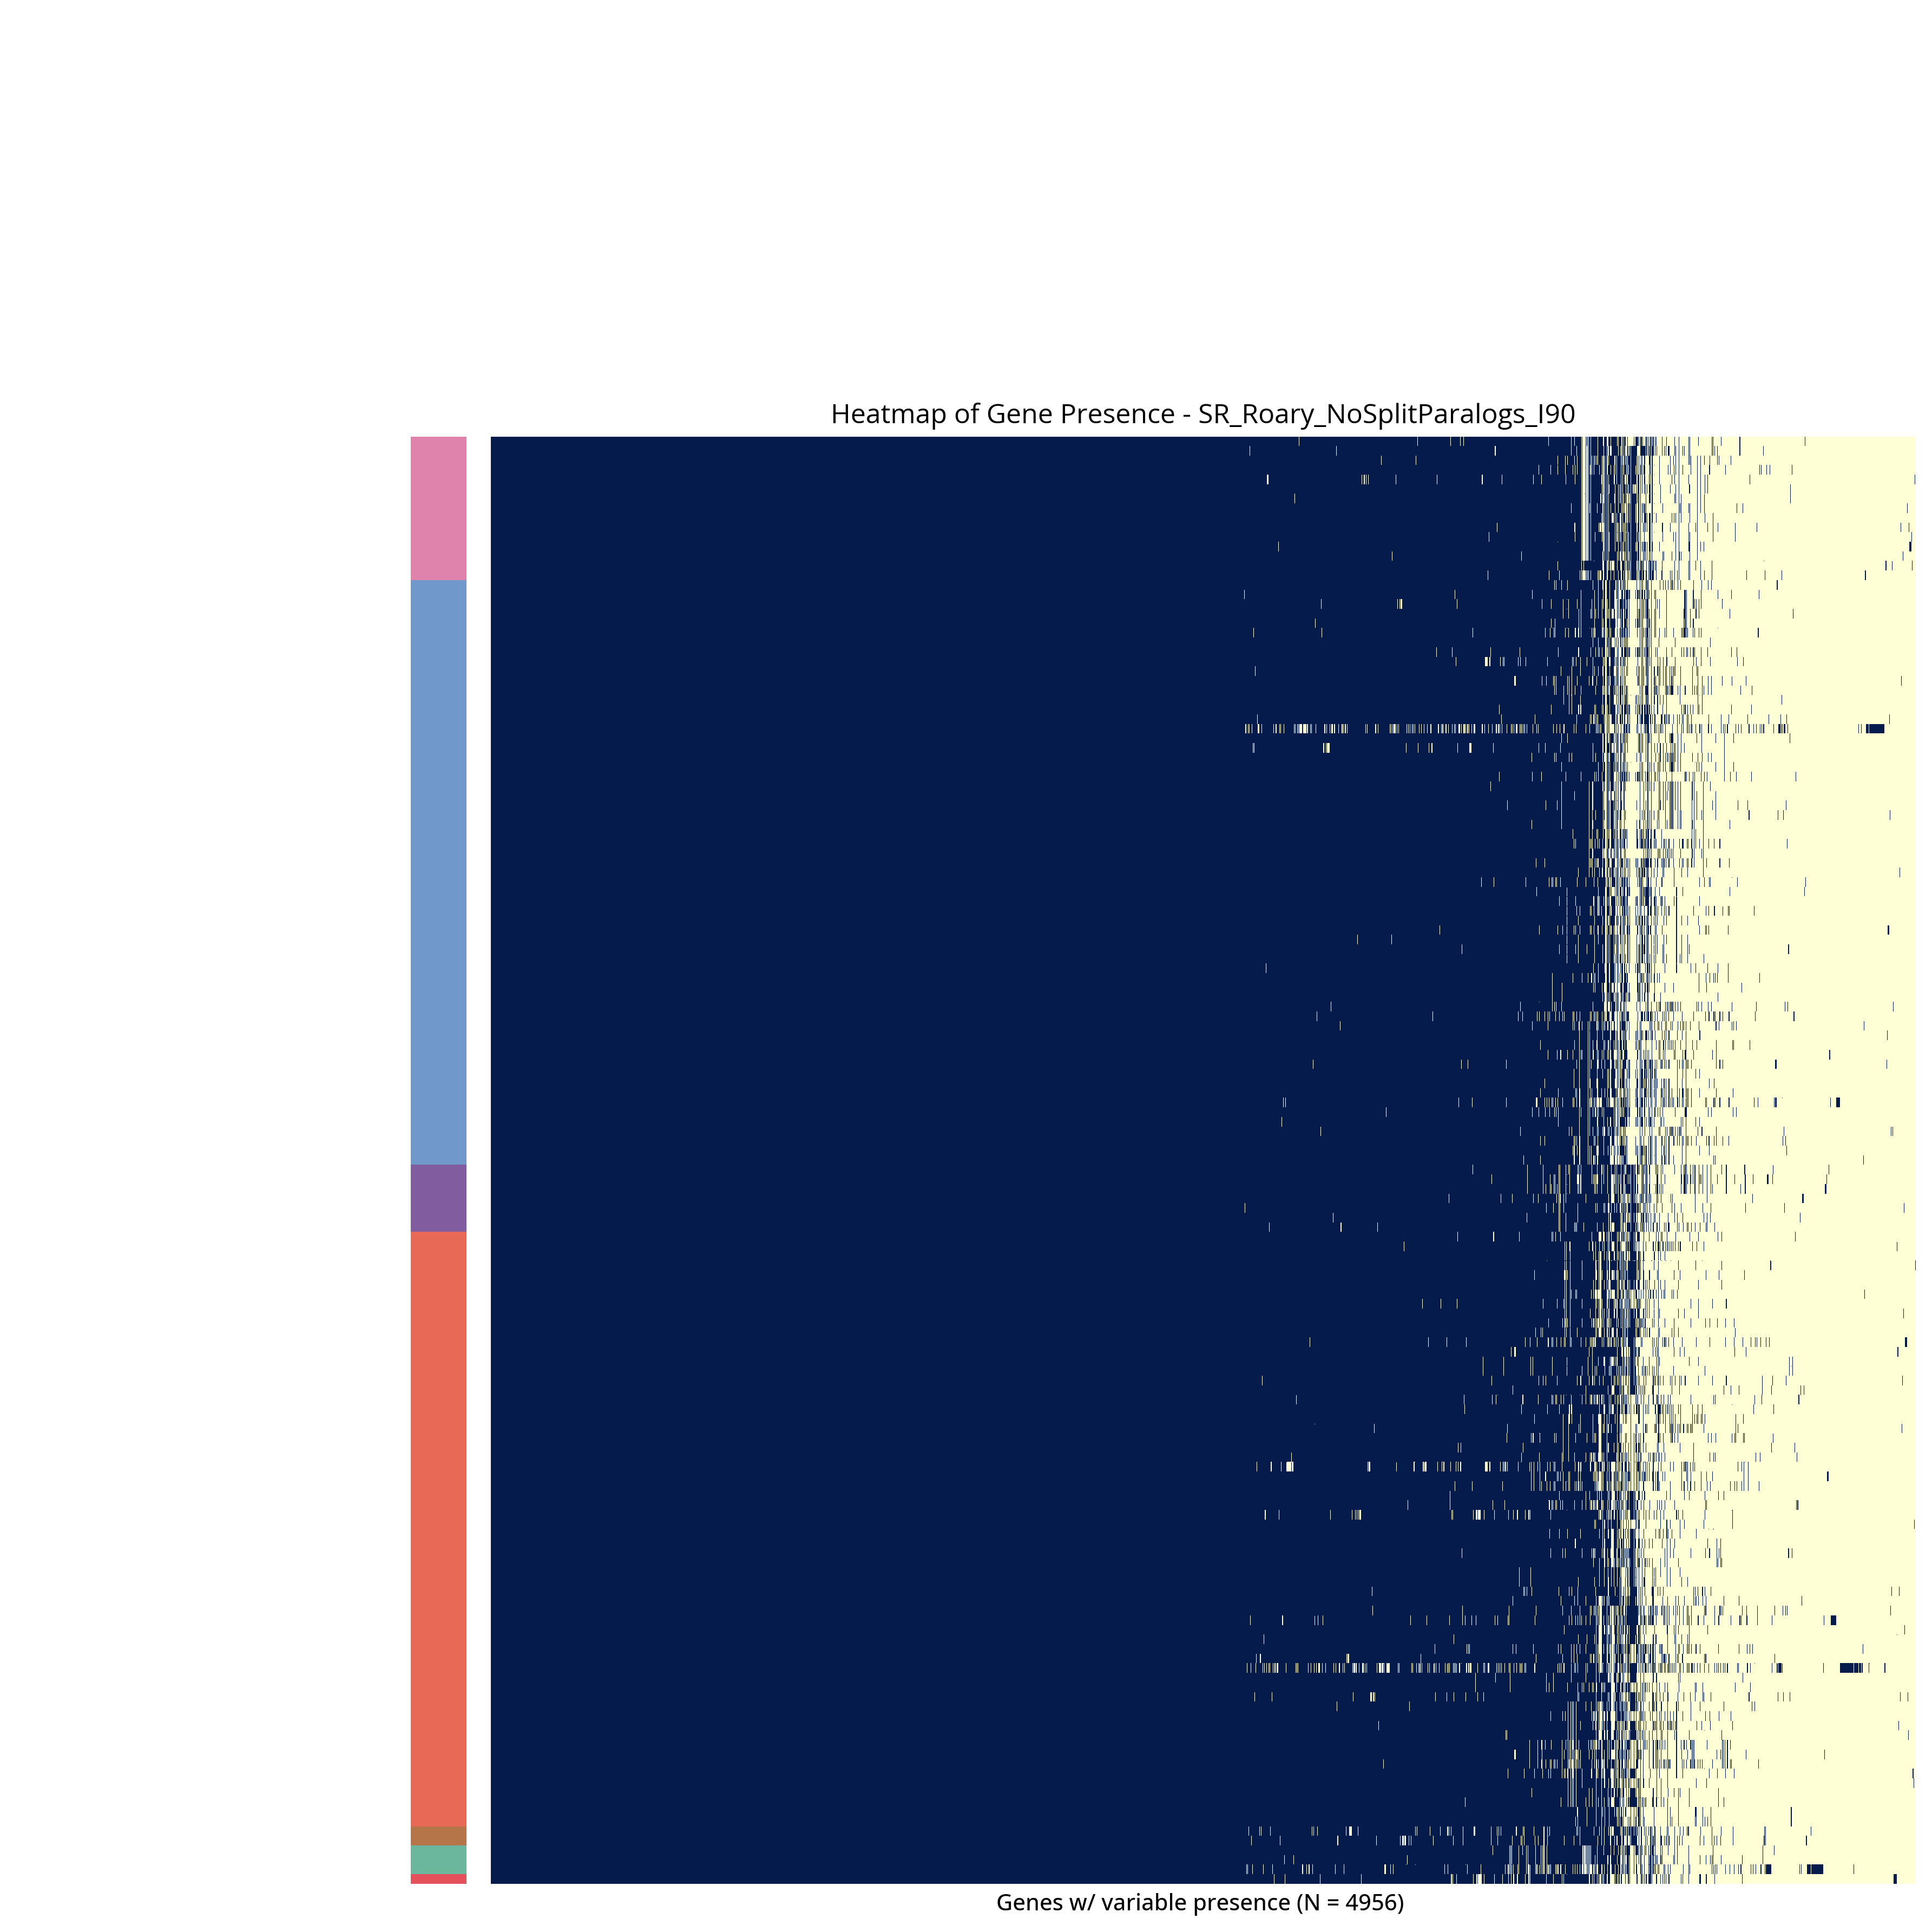

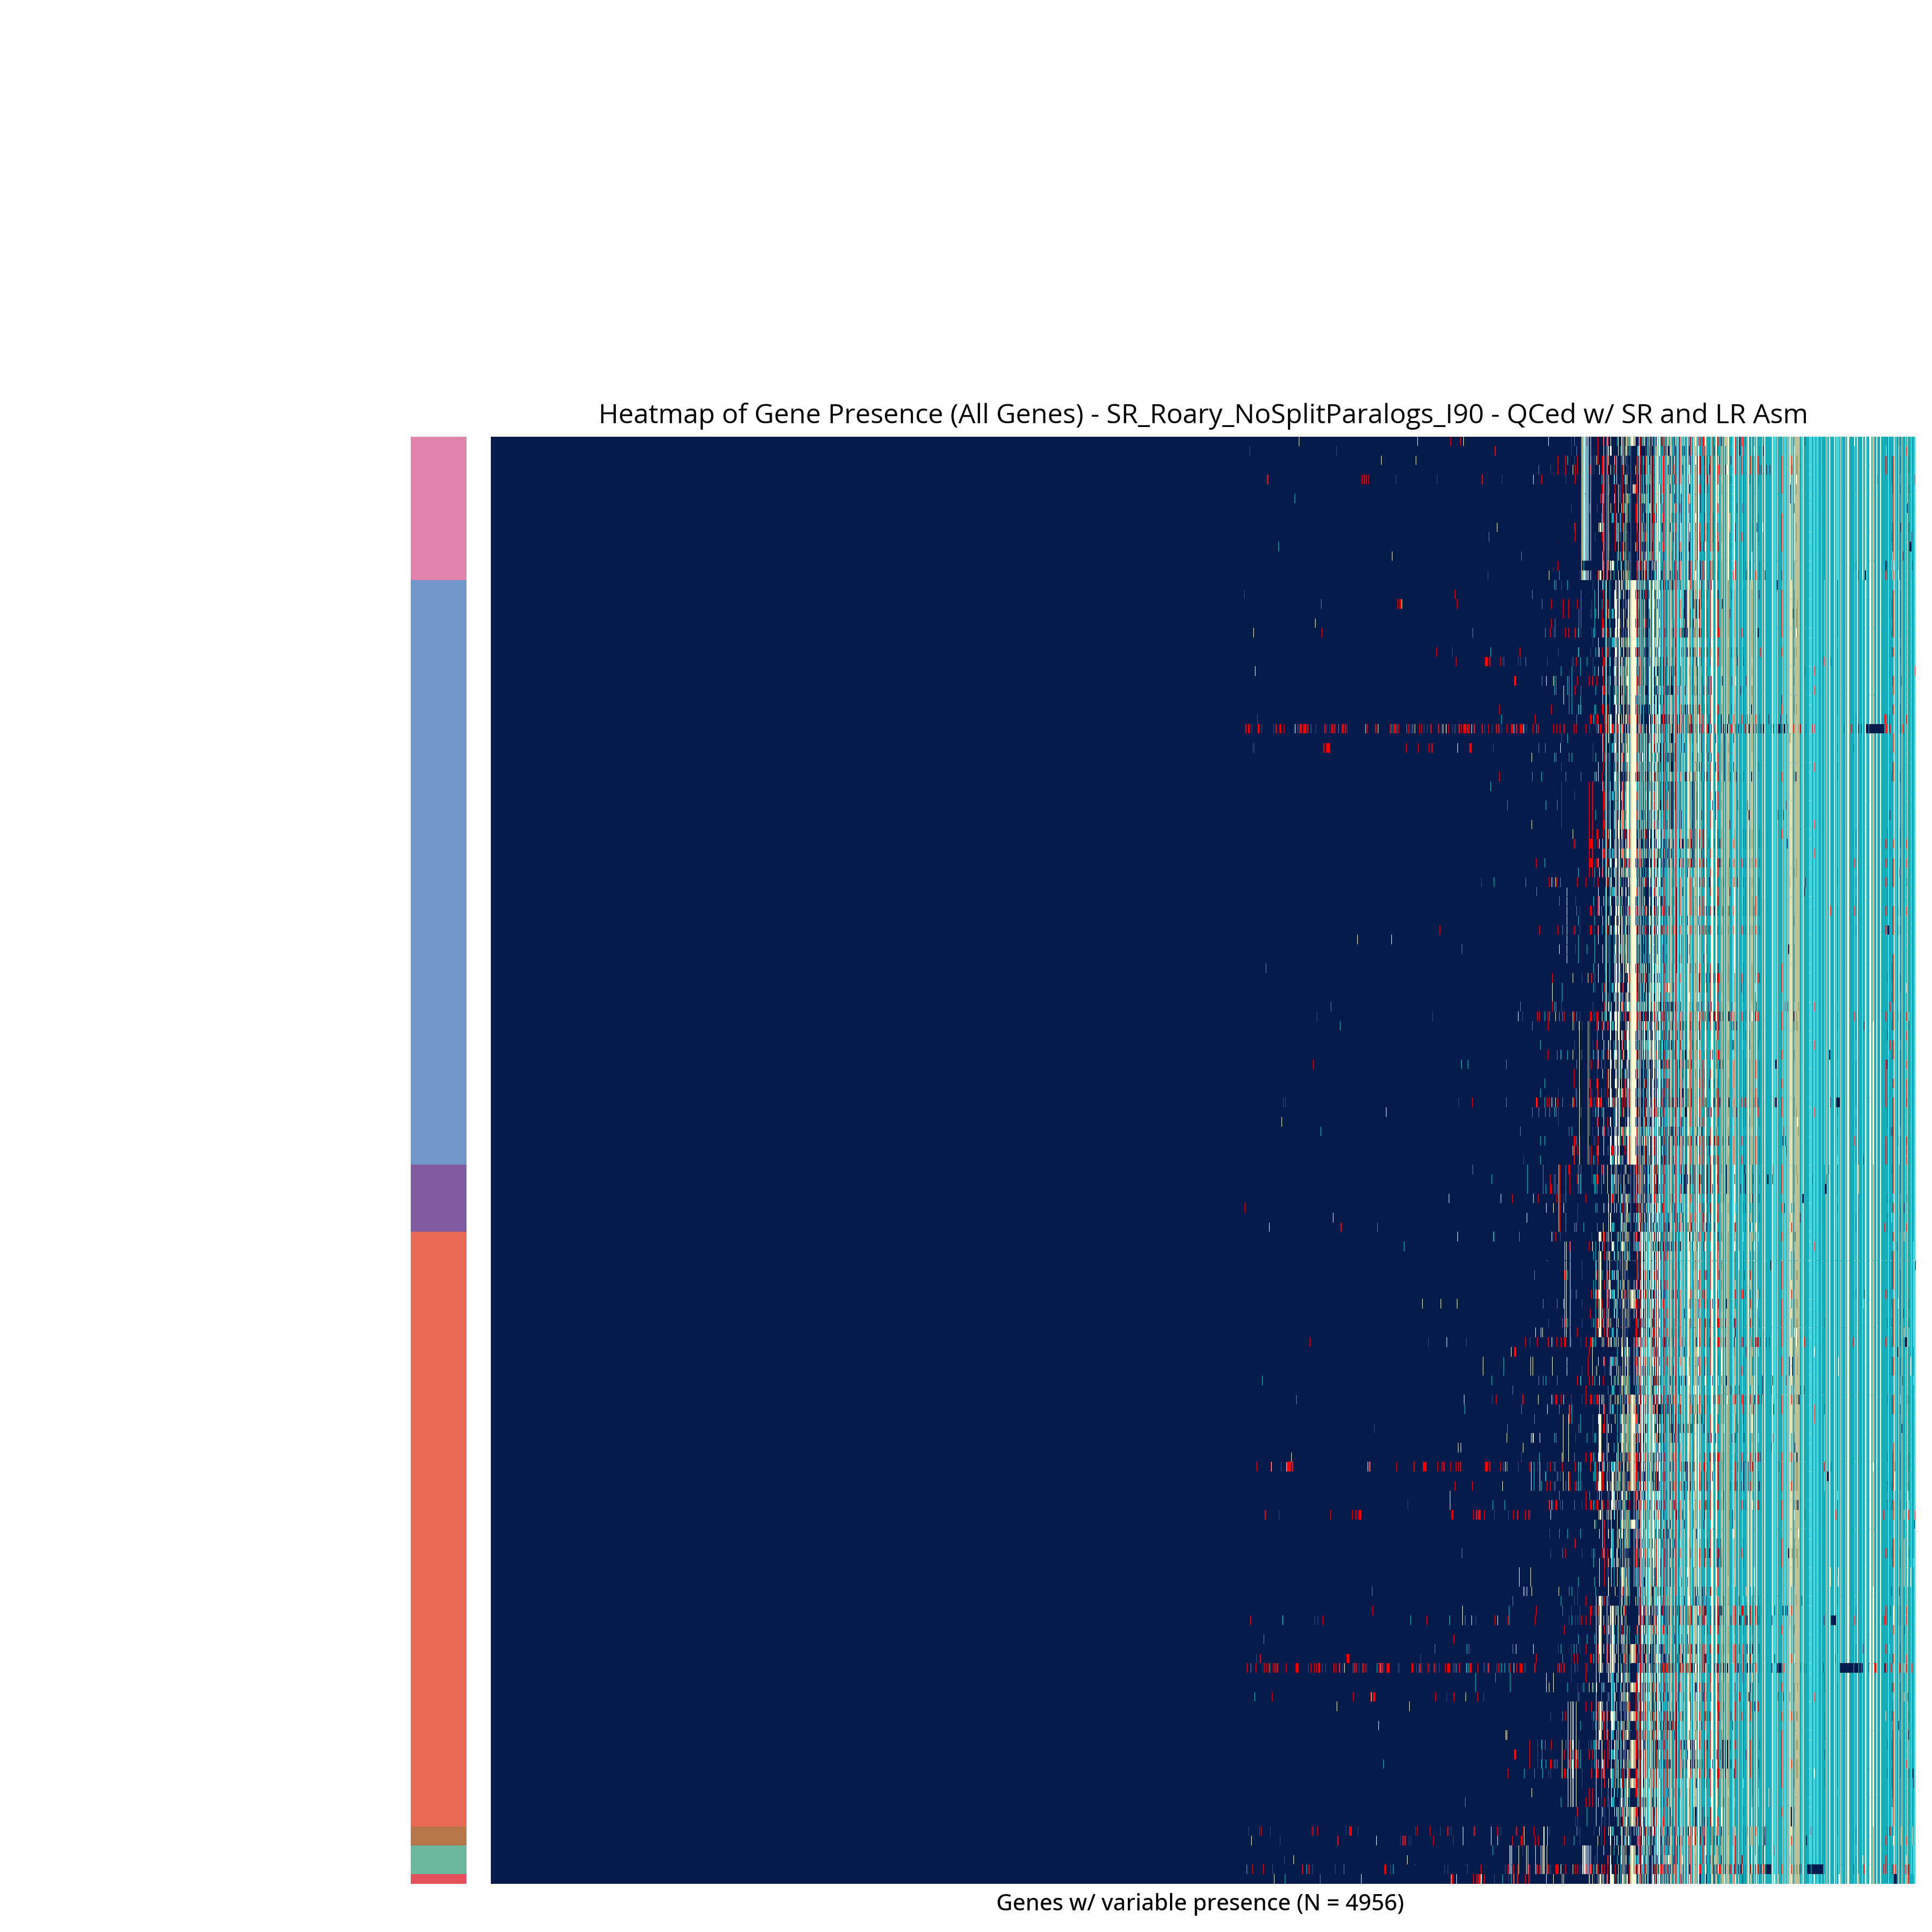

SR_Roary_NoSplitParalogs_I80
(151, 4866)


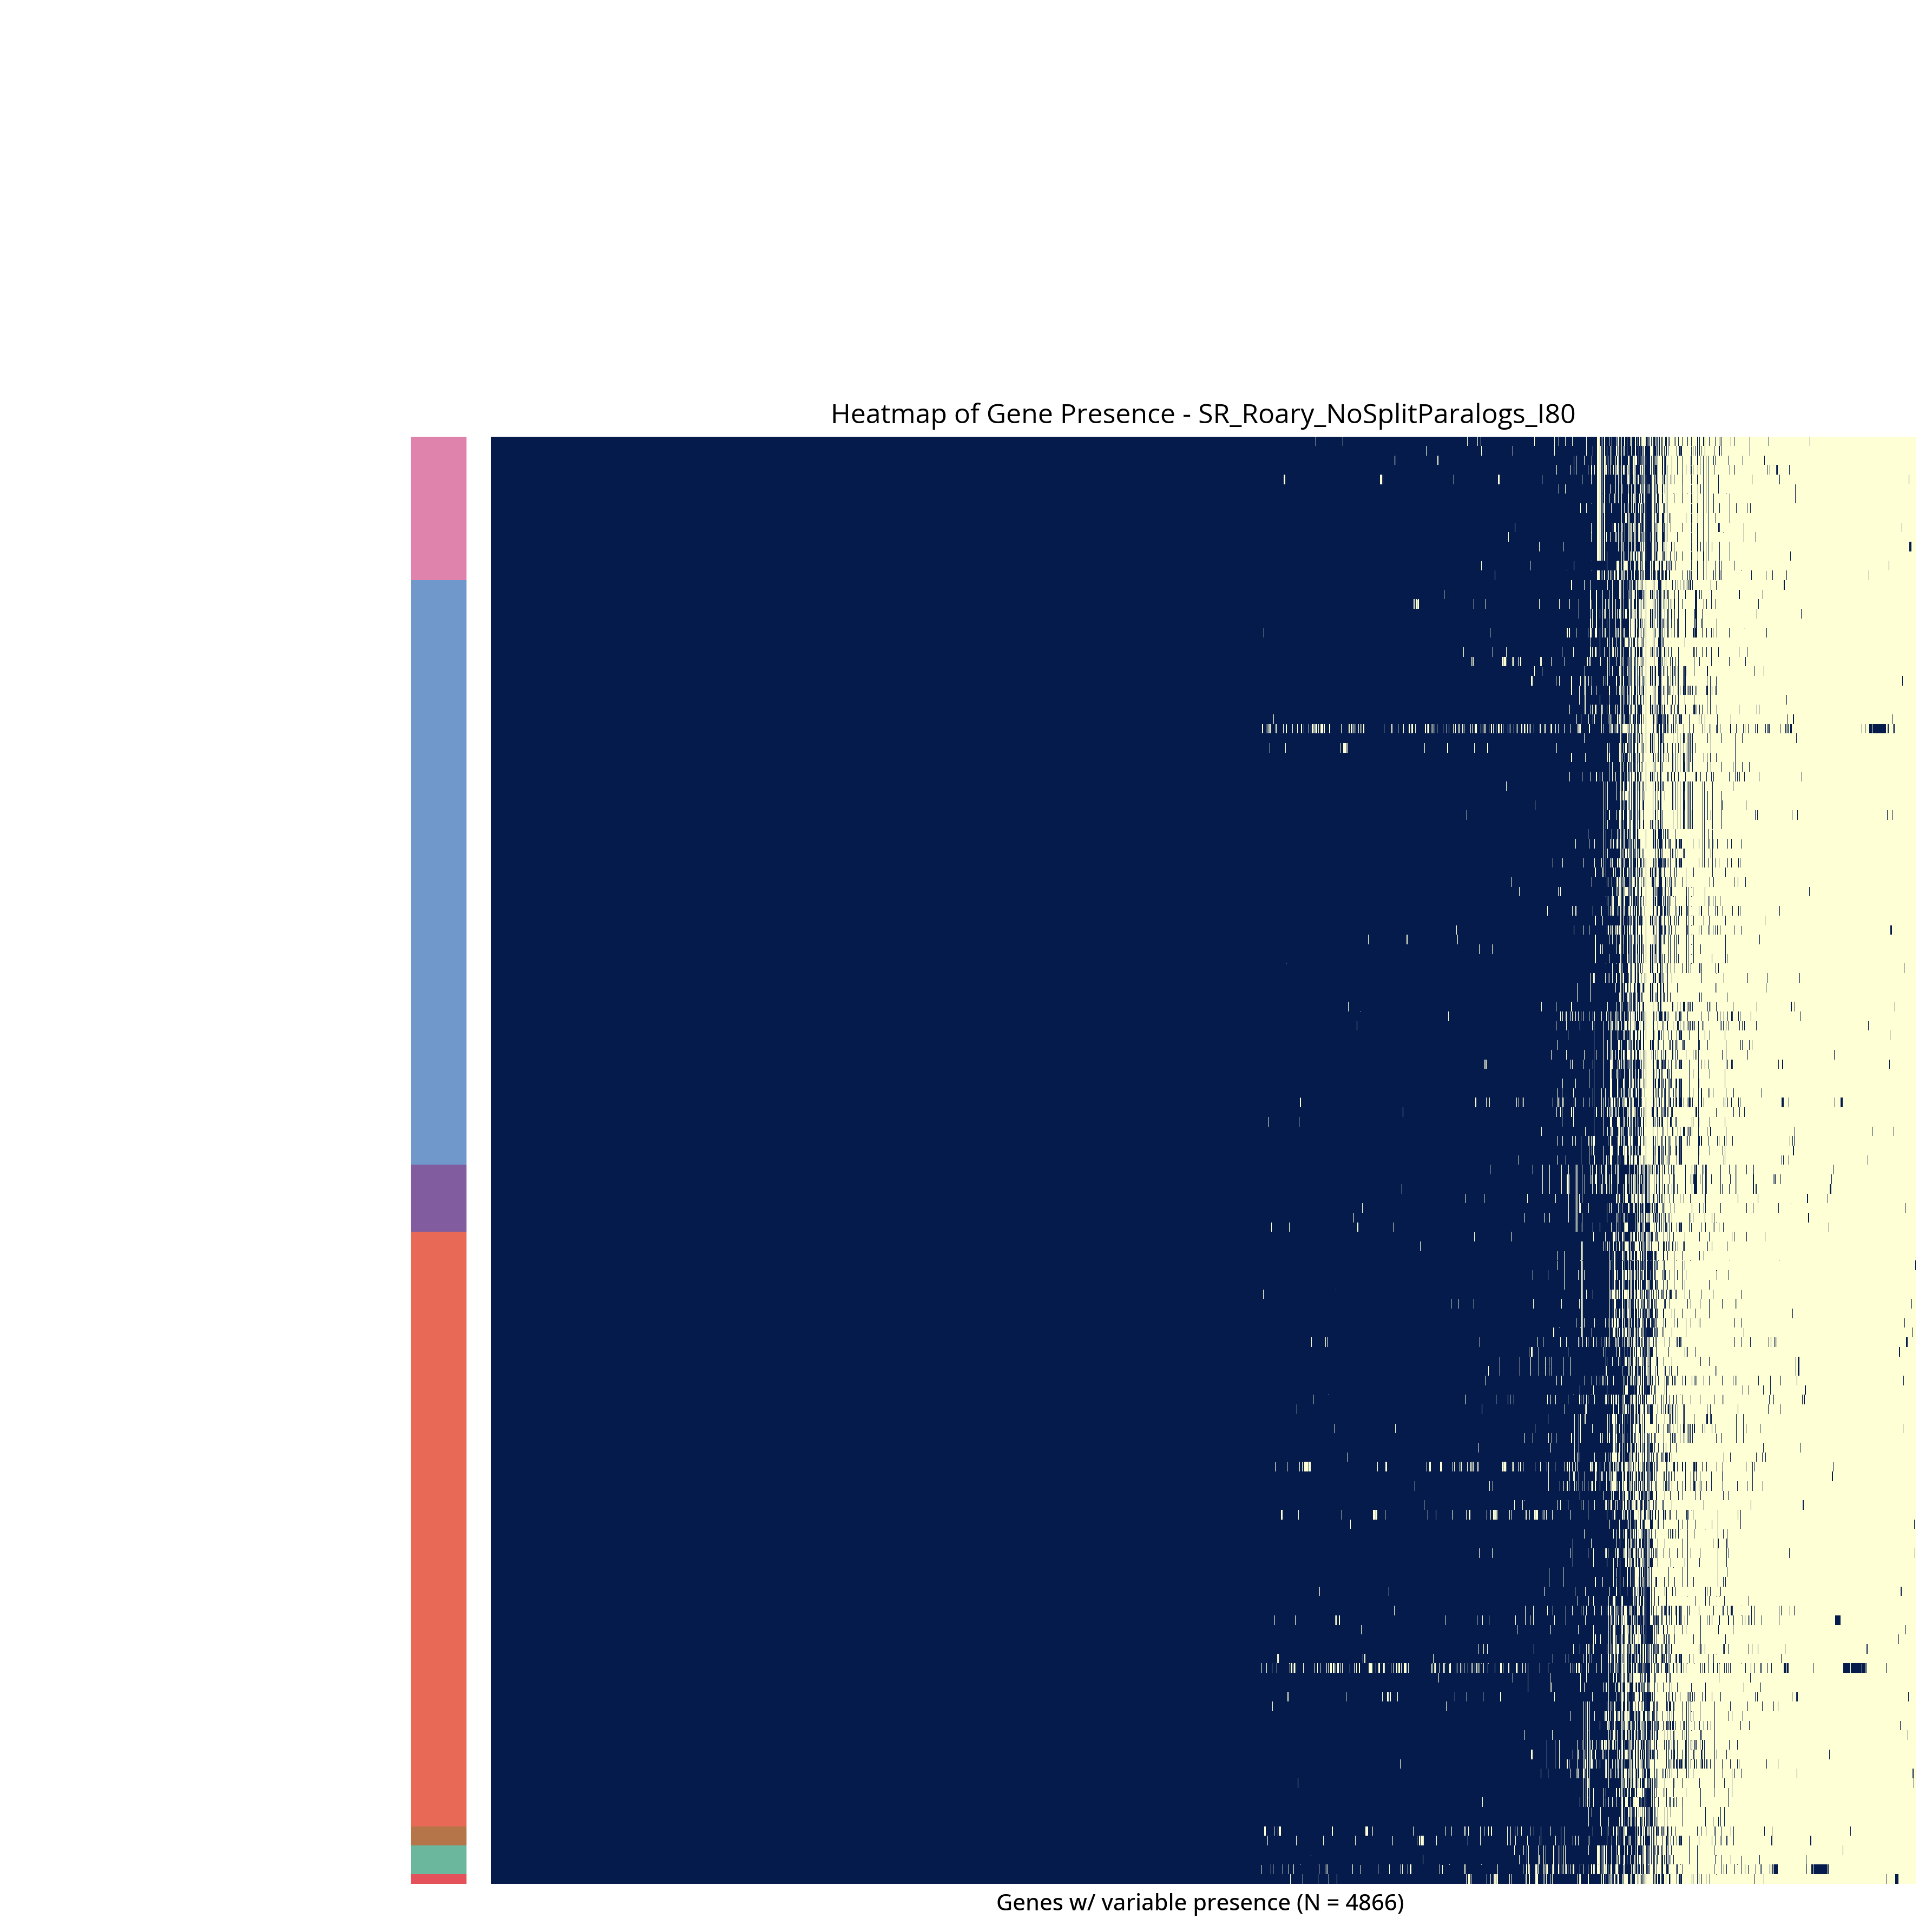

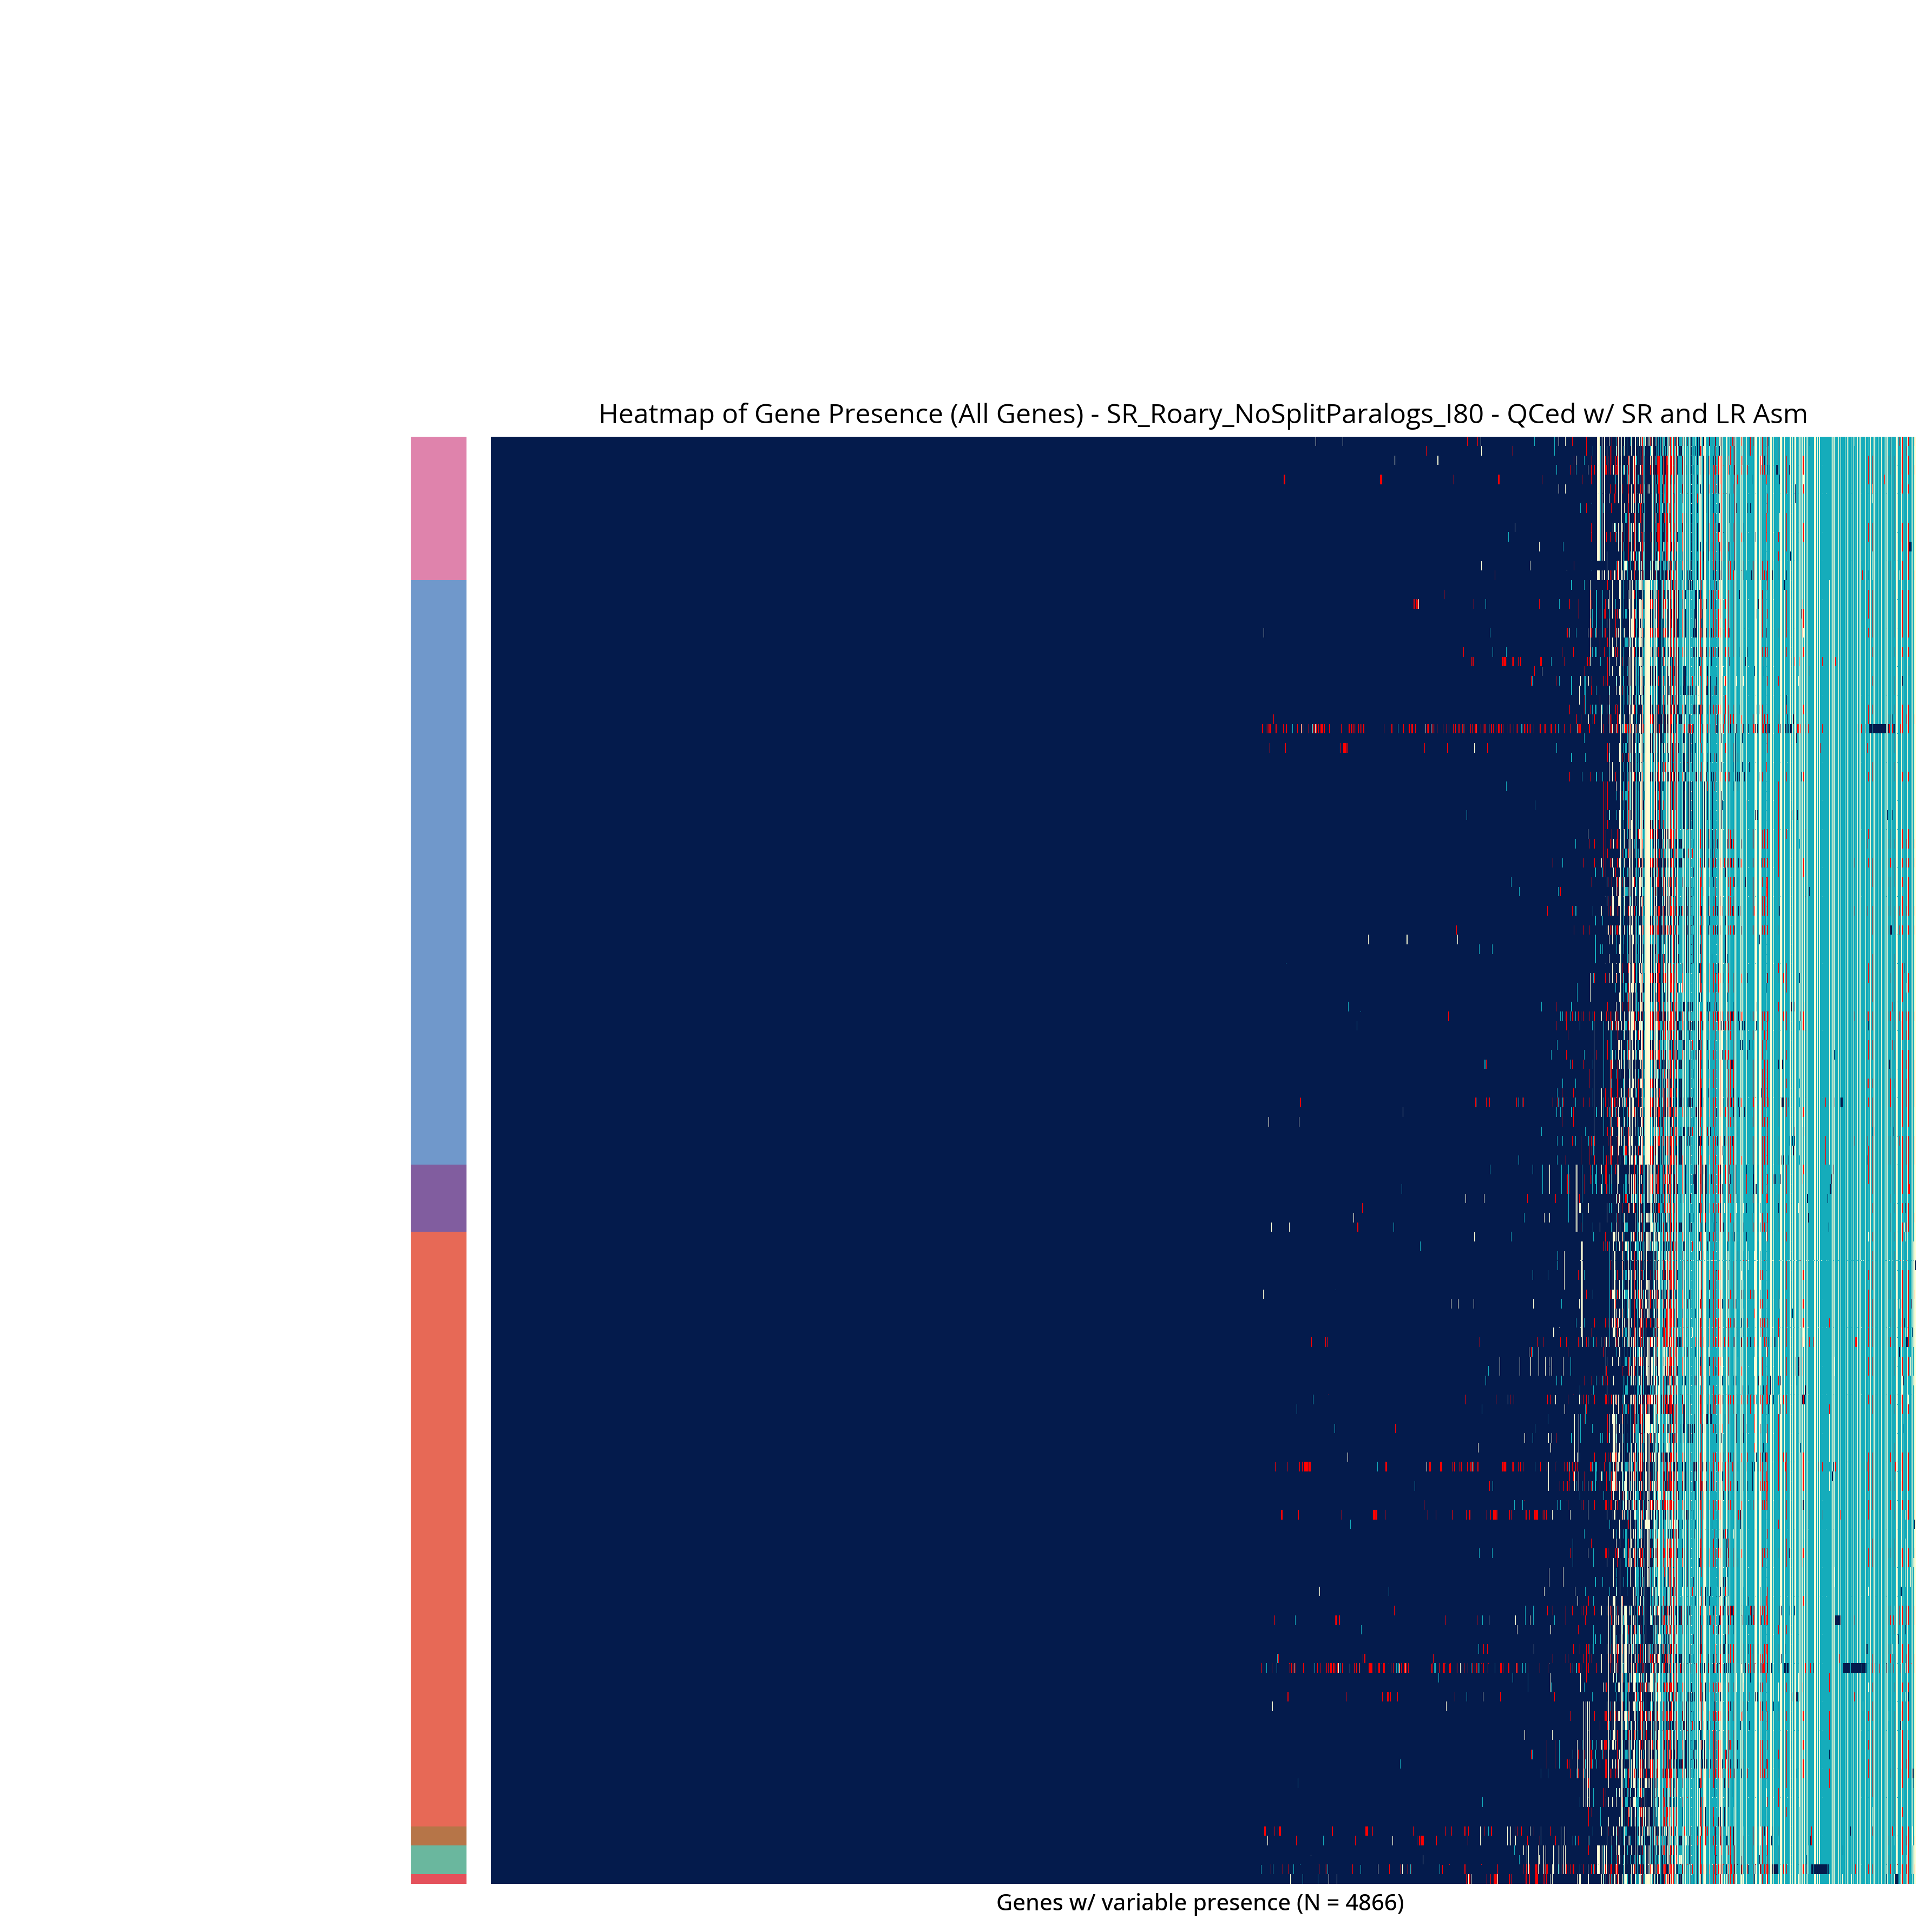

In [75]:
for i_Param in list(Pres_LRAsmQC_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = Pres_LRAsmQC_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

    #heatmap_data = DF.query("NumAsm_WiGene <= 150")[OrderOfSampleIDs_Phylo].T
    heatmap_data = DF[OrderOfSampleIDs_Phylo].T

    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_2, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel(f'Mtb Assemblies (N = {heatmap_data.shape[0]}) ')
    plt.ylabel('')
    
    plt.xlabel(f'Genes w/ variable presence (N = {heatmap_data.shape[1]}) ')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap, vmax= 5,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence (All Genes) - {i_Param} - QCed w/ SR and LR Asm')
    plt.ylabel(f'Mtb Assemblies (N = {heatmap_data.shape[0]}) ')
    plt.ylabel('')
    
    plt.xlabel(f'Genes w/ variable presence (N = {heatmap_data.shape[1]}) ')
    plt.show() 

    